## Fully connected dense models

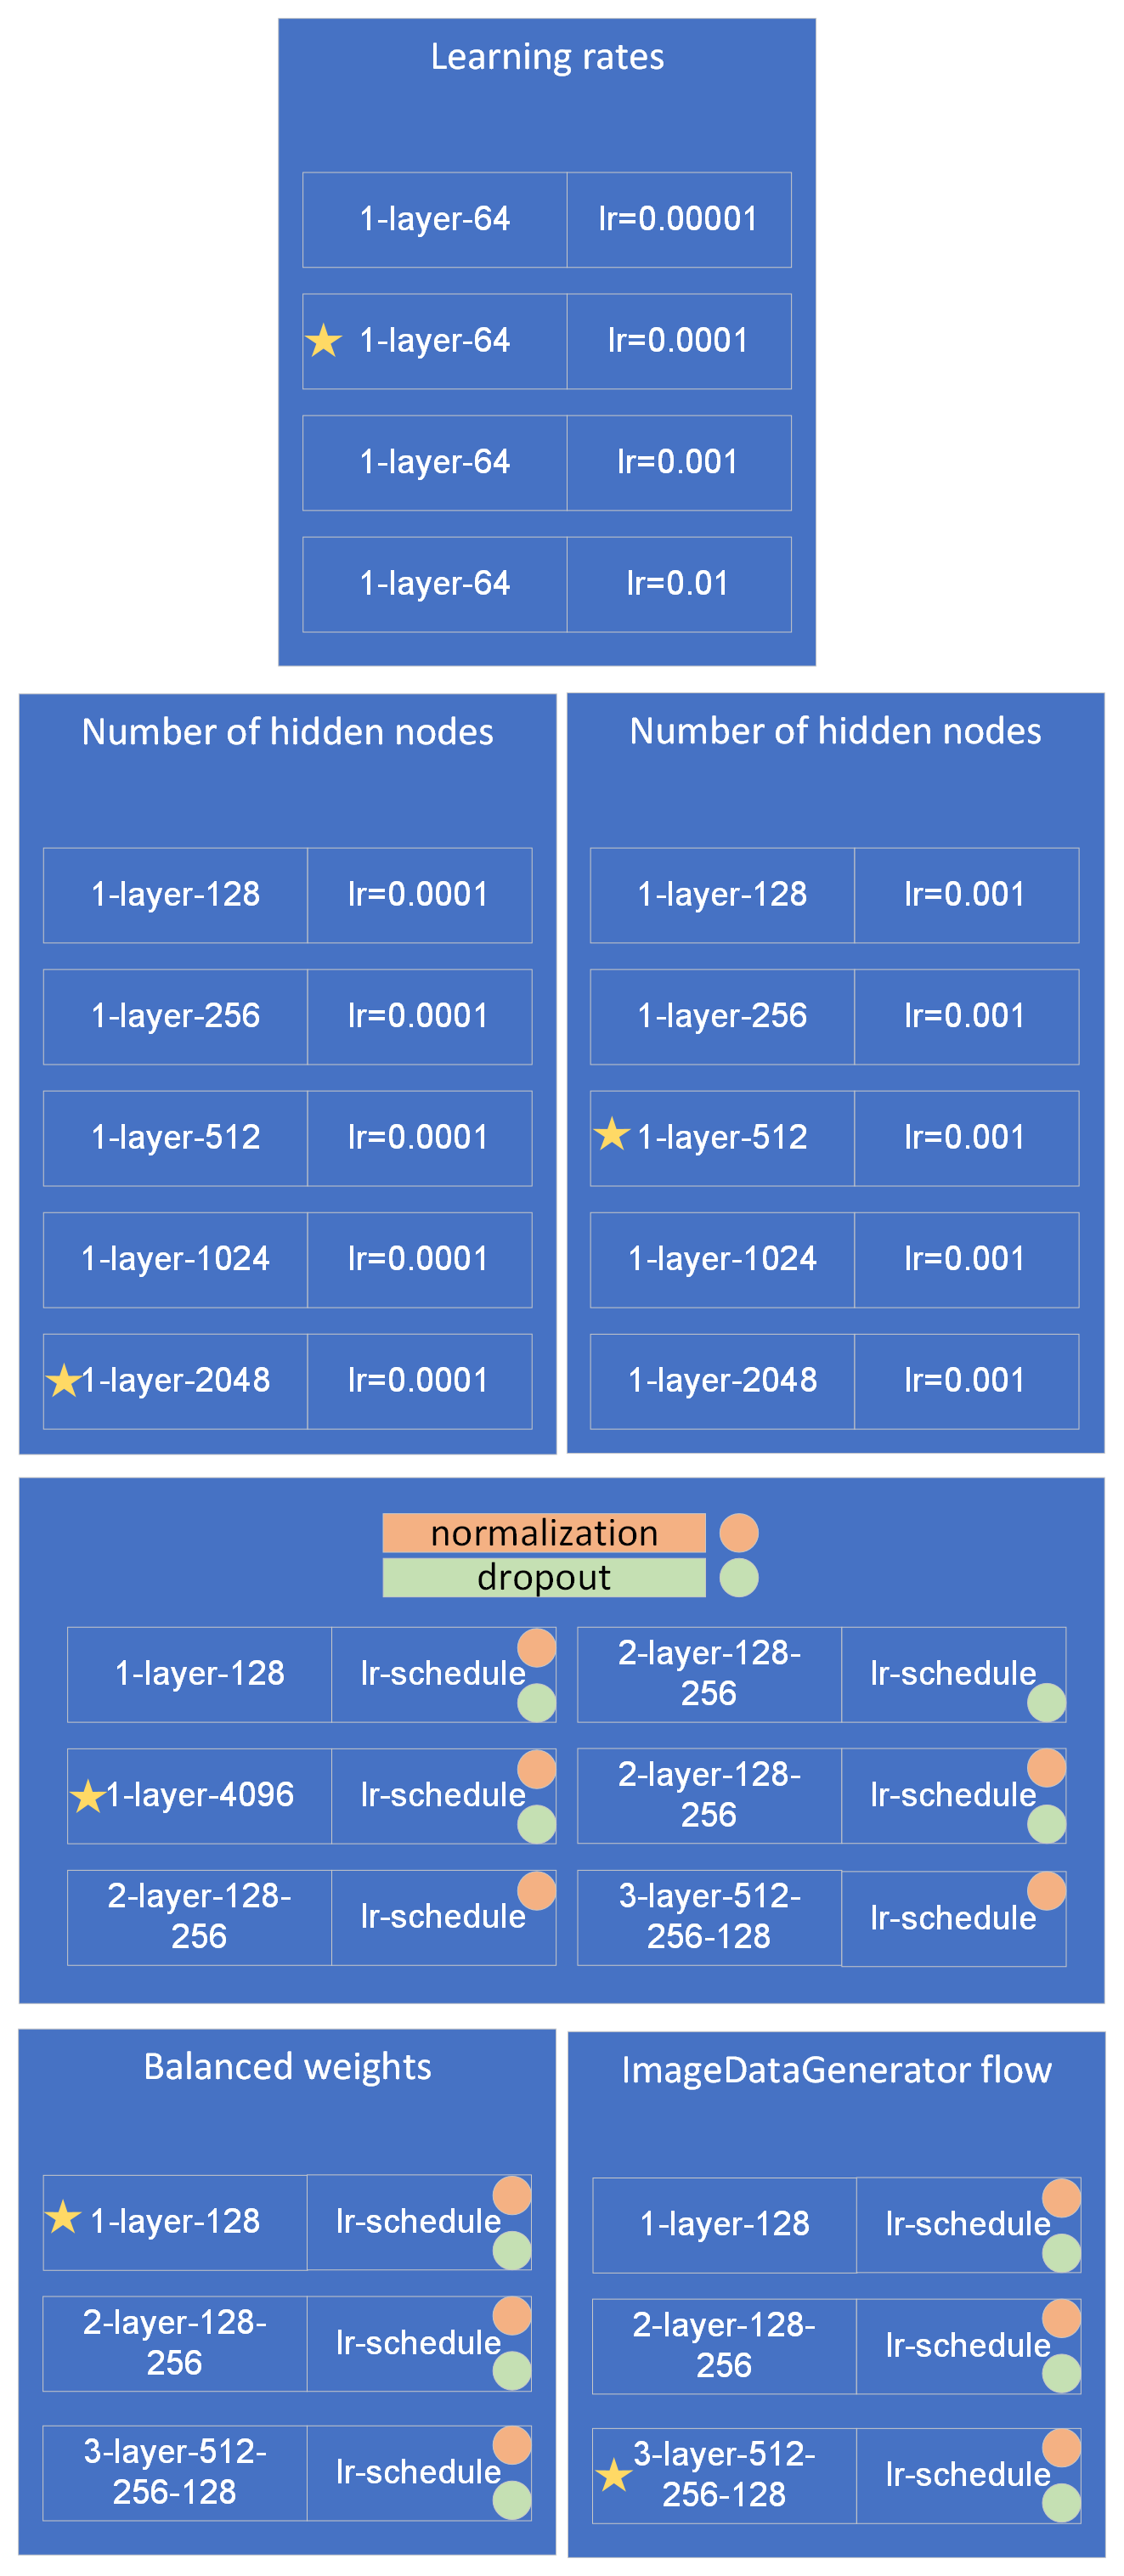

In [1]:
from IPython.display import Image
Image('densenets.png', width=500)

#### Import packages

In [2]:
import pandas
import numpy
import pickle
import sklearn
import sklearn.model_selection

# Graphs, visualizations
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

from tensorflow import keras
from keras.optimizers import Adam, SGD

# For Image Data Augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

batch_size = 1024

In [3]:
# Check for gpu support
# Troubleshooting: 
# Python Version = 3.7.9
# tensorflow Version = 2.3.0
# tf.keras Version = 2.4.0

# from platform import python_version
# print(python_version())
# print(tf.__version__)
# print(tf.keras.__version__)

# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
# Import Data From Pickle file

with open('y.pickle', 'rb') as f:
    y_data = pickle.load(f)
f.close()
y_data

with open('X.pickle', 'rb') as f:
    X_data = pickle.load(f)
f.close()
type(X_data)

list

In [38]:
def conf_matrix(model, x_test, y_test):
    
    y_pred = [1 * (x[0]>=0.5) for x in model.predict(x_test)]

    matrix = sklearn.metrics.confusion_matrix(y_test, y_pred)
    df_cm = pandas.DataFrame(matrix, index = [i for i in ['No Cancer (actual)', 'Cancer (actual)']],
                      columns = [i for i in ['predict No Cancer', 'predict Cancer']])
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True, fmt='d')
    return plt

def acc_df(histories):
    columns = ['model size' ,'loss', 'accuracy', 'val_loss', 'val_accuracy']
    df = pandas.DataFrame(columns = columns)
    for history in histories:
    
    # get the epoch with the highest validation accuracy for each history element
        i = 0
        index = 0
        comp = 0
        for val_acc in history.history['val_accuracy']:
            if val_acc > comp:
                comp = val_acc
                i = index
            index += 1

        df_temp = pandas.DataFrame([[history.model.name,
                                  history.history['loss'][i],
                                  history.history['accuracy'][i],
                                  history.history['val_loss'][i],
                                  history.history['val_accuracy'][i]]], 
                        columns = columns)
        df = df.append(df_temp)

    df = df.set_index('model size')

    df = df.style.format({
        'loss': '{:,.2f}'.format,
        'accuracy': '{:,.2%}'.format,
        'val_loss': '{:,.2f}'.format,
        'val_accuracy': '{:,.2%}'.format,
    })

    return df

def plot_accuracies(histories, colors, lower_ylim=.7, upper_ylim=.9, alpha=.6, **kwargs):
    
    i = 0
    colors=colors
    
    for history in histories:
        plt.plot(history.history['accuracy'], alpha=alpha, color=colors[i])
        i += 1
    plt.xlabel('epoch')
    plt.ylabel('train accuracy')
    plt.ylim([lower_ylim,upper_ylim])
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.legend([hist.model.name for hist in histories], loc='lower right')

    plt.show()
    i = 0
    for history in histories:
        plt.plot(history.history['val_accuracy'], alpha=alpha, color=colors[i])
        i += 1
    plt.xlabel('epoch')
    plt.ylabel('validation accuracy')
    plt.ylim([lower_ylim,upper_ylim])
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.legend([hist.model.name for hist in histories], loc='lower right')

    plt.show()
    
def prec_rec_df(models):
    columns = ['model' ,'precision (cancer positive)', 'recall (cancer positive)']
    df = pandas.DataFrame(columns = columns)
    for model in models:
        matrix = sklearn.metrics.confusion_matrix(y_test, [1 * (x[0]>=0.5) for x in model.predict(x_test)])
        precision = matrix[1][1]/(matrix[1][1]+matrix[0][1])
        recall = matrix[1][1]/(matrix[1][1]+matrix[1][0])


        df = df.append(pandas.DataFrame([[model.name,
                                      precision,
                                      recall]], 
                            columns = columns))
    df = df.set_index('model')

    df = df.style.format({
        'precision (cancer positive)': '{:,.2%}'.format,
        'recall (cancer positive)': '{:,.2%}'.format})

    return df

### Callbacks ###

#Early stopping callback
es = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=30, verbose=2,
                                      mode='max', baseline=None, restore_best_weights=True)

#Learning Rate Annealer
lrr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                       factor=.1,
                       patience=15,
                       min_lr=1e-4,
                       verbose=2)


In [6]:
# Train-validation-test split
# 60% Train, 20% Test, 20% Validation 

# train test split for validation after training x_test is never touched or looked at during training
x_train,x_test,y_train,y_test=sklearn.model_selection.train_test_split(numpy.asarray(X_data),
                                                                       numpy.asarray(y_data),
                                                                       test_size=.2,
                                                                       random_state=42)

# train test split for validation during training
x_train,x_val,y_train,y_val=sklearn.model_selection.train_test_split(x_train,
                                                                     y_train,
                                                                     test_size=.25,
                                                                     random_state=42)

#Dimension of the kaggle dataset & percentage of negative patches
print(x_train.shape,y_train.shape, 1-sum(y_train)/y_train.shape[0])
print(x_test.shape,y_test.shape, 1-sum(y_test)/y_test.shape[0])
print(x_val.shape,y_val.shape, 1-sum(y_val)/y_val.shape[0])

input_shape=x_train.shape[1:]
input_shape

(166514, 50, 50, 3) (166514,) 0.7144444310988866
(55505, 50, 50, 3) (55505,) 0.7182415998558689
(55505, 50, 50, 3) (55505,) 0.7189802720475633


(50, 50, 3)

In [7]:
# lower the number of epochs
epochs = 150

total = numpy.asarray(y_data).shape[0]
pos = sum(numpy.asarray(y_data))
neg = total - pos

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
# weight_for_0 = (1 / neg) * (total / 2.0)
# weight_for_1 = (1 / pos) * (total / 2.0)

weight_for_0 = (1 / neg) * total
weight_for_1 = (1 / pos) * total

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))


del X_data
del y_data

Weight for class 0: 1.40
Weight for class 1: 3.52


### Learnings
* The data of positive and negative samples is unbalanced, where patients have more negative patches than positive ones
* This could lead to an imbalanced result where we classify more patches as negative, which would be a severe mistake in cancer detection. A confusion matrix should be sufficient so verify this concern, when the model is trained
* The baseline for analysing the accuracy of our models is around 71.9%, where all patches would be classified as non malignant

### Learning Rates

As a first network we:
- Flatten the input from the images
- Use one hidden layer with 64 neurons and a sigmoid activation function
- Use one sigmoid activation function for the ouput layer

And experiment with different learning rates:

In [8]:
epochs = 1000
histories = []

name="1-layer-64-lr-0.00001"
model1 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model1.save_weights('model.h5')
model1.compile(loss="binary_crossentropy", optimizer=SGD(learning_rate=0.00001), metrics=["accuracy"])
histories.append(model1.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val,y_val)))

name="1-layer-64-lr-0.0001"
model2 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model2.load_weights('model.h5')
model2.compile(loss="binary_crossentropy", optimizer=SGD(learning_rate=0.0001), metrics=["accuracy"])
histories.append(model2.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val,y_val)))

name="1-layer-64-lr-0.001"
model3 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model3.load_weights('model.h5')
model3.compile(loss="binary_crossentropy", optimizer=SGD(learning_rate=0.001), metrics=["accuracy"])
histories.append(model3.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val,y_val)))

name="1-layer-64-lr-0.01"
model4 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model4.load_weights('model.h5')
model4.compile(loss="binary_crossentropy", optimizer=SGD(learning_rate=0.01), metrics=["accuracy"])
histories.append(model4.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val,y_val)))
hist0 = histories

Epoch 1/1000
163/163 [==============================] - 1s 6ms/step - loss: 28.8599 - accuracy: 0.6276 - val_loss: 2.9471 - val_accuracy: 0.6298
Epoch 2/1000
163/163 [==============================] - 1s 5ms/step - loss: 3.4699 - accuracy: 0.6683 - val_loss: 4.0177 - val_accuracy: 0.7210
Epoch 3/1000
163/163 [==============================] - 1s 5ms/step - loss: 1.7335 - accuracy: 0.6745 - val_loss: 1.3310 - val_accuracy: 0.7304
Epoch 4/1000
163/163 [==============================] - 1s 5ms/step - loss: 1.2115 - accuracy: 0.6984 - val_loss: 1.0461 - val_accuracy: 0.6973
Epoch 5/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.9916 - accuracy: 0.7130 - val_loss: 0.9311 - val_accuracy: 0.7069
Epoch 6/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.8872 - accuracy: 0.7186 - val_loss: 0.8321 - val_accuracy: 0.7280
Epoch 7/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.7987 - accuracy: 0.7235 - val_loss: 0.7616 - val_accuracy

163/163 [==============================] - 1s 5ms/step - loss: 0.4787 - accuracy: 0.7735 - val_loss: 0.4772 - val_accuracy: 0.7742
Epoch 58/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4783 - accuracy: 0.7738 - val_loss: 0.4769 - val_accuracy: 0.7750
Epoch 59/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4778 - accuracy: 0.7742 - val_loss: 0.4763 - val_accuracy: 0.7740
Epoch 60/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4773 - accuracy: 0.7743 - val_loss: 0.4761 - val_accuracy: 0.7756
Epoch 61/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4768 - accuracy: 0.7745 - val_loss: 0.4758 - val_accuracy: 0.7764
Epoch 62/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4764 - accuracy: 0.7751 - val_loss: 0.4752 - val_accuracy: 0.7764
Epoch 63/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4760 - accuracy: 0.7753 - val_loss: 0.4745 - val_accuracy: 0.7753

163/163 [==============================] - 1s 5ms/step - loss: 0.4567 - accuracy: 0.7892 - val_loss: 0.4565 - val_accuracy: 0.7895
Epoch 114/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4565 - accuracy: 0.7896 - val_loss: 0.4566 - val_accuracy: 0.7907
Epoch 115/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4563 - accuracy: 0.7896 - val_loss: 0.4560 - val_accuracy: 0.7900
Epoch 116/1000
163/163 [==============================] - 1s 6ms/step - loss: 0.4560 - accuracy: 0.7899 - val_loss: 0.4557 - val_accuracy: 0.7897
Epoch 117/1000
163/163 [==============================] - 1s 6ms/step - loss: 0.4558 - accuracy: 0.7899 - val_loss: 0.4554 - val_accuracy: 0.7897
Epoch 118/1000
163/163 [==============================] - 1s 6ms/step - loss: 0.4556 - accuracy: 0.7904 - val_loss: 0.4553 - val_accuracy: 0.7897
Epoch 119/1000
163/163 [==============================] - 1s 6ms/step - loss: 0.4554 - accuracy: 0.7904 - val_loss: 0.4550 - val_accuracy: 

Epoch 169/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4465 - accuracy: 0.7967 - val_loss: 0.4467 - val_accuracy: 0.7957
Epoch 170/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4463 - accuracy: 0.7968 - val_loss: 0.4465 - val_accuracy: 0.7957
Epoch 171/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4462 - accuracy: 0.7971 - val_loss: 0.4464 - val_accuracy: 0.7954
Epoch 172/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4461 - accuracy: 0.7968 - val_loss: 0.4463 - val_accuracy: 0.7958
Epoch 173/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4459 - accuracy: 0.7969 - val_loss: 0.4462 - val_accuracy: 0.7962
Epoch 174/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4458 - accuracy: 0.7971 - val_loss: 0.4460 - val_accuracy: 0.7961
Epoch 175/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4457 - accuracy: 0.7972 - val_loss: 0.4459 -

Epoch 225/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4402 - accuracy: 0.8004 - val_loss: 0.4409 - val_accuracy: 0.7995
Epoch 226/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4402 - accuracy: 0.8009 - val_loss: 0.4407 - val_accuracy: 0.7993
Epoch 227/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4401 - accuracy: 0.8004 - val_loss: 0.4407 - val_accuracy: 0.7994
Epoch 228/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4401 - accuracy: 0.8007 - val_loss: 0.4405 - val_accuracy: 0.7994
Epoch 229/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4399 - accuracy: 0.8011 - val_loss: 0.4404 - val_accuracy: 0.7997
Epoch 230/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4399 - accuracy: 0.8009 - val_loss: 0.4403 - val_accuracy: 0.7999
Epoch 231/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4397 - accuracy: 0.8011 - val_loss: 0.4403 -

163/163 [==============================] - 1s 5ms/step - loss: 0.4360 - accuracy: 0.8031 - val_loss: 0.4371 - val_accuracy: 0.8020
Epoch 282/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4359 - accuracy: 0.8033 - val_loss: 0.4368 - val_accuracy: 0.8021
Epoch 283/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4359 - accuracy: 0.8033 - val_loss: 0.4367 - val_accuracy: 0.8023
Epoch 284/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4359 - accuracy: 0.8033 - val_loss: 0.4367 - val_accuracy: 0.8024
Epoch 285/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4357 - accuracy: 0.8033 - val_loss: 0.4365 - val_accuracy: 0.8022
Epoch 286/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4357 - accuracy: 0.8034 - val_loss: 0.4365 - val_accuracy: 0.8025
Epoch 287/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4357 - accuracy: 0.8034 - val_loss: 0.4375 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.4328 - accuracy: 0.8054 - val_loss: 0.4337 - val_accuracy: 0.8047
Epoch 338/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4327 - accuracy: 0.8053 - val_loss: 0.4336 - val_accuracy: 0.8047
Epoch 339/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4327 - accuracy: 0.8054 - val_loss: 0.4335 - val_accuracy: 0.8048
Epoch 340/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4326 - accuracy: 0.8056 - val_loss: 0.4335 - val_accuracy: 0.8046
Epoch 341/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4326 - accuracy: 0.8055 - val_loss: 0.4334 - val_accuracy: 0.8049
Epoch 342/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4325 - accuracy: 0.8054 - val_loss: 0.4336 - val_accuracy: 0.8046
Epoch 343/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4324 - accuracy: 0.8057 - val_loss: 0.4333 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.4300 - accuracy: 0.8075 - val_loss: 0.4312 - val_accuracy: 0.8064
Epoch 394/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4301 - accuracy: 0.8074 - val_loss: 0.4311 - val_accuracy: 0.8061
Epoch 395/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4300 - accuracy: 0.8071 - val_loss: 0.4311 - val_accuracy: 0.8065
Epoch 396/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4299 - accuracy: 0.8074 - val_loss: 0.4316 - val_accuracy: 0.8063
Epoch 397/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4299 - accuracy: 0.8075 - val_loss: 0.4313 - val_accuracy: 0.8067
Epoch 398/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4299 - accuracy: 0.8074 - val_loss: 0.4311 - val_accuracy: 0.8068
Epoch 399/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4298 - accuracy: 0.8075 - val_loss: 0.4308 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.4277 - accuracy: 0.8088 - val_loss: 0.4289 - val_accuracy: 0.8080
Epoch 450/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4277 - accuracy: 0.8090 - val_loss: 0.4288 - val_accuracy: 0.8078
Epoch 451/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4277 - accuracy: 0.8091 - val_loss: 0.4288 - val_accuracy: 0.8080
Epoch 452/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4276 - accuracy: 0.8092 - val_loss: 0.4288 - val_accuracy: 0.8080
Epoch 453/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4276 - accuracy: 0.8091 - val_loss: 0.4288 - val_accuracy: 0.8081
Epoch 454/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4276 - accuracy: 0.8090 - val_loss: 0.4287 - val_accuracy: 0.8080
Epoch 455/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4275 - accuracy: 0.8091 - val_loss: 0.4287 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.4257 - accuracy: 0.8101 - val_loss: 0.4269 - val_accuracy: 0.8100
Epoch 506/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4257 - accuracy: 0.8102 - val_loss: 0.4270 - val_accuracy: 0.8101
Epoch 507/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4256 - accuracy: 0.8101 - val_loss: 0.4268 - val_accuracy: 0.8102
Epoch 508/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4256 - accuracy: 0.8101 - val_loss: 0.4268 - val_accuracy: 0.8099
Epoch 509/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4255 - accuracy: 0.8103 - val_loss: 0.4268 - val_accuracy: 0.8100
Epoch 510/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4256 - accuracy: 0.8103 - val_loss: 0.4270 - val_accuracy: 0.8101
Epoch 511/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4255 - accuracy: 0.8105 - val_loss: 0.4268 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.4239 - accuracy: 0.8114 - val_loss: 0.4253 - val_accuracy: 0.8104
Epoch 562/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4238 - accuracy: 0.8113 - val_loss: 0.4252 - val_accuracy: 0.8111
Epoch 563/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4238 - accuracy: 0.8113 - val_loss: 0.4251 - val_accuracy: 0.8108
Epoch 564/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4238 - accuracy: 0.8114 - val_loss: 0.4252 - val_accuracy: 0.8113
Epoch 565/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4238 - accuracy: 0.8114 - val_loss: 0.4251 - val_accuracy: 0.8103
Epoch 566/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4237 - accuracy: 0.8113 - val_loss: 0.4253 - val_accuracy: 0.8102
Epoch 567/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4237 - accuracy: 0.8114 - val_loss: 0.4250 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.4222 - accuracy: 0.8121 - val_loss: 0.4238 - val_accuracy: 0.8118
Epoch 618/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4222 - accuracy: 0.8123 - val_loss: 0.4237 - val_accuracy: 0.8113
Epoch 619/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4222 - accuracy: 0.8120 - val_loss: 0.4237 - val_accuracy: 0.8119
Epoch 620/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4221 - accuracy: 0.8122 - val_loss: 0.4236 - val_accuracy: 0.8115
Epoch 621/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4221 - accuracy: 0.8124 - val_loss: 0.4236 - val_accuracy: 0.8119
Epoch 622/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4220 - accuracy: 0.8123 - val_loss: 0.4236 - val_accuracy: 0.8118
Epoch 623/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4221 - accuracy: 0.8125 - val_loss: 0.4235 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.4208 - accuracy: 0.8129 - val_loss: 0.4224 - val_accuracy: 0.8124
Epoch 674/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4208 - accuracy: 0.8131 - val_loss: 0.4223 - val_accuracy: 0.8123
Epoch 675/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4207 - accuracy: 0.8129 - val_loss: 0.4226 - val_accuracy: 0.8120
Epoch 676/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4208 - accuracy: 0.8129 - val_loss: 0.4223 - val_accuracy: 0.8125
Epoch 677/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4207 - accuracy: 0.8129 - val_loss: 0.4223 - val_accuracy: 0.8124
Epoch 678/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4207 - accuracy: 0.8131 - val_loss: 0.4223 - val_accuracy: 0.8123
Epoch 679/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4207 - accuracy: 0.8131 - val_loss: 0.4222 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.4195 - accuracy: 0.8137 - val_loss: 0.4215 - val_accuracy: 0.8128
Epoch 730/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4196 - accuracy: 0.8133 - val_loss: 0.4213 - val_accuracy: 0.8130
Epoch 731/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4194 - accuracy: 0.8137 - val_loss: 0.4216 - val_accuracy: 0.8135
Epoch 732/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4195 - accuracy: 0.8139 - val_loss: 0.4212 - val_accuracy: 0.8131
Epoch 733/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4195 - accuracy: 0.8135 - val_loss: 0.4212 - val_accuracy: 0.8130
Epoch 734/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4195 - accuracy: 0.8136 - val_loss: 0.4212 - val_accuracy: 0.8131
Epoch 735/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4194 - accuracy: 0.8135 - val_loss: 0.4212 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.4184 - accuracy: 0.8144 - val_loss: 0.4203 - val_accuracy: 0.8136
Epoch 786/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4185 - accuracy: 0.8141 - val_loss: 0.4203 - val_accuracy: 0.8135
Epoch 787/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4184 - accuracy: 0.8141 - val_loss: 0.4204 - val_accuracy: 0.8142
Epoch 788/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4184 - accuracy: 0.8142 - val_loss: 0.4206 - val_accuracy: 0.8141
Epoch 789/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4184 - accuracy: 0.8142 - val_loss: 0.4203 - val_accuracy: 0.8136
Epoch 790/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4183 - accuracy: 0.8142 - val_loss: 0.4202 - val_accuracy: 0.8137
Epoch 791/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4183 - accuracy: 0.8144 - val_loss: 0.4202 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.4175 - accuracy: 0.8146 - val_loss: 0.4194 - val_accuracy: 0.8143
Epoch 842/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4175 - accuracy: 0.8147 - val_loss: 0.4195 - val_accuracy: 0.8145
Epoch 843/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4175 - accuracy: 0.8147 - val_loss: 0.4197 - val_accuracy: 0.8146
Epoch 844/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4174 - accuracy: 0.8148 - val_loss: 0.4195 - val_accuracy: 0.8145
Epoch 845/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4175 - accuracy: 0.8148 - val_loss: 0.4195 - val_accuracy: 0.8140
Epoch 846/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4174 - accuracy: 0.8146 - val_loss: 0.4195 - val_accuracy: 0.8147
Epoch 847/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4174 - accuracy: 0.8145 - val_loss: 0.4194 - val_accuracy: 

Epoch 897/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4167 - accuracy: 0.8150 - val_loss: 0.4187 - val_accuracy: 0.8146
Epoch 898/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4166 - accuracy: 0.8149 - val_loss: 0.4188 - val_accuracy: 0.8150
Epoch 899/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4166 - accuracy: 0.8150 - val_loss: 0.4187 - val_accuracy: 0.8149
Epoch 900/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4166 - accuracy: 0.8151 - val_loss: 0.4187 - val_accuracy: 0.8148
Epoch 901/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4166 - accuracy: 0.8151 - val_loss: 0.4187 - val_accuracy: 0.8150
Epoch 902/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4166 - accuracy: 0.8152 - val_loss: 0.4186 - val_accuracy: 0.8148
Epoch 903/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4166 - accuracy: 0.8151 - val_loss: 0.4186 -

163/163 [==============================] - 1s 5ms/step - loss: 0.4159 - accuracy: 0.8152 - val_loss: 0.4183 - val_accuracy: 0.8151
Epoch 954/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4159 - accuracy: 0.8154 - val_loss: 0.4180 - val_accuracy: 0.8151
Epoch 955/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4159 - accuracy: 0.8154 - val_loss: 0.4185 - val_accuracy: 0.8153
Epoch 956/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4159 - accuracy: 0.8155 - val_loss: 0.4182 - val_accuracy: 0.8149
Epoch 957/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4159 - accuracy: 0.8154 - val_loss: 0.4180 - val_accuracy: 0.8153
Epoch 958/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4159 - accuracy: 0.8157 - val_loss: 0.4180 - val_accuracy: 0.8154
Epoch 959/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4158 - accuracy: 0.8155 - val_loss: 0.4180 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.4864 - accuracy: 0.7662 - val_loss: 0.4810 - val_accuracy: 0.7710
Epoch 10/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4803 - accuracy: 0.7709 - val_loss: 0.4805 - val_accuracy: 0.7719
Epoch 11/1000
163/163 [==============================] - ETA: 0s - loss: 0.4747 - accuracy: 0.77 - 1s 5ms/step - loss: 0.4750 - accuracy: 0.7747 - val_loss: 0.4713 - val_accuracy: 0.7777
Epoch 12/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4711 - accuracy: 0.7774 - val_loss: 0.4675 - val_accuracy: 0.7803
Epoch 13/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4670 - accuracy: 0.7802 - val_loss: 0.4645 - val_accuracy: 0.7826
Epoch 14/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4644 - accuracy: 0.7827 - val_loss: 0.4611 - val_accuracy: 0.7843
Epoch 15/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4609 - accuracy: 0.7844

163/163 [==============================] - 1s 5ms/step - loss: 0.4283 - accuracy: 0.8055 - val_loss: 0.4287 - val_accuracy: 0.8050
Epoch 66/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4281 - accuracy: 0.8056 - val_loss: 0.4304 - val_accuracy: 0.8045
Epoch 67/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4279 - accuracy: 0.8058 - val_loss: 0.4283 - val_accuracy: 0.8054
Epoch 68/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4277 - accuracy: 0.8061 - val_loss: 0.4286 - val_accuracy: 0.8055
Epoch 69/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4277 - accuracy: 0.8062 - val_loss: 0.4281 - val_accuracy: 0.8053
Epoch 70/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4272 - accuracy: 0.8065 - val_loss: 0.4320 - val_accuracy: 0.8034
Epoch 71/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4273 - accuracy: 0.8065 - val_loss: 0.4281 - val_accuracy: 0.8058

163/163 [==============================] - 1s 5ms/step - loss: 0.4196 - accuracy: 0.8113 - val_loss: 0.4209 - val_accuracy: 0.8101
Epoch 122/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4194 - accuracy: 0.8119 - val_loss: 0.4206 - val_accuracy: 0.8107
Epoch 123/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4194 - accuracy: 0.8117 - val_loss: 0.4208 - val_accuracy: 0.8100
Epoch 124/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4193 - accuracy: 0.8119 - val_loss: 0.4203 - val_accuracy: 0.8106
Epoch 125/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4190 - accuracy: 0.8123 - val_loss: 0.4202 - val_accuracy: 0.8106
Epoch 126/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4190 - accuracy: 0.8121 - val_loss: 0.4201 - val_accuracy: 0.8107
Epoch 127/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4190 - accuracy: 0.8120 - val_loss: 0.4200 - val_accuracy: 

163/163 [==============================] - ETA: 0s - loss: 0.4151 - accuracy: 0.81 - 1s 5ms/step - loss: 0.4150 - accuracy: 0.8142 - val_loss: 0.4169 - val_accuracy: 0.8121
Epoch 178/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4149 - accuracy: 0.8146 - val_loss: 0.4169 - val_accuracy: 0.8126
Epoch 179/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4150 - accuracy: 0.8141 - val_loss: 0.4167 - val_accuracy: 0.8125
Epoch 180/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4148 - accuracy: 0.8142 - val_loss: 0.4166 - val_accuracy: 0.8126
Epoch 181/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4147 - accuracy: 0.8145 - val_loss: 0.4166 - val_accuracy: 0.8127
Epoch 182/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4147 - accuracy: 0.8145 - val_loss: 0.4164 - val_accuracy: 0.8121
Epoch 183/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4146 - accuracy: 

Epoch 233/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4118 - accuracy: 0.8164 - val_loss: 0.4141 - val_accuracy: 0.8147
Epoch 234/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4118 - accuracy: 0.8162 - val_loss: 0.4145 - val_accuracy: 0.8146
Epoch 235/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4118 - accuracy: 0.8162 - val_loss: 0.4144 - val_accuracy: 0.8146
Epoch 236/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4117 - accuracy: 0.8164 - val_loss: 0.4140 - val_accuracy: 0.8147
Epoch 237/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4117 - accuracy: 0.8163 - val_loss: 0.4140 - val_accuracy: 0.8149
Epoch 238/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4115 - accuracy: 0.8165 - val_loss: 0.4150 - val_accuracy: 0.8147
Epoch 239/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4115 - accuracy: 0.8164 - val_loss: 0.4150 -

163/163 [==============================] - 1s 5ms/step - loss: 0.4094 - accuracy: 0.8177 - val_loss: 0.4131 - val_accuracy: 0.8159
Epoch 290/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4094 - accuracy: 0.8181 - val_loss: 0.4124 - val_accuracy: 0.8165
Epoch 291/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4095 - accuracy: 0.8181 - val_loss: 0.4121 - val_accuracy: 0.8166
Epoch 292/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4094 - accuracy: 0.8179 - val_loss: 0.4129 - val_accuracy: 0.8160
Epoch 293/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4094 - accuracy: 0.8184 - val_loss: 0.4123 - val_accuracy: 0.8167
Epoch 294/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4093 - accuracy: 0.8179 - val_loss: 0.4121 - val_accuracy: 0.8163
Epoch 295/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4093 - accuracy: 0.8181 - val_loss: 0.4154 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.4078 - accuracy: 0.8188 - val_loss: 0.4129 - val_accuracy: 0.8159
Epoch 346/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4077 - accuracy: 0.8190 - val_loss: 0.4113 - val_accuracy: 0.8163
Epoch 347/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4077 - accuracy: 0.8190 - val_loss: 0.4110 - val_accuracy: 0.8174
Epoch 348/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4077 - accuracy: 0.8189 - val_loss: 0.4115 - val_accuracy: 0.8160
Epoch 349/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4075 - accuracy: 0.8190 - val_loss: 0.4118 - val_accuracy: 0.8160
Epoch 350/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4077 - accuracy: 0.8189 - val_loss: 0.4129 - val_accuracy: 0.8180
Epoch 351/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4076 - accuracy: 0.8188 - val_loss: 0.4118 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.4062 - accuracy: 0.8201 - val_loss: 0.4099 - val_accuracy: 0.8172
Epoch 402/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4062 - accuracy: 0.8203 - val_loss: 0.4096 - val_accuracy: 0.8188
Epoch 403/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4061 - accuracy: 0.8198 - val_loss: 0.4097 - val_accuracy: 0.8187
Epoch 404/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4061 - accuracy: 0.8199 - val_loss: 0.4097 - val_accuracy: 0.8185
Epoch 405/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4060 - accuracy: 0.8201 - val_loss: 0.4108 - val_accuracy: 0.8185
Epoch 406/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4059 - accuracy: 0.8202 - val_loss: 0.4095 - val_accuracy: 0.8183
Epoch 407/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4061 - accuracy: 0.8202 - val_loss: 0.4097 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.4046 - accuracy: 0.8212 - val_loss: 0.4080 - val_accuracy: 0.8200
Epoch 458/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4044 - accuracy: 0.8215 - val_loss: 0.4085 - val_accuracy: 0.8193
Epoch 459/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4045 - accuracy: 0.8213 - val_loss: 0.4082 - val_accuracy: 0.8195
Epoch 460/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4045 - accuracy: 0.8213 - val_loss: 0.4090 - val_accuracy: 0.8200
Epoch 461/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4043 - accuracy: 0.8213 - val_loss: 0.4081 - val_accuracy: 0.8196
Epoch 462/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4045 - accuracy: 0.8213 - val_loss: 0.4080 - val_accuracy: 0.8190
Epoch 463/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4044 - accuracy: 0.8210 - val_loss: 0.4080 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.4033 - accuracy: 0.8220 - val_loss: 0.4100 - val_accuracy: 0.8198
Epoch 514/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4033 - accuracy: 0.8222 - val_loss: 0.4071 - val_accuracy: 0.8209
Epoch 515/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4032 - accuracy: 0.8219 - val_loss: 0.4073 - val_accuracy: 0.8204
Epoch 516/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4032 - accuracy: 0.8218 - val_loss: 0.4087 - val_accuracy: 0.8201
Epoch 517/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4032 - accuracy: 0.8219 - val_loss: 0.4071 - val_accuracy: 0.8207
Epoch 518/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4032 - accuracy: 0.8221 - val_loss: 0.4081 - val_accuracy: 0.8201
Epoch 519/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4033 - accuracy: 0.8221 - val_loss: 0.4081 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.4021 - accuracy: 0.8227 - val_loss: 0.4072 - val_accuracy: 0.8209
Epoch 570/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4021 - accuracy: 0.8227 - val_loss: 0.4063 - val_accuracy: 0.8212
Epoch 571/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4021 - accuracy: 0.8228 - val_loss: 0.4067 - val_accuracy: 0.8216
Epoch 572/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4020 - accuracy: 0.8228 - val_loss: 0.4065 - val_accuracy: 0.8217
Epoch 573/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4021 - accuracy: 0.8230 - val_loss: 0.4084 - val_accuracy: 0.8205
Epoch 574/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4022 - accuracy: 0.8229 - val_loss: 0.4065 - val_accuracy: 0.8208
Epoch 575/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4020 - accuracy: 0.8228 - val_loss: 0.4067 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.4012 - accuracy: 0.8235 - val_loss: 0.4062 - val_accuracy: 0.8218
Epoch 626/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4012 - accuracy: 0.8232 - val_loss: 0.4064 - val_accuracy: 0.8214
Epoch 627/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4011 - accuracy: 0.8235 - val_loss: 0.4063 - val_accuracy: 0.8213
Epoch 628/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4012 - accuracy: 0.8235 - val_loss: 0.4062 - val_accuracy: 0.8220
Epoch 629/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4012 - accuracy: 0.8234 - val_loss: 0.4067 - val_accuracy: 0.8213
Epoch 630/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4011 - accuracy: 0.8233 - val_loss: 0.4061 - val_accuracy: 0.8215
Epoch 631/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4011 - accuracy: 0.8235 - val_loss: 0.4057 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.4004 - accuracy: 0.8235 - val_loss: 0.4059 - val_accuracy: 0.8218
Epoch 682/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4003 - accuracy: 0.8239 - val_loss: 0.4052 - val_accuracy: 0.8216
Epoch 683/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4002 - accuracy: 0.8242 - val_loss: 0.4053 - val_accuracy: 0.8224
Epoch 684/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4003 - accuracy: 0.8243 - val_loss: 0.4064 - val_accuracy: 0.8221
Epoch 685/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4003 - accuracy: 0.8242 - val_loss: 0.4055 - val_accuracy: 0.8224
Epoch 686/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4002 - accuracy: 0.8240 - val_loss: 0.4052 - val_accuracy: 0.8219
Epoch 687/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4002 - accuracy: 0.8243 - val_loss: 0.4073 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.3995 - accuracy: 0.8244 - val_loss: 0.4052 - val_accuracy: 0.8225
Epoch 738/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3995 - accuracy: 0.8244 - val_loss: 0.4058 - val_accuracy: 0.8216
Epoch 739/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3994 - accuracy: 0.8243 - val_loss: 0.4051 - val_accuracy: 0.8228
Epoch 740/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3995 - accuracy: 0.8249 - val_loss: 0.4053 - val_accuracy: 0.8215
Epoch 741/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3995 - accuracy: 0.8244 - val_loss: 0.4065 - val_accuracy: 0.8230
Epoch 742/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3995 - accuracy: 0.8248 - val_loss: 0.4085 - val_accuracy: 0.8195
Epoch 743/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3995 - accuracy: 0.8242 - val_loss: 0.4061 - val_accuracy: 

163/163 [==============================] - 1s 6ms/step - loss: 0.3988 - accuracy: 0.8247 - val_loss: 0.4053 - val_accuracy: 0.8222
Epoch 794/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3989 - accuracy: 0.8251 - val_loss: 0.4048 - val_accuracy: 0.8229
Epoch 795/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3989 - accuracy: 0.8249 - val_loss: 0.4050 - val_accuracy: 0.8229
Epoch 796/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3987 - accuracy: 0.8250 - val_loss: 0.4045 - val_accuracy: 0.8228
Epoch 797/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3989 - accuracy: 0.8251 - val_loss: 0.4047 - val_accuracy: 0.8229
Epoch 798/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3988 - accuracy: 0.8249 - val_loss: 0.4057 - val_accuracy: 0.8218
Epoch 799/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3987 - accuracy: 0.8251 - val_loss: 0.4056 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.3980 - accuracy: 0.8251 - val_loss: 0.4044 - val_accuracy: 0.8225
Epoch 850/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3981 - accuracy: 0.8252 - val_loss: 0.4056 - val_accuracy: 0.8219
Epoch 851/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3982 - accuracy: 0.8256 - val_loss: 0.4057 - val_accuracy: 0.8236
Epoch 852/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3981 - accuracy: 0.8251 - val_loss: 0.4041 - val_accuracy: 0.8228
Epoch 853/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3981 - accuracy: 0.8253 - val_loss: 0.4043 - val_accuracy: 0.8226
Epoch 854/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3982 - accuracy: 0.8252 - val_loss: 0.4043 - val_accuracy: 0.8228
Epoch 855/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3981 - accuracy: 0.8256 - val_loss: 0.4044 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.3974 - accuracy: 0.8255 - val_loss: 0.4045 - val_accuracy: 0.8226
Epoch 906/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3975 - accuracy: 0.8259 - val_loss: 0.4044 - val_accuracy: 0.8223
Epoch 907/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3974 - accuracy: 0.8256 - val_loss: 0.4045 - val_accuracy: 0.8234
Epoch 908/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3976 - accuracy: 0.8258 - val_loss: 0.4056 - val_accuracy: 0.8216
Epoch 909/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3976 - accuracy: 0.8255 - val_loss: 0.4055 - val_accuracy: 0.8236
Epoch 910/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3975 - accuracy: 0.8255 - val_loss: 0.4044 - val_accuracy: 0.8241
Epoch 911/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3974 - accuracy: 0.8255 - val_loss: 0.4046 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.3970 - accuracy: 0.8259 - val_loss: 0.4042 - val_accuracy: 0.8238
Epoch 962/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3969 - accuracy: 0.8259 - val_loss: 0.4045 - val_accuracy: 0.8238
Epoch 963/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3969 - accuracy: 0.8263 - val_loss: 0.4037 - val_accuracy: 0.8233
Epoch 964/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3970 - accuracy: 0.8260 - val_loss: 0.4042 - val_accuracy: 0.8241
Epoch 965/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3970 - accuracy: 0.8256 - val_loss: 0.4042 - val_accuracy: 0.8242
Epoch 966/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3969 - accuracy: 0.8262 - val_loss: 0.4042 - val_accuracy: 0.8231
Epoch 967/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3969 - accuracy: 0.8259 - val_loss: 0.4039 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.6246 - accuracy: 0.7144 - val_loss: 0.6221 - val_accuracy: 0.7189
Epoch 18/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.6227 - accuracy: 0.7144 - val_loss: 0.6202 - val_accuracy: 0.7189
Epoch 19/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.6209 - accuracy: 0.7144 - val_loss: 0.6183 - val_accuracy: 0.7189
Epoch 20/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.6192 - accuracy: 0.7144 - val_loss: 0.6166 - val_accuracy: 0.7189
Epoch 21/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.6177 - accuracy: 0.7144 - val_loss: 0.6151 - val_accuracy: 0.7189
Epoch 22/1000
163/163 [==============================] - 1s 6ms/step - loss: 0.6163 - accuracy: 0.7144 - val_loss: 0.6137 - val_accuracy: 0.7189
Epoch 23/1000
163/163 [==============================] - 1s 6ms/step - loss: 0.6150 - accuracy: 0.7144 - val_loss: 0.6123 - val_accuracy: 0.7189

163/163 [==============================] - 1s 6ms/step - loss: 0.5978 - accuracy: 0.7145 - val_loss: 0.5948 - val_accuracy: 0.7189
Epoch 74/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5977 - accuracy: 0.7145 - val_loss: 0.5948 - val_accuracy: 0.7189
Epoch 75/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5976 - accuracy: 0.7145 - val_loss: 0.5947 - val_accuracy: 0.7189
Epoch 76/1000
163/163 [==============================] - 1s 6ms/step - loss: 0.5978 - accuracy: 0.7145 - val_loss: 0.5946 - val_accuracy: 0.7189
Epoch 77/1000
163/163 [==============================] - 1s 6ms/step - loss: 0.5976 - accuracy: 0.7145 - val_loss: 0.5945 - val_accuracy: 0.7189
Epoch 78/1000
163/163 [==============================] - 1s 6ms/step - loss: 0.5976 - accuracy: 0.7145 - val_loss: 0.5946 - val_accuracy: 0.7189
Epoch 79/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5976 - accuracy: 0.7145 - val_loss: 0.5943 - val_accuracy: 0.7189

163/163 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7145 - val_loss: 0.5940 - val_accuracy: 0.7189
Epoch 130/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5969 - accuracy: 0.7144 - val_loss: 0.5944 - val_accuracy: 0.7189
Epoch 131/1000
163/163 [==============================] - 1s 6ms/step - loss: 0.5967 - accuracy: 0.7144 - val_loss: 0.5941 - val_accuracy: 0.7189
Epoch 132/1000
163/163 [==============================] - 1s 6ms/step - loss: 0.5966 - accuracy: 0.7145 - val_loss: 0.5938 - val_accuracy: 0.7189
Epoch 133/1000
163/163 [==============================] - 1s 6ms/step - loss: 0.5969 - accuracy: 0.7144 - val_loss: 0.5947 - val_accuracy: 0.7189
Epoch 134/1000
163/163 [==============================] - 1s 6ms/step - loss: 0.5968 - accuracy: 0.7144 - val_loss: 0.5943 - val_accuracy: 0.7189
Epoch 135/1000
163/163 [==============================] - 1s 6ms/step - loss: 0.5968 - accuracy: 0.7145 - val_loss: 0.5951 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.5960 - accuracy: 0.7145 - val_loss: 0.5941 - val_accuracy: 0.7189
Epoch 186/1000
163/163 [==============================] - 1s 6ms/step - loss: 0.5960 - accuracy: 0.7145 - val_loss: 0.5949 - val_accuracy: 0.7190
Epoch 187/1000
163/163 [==============================] - 1s 6ms/step - loss: 0.5960 - accuracy: 0.7145 - val_loss: 0.5943 - val_accuracy: 0.7190
Epoch 188/1000
163/163 [==============================] - 1s 6ms/step - loss: 0.5963 - accuracy: 0.7145 - val_loss: 0.5939 - val_accuracy: 0.7189
Epoch 189/1000
163/163 [==============================] - 1s 6ms/step - loss: 0.5963 - accuracy: 0.7145 - val_loss: 0.5948 - val_accuracy: 0.7189
Epoch 190/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5960 - accuracy: 0.7145 - val_loss: 0.5948 - val_accuracy: 0.7190
Epoch 191/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5966 - accuracy: 0.7144 - val_loss: 0.5936 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.5979 - accuracy: 0.7144 - val_loss: 0.5941 - val_accuracy: 0.7190
Epoch 242/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5979 - accuracy: 0.7144 - val_loss: 0.5941 - val_accuracy: 0.7190
Epoch 243/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5980 - accuracy: 0.7144 - val_loss: 0.5941 - val_accuracy: 0.7190
Epoch 244/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5979 - accuracy: 0.7144 - val_loss: 0.5941 - val_accuracy: 0.7190
Epoch 245/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5979 - accuracy: 0.7144 - val_loss: 0.5941 - val_accuracy: 0.7190
Epoch 246/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5980 - accuracy: 0.7144 - val_loss: 0.5941 - val_accuracy: 0.7190
Epoch 247/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5979 - accuracy: 0.7144 - val_loss: 0.5941 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.5979 - accuracy: 0.7145 - val_loss: 0.5940 - val_accuracy: 0.7189
Epoch 298/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5978 - accuracy: 0.7145 - val_loss: 0.5940 - val_accuracy: 0.7189
Epoch 299/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5978 - accuracy: 0.7145 - val_loss: 0.5939 - val_accuracy: 0.7190
Epoch 300/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5978 - accuracy: 0.7145 - val_loss: 0.5940 - val_accuracy: 0.7189
Epoch 301/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5978 - accuracy: 0.7145 - val_loss: 0.5940 - val_accuracy: 0.7189
Epoch 302/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5978 - accuracy: 0.7145 - val_loss: 0.5940 - val_accuracy: 0.7189
Epoch 303/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5978 - accuracy: 0.7145 - val_loss: 0.5940 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.5975 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7190
Epoch 354/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5976 - accuracy: 0.7145 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 355/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5975 - accuracy: 0.7145 - val_loss: 0.5941 - val_accuracy: 0.7190
Epoch 356/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5975 - accuracy: 0.7145 - val_loss: 0.5946 - val_accuracy: 0.7190
Epoch 357/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5975 - accuracy: 0.7145 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 358/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5974 - accuracy: 0.7145 - val_loss: 0.5947 - val_accuracy: 0.7190
Epoch 359/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5973 - accuracy: 0.7145 - val_loss: 0.5941 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.5980 - accuracy: 0.7144 - val_loss: 0.5939 - val_accuracy: 0.7189
Epoch 410/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5980 - accuracy: 0.7144 - val_loss: 0.5939 - val_accuracy: 0.7189
Epoch 411/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5980 - accuracy: 0.7145 - val_loss: 0.5938 - val_accuracy: 0.7190
Epoch 412/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5980 - accuracy: 0.7145 - val_loss: 0.5939 - val_accuracy: 0.7190
Epoch 413/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5980 - accuracy: 0.7145 - val_loss: 0.5939 - val_accuracy: 0.7190
Epoch 414/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5980 - accuracy: 0.7145 - val_loss: 0.5939 - val_accuracy: 0.7190
Epoch 415/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5978 - accuracy: 0.7145 - val_loss: 0.5935 - val_accuracy: 

163/163 [==============================] - 1s 6ms/step - loss: 0.5969 - accuracy: 0.7145 - val_loss: 0.5938 - val_accuracy: 0.7189
Epoch 466/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5979 - accuracy: 0.7145 - val_loss: 0.5938 - val_accuracy: 0.7189
Epoch 467/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5978 - accuracy: 0.7145 - val_loss: 0.5937 - val_accuracy: 0.7189
Epoch 468/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5965 - accuracy: 0.7145 - val_loss: 0.5934 - val_accuracy: 0.7190
Epoch 469/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5963 - accuracy: 0.7145 - val_loss: 0.5935 - val_accuracy: 0.7189
Epoch 470/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5967 - accuracy: 0.7145 - val_loss: 0.5936 - val_accuracy: 0.7189
Epoch 471/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5971 - accuracy: 0.7145 - val_loss: 0.5939 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.5958 - accuracy: 0.7145 - val_loss: 0.5938 - val_accuracy: 0.7190
Epoch 522/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5978 - accuracy: 0.7145 - val_loss: 0.5936 - val_accuracy: 0.7190
Epoch 523/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5971 - accuracy: 0.7145 - val_loss: 0.5905 - val_accuracy: 0.7190
Epoch 524/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5975 - accuracy: 0.7145 - val_loss: 0.5937 - val_accuracy: 0.7190
Epoch 525/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5979 - accuracy: 0.7145 - val_loss: 0.5938 - val_accuracy: 0.7190
Epoch 526/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5977 - accuracy: 0.7145 - val_loss: 0.5937 - val_accuracy: 0.7190
Epoch 527/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5977 - accuracy: 0.7145 - val_loss: 0.5936 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.5071 - accuracy: 0.7145 - val_loss: 0.5850 - val_accuracy: 0.7190
Epoch 578/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5058 - accuracy: 0.7145 - val_loss: 0.5500 - val_accuracy: 0.7190
Epoch 579/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5156 - accuracy: 0.7145 - val_loss: 0.5739 - val_accuracy: 0.7190
Epoch 580/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5086 - accuracy: 0.7145 - val_loss: 0.5024 - val_accuracy: 0.7190
Epoch 581/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5050 - accuracy: 0.7145 - val_loss: 0.5364 - val_accuracy: 0.7190
Epoch 582/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5022 - accuracy: 0.7145 - val_loss: 0.5140 - val_accuracy: 0.7190
Epoch 583/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5116 - accuracy: 0.7145 - val_loss: 0.4847 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.5053 - accuracy: 0.7145 - val_loss: 0.5781 - val_accuracy: 0.7190
Epoch 634/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5039 - accuracy: 0.7145 - val_loss: 0.4911 - val_accuracy: 0.7190
Epoch 635/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4976 - accuracy: 0.7145 - val_loss: 0.4534 - val_accuracy: 0.7190
Epoch 636/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5046 - accuracy: 0.7145 - val_loss: 0.4897 - val_accuracy: 0.7190
Epoch 637/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5092 - accuracy: 0.7145 - val_loss: 0.4782 - val_accuracy: 0.7190
Epoch 638/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5023 - accuracy: 0.7145 - val_loss: 0.5074 - val_accuracy: 0.7189
Epoch 639/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5036 - accuracy: 0.7145 - val_loss: 0.4834 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.5058 - accuracy: 0.7145 - val_loss: 0.5017 - val_accuracy: 0.7190
Epoch 690/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4964 - accuracy: 0.7145 - val_loss: 0.4975 - val_accuracy: 0.7190
Epoch 691/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5038 - accuracy: 0.7145 - val_loss: 0.4763 - val_accuracy: 0.7190
Epoch 692/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4993 - accuracy: 0.7145 - val_loss: 0.4730 - val_accuracy: 0.7190
Epoch 693/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5033 - accuracy: 0.7145 - val_loss: 0.5462 - val_accuracy: 0.7190
Epoch 694/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4912 - accuracy: 0.7145 - val_loss: 0.5065 - val_accuracy: 0.7190
Epoch 695/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5189 - accuracy: 0.7145 - val_loss: 0.4600 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.4986 - accuracy: 0.7145 - val_loss: 0.4614 - val_accuracy: 0.7190
Epoch 746/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4953 - accuracy: 0.7127 - val_loss: 0.5311 - val_accuracy: 0.7189
Epoch 747/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5302 - accuracy: 0.7125 - val_loss: 0.4638 - val_accuracy: 0.7190
Epoch 748/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5076 - accuracy: 0.7145 - val_loss: 0.5039 - val_accuracy: 0.7190
Epoch 749/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5239 - accuracy: 0.7144 - val_loss: 0.4828 - val_accuracy: 0.7190
Epoch 750/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5141 - accuracy: 0.7145 - val_loss: 0.5792 - val_accuracy: 0.7189
Epoch 751/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4989 - accuracy: 0.7145 - val_loss: 0.4636 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.4955 - accuracy: 0.7144 - val_loss: 0.4649 - val_accuracy: 0.7189
Epoch 802/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4997 - accuracy: 0.7144 - val_loss: 0.4702 - val_accuracy: 0.7189
Epoch 803/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4899 - accuracy: 0.7144 - val_loss: 0.5771 - val_accuracy: 0.7189
Epoch 804/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4974 - accuracy: 0.7144 - val_loss: 0.5008 - val_accuracy: 0.7189
Epoch 805/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4950 - accuracy: 0.7144 - val_loss: 0.4579 - val_accuracy: 0.7189
Epoch 806/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4922 - accuracy: 0.7144 - val_loss: 0.4710 - val_accuracy: 0.7189
Epoch 807/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4877 - accuracy: 0.7144 - val_loss: 0.4916 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.6140 - accuracy: 0.7144 - val_loss: 0.4710 - val_accuracy: 0.7190
Epoch 858/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5365 - accuracy: 0.7129 - val_loss: 0.4640 - val_accuracy: 0.7189
Epoch 859/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4872 - accuracy: 0.7144 - val_loss: 0.4827 - val_accuracy: 0.7189
Epoch 860/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4863 - accuracy: 0.7144 - val_loss: 0.4652 - val_accuracy: 0.7190
Epoch 861/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5769 - accuracy: 0.7144 - val_loss: 0.4791 - val_accuracy: 0.7189
Epoch 862/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4888 - accuracy: 0.7144 - val_loss: 0.4711 - val_accuracy: 0.7190
Epoch 863/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4849 - accuracy: 0.7144 - val_loss: 0.4662 - val_accuracy: 

163/163 [==============================] - 1s 6ms/step - loss: 0.5103 - accuracy: 0.7145 - val_loss: 0.5283 - val_accuracy: 0.7190
Epoch 914/1000
163/163 [==============================] - 1s 6ms/step - loss: 0.4871 - accuracy: 0.7145 - val_loss: 0.5369 - val_accuracy: 0.7189
Epoch 915/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4943 - accuracy: 0.7145 - val_loss: 0.4579 - val_accuracy: 0.7190
Epoch 916/1000
163/163 [==============================] - 1s 6ms/step - loss: 0.4880 - accuracy: 0.7145 - val_loss: 0.4666 - val_accuracy: 0.7189
Epoch 917/1000
163/163 [==============================] - 1s 7ms/step - loss: 0.4823 - accuracy: 0.7145 - val_loss: 0.4683 - val_accuracy: 0.7190
Epoch 918/1000
163/163 [==============================] - 1s 7ms/step - loss: 0.4938 - accuracy: 0.7145 - val_loss: 0.4958 - val_accuracy: 0.7189
Epoch 919/1000
163/163 [==============================] - 1s 6ms/step - loss: 0.4848 - accuracy: 0.7145 - val_loss: 0.4501 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.4844 - accuracy: 0.7143 - val_loss: 0.5673 - val_accuracy: 0.7190
Epoch 970/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4826 - accuracy: 0.7145 - val_loss: 0.5498 - val_accuracy: 0.7189
Epoch 971/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4904 - accuracy: 0.7145 - val_loss: 0.4498 - val_accuracy: 0.7190
Epoch 972/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5353 - accuracy: 0.7145 - val_loss: 0.4681 - val_accuracy: 0.7190
Epoch 973/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4955 - accuracy: 0.7145 - val_loss: 0.4596 - val_accuracy: 0.7190
Epoch 974/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4905 - accuracy: 0.7145 - val_loss: 0.4859 - val_accuracy: 0.7190
Epoch 975/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5094 - accuracy: 0.7145 - val_loss: 0.5110 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 26/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 27/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 28/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 29/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 30/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 31/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189

163/163 [==============================] - 1s 6ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 82/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 83/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 84/1000
163/163 [==============================] - 1s 6ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 85/1000
163/163 [==============================] - 1s 6ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 86/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 87/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189

163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 138/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 139/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 140/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 141/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 142/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 143/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 194/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 195/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 196/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 197/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 198/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 199/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 250/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 251/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 252/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 253/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 254/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 255/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 306/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 307/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 308/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 309/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 310/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 311/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 362/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 363/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 364/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 365/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 366/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 367/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 418/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 419/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 420/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 421/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 422/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 423/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 474/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 475/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 476/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 477/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 478/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 479/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 530/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 531/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 532/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 533/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 534/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 535/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 586/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 587/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 588/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 589/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 590/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5943 - val_accuracy: 0.7189
Epoch 591/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5943 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 642/1000
163/163 [==============================] - 1s 6ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 643/1000
163/163 [==============================] - 1s 6ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 644/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 645/1000
163/163 [==============================] - 1s 6ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 646/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 647/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 698/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 699/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 700/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 701/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 702/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 703/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 754/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 755/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 756/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 757/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 758/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 759/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 810/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 811/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 812/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 813/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 814/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 815/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 866/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 867/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 868/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 869/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 870/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 871/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5943 - val_accuracy: 0.7189
Epoch 922/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5943 - val_accuracy: 0.7189
Epoch 923/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5943 - val_accuracy: 0.7189
Epoch 924/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5943 - val_accuracy: 0.7189
Epoch 925/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5943 - val_accuracy: 0.7189
Epoch 926/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5943 - val_accuracy: 0.7189
Epoch 927/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5943 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5943 - val_accuracy: 0.7189
Epoch 978/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5943 - val_accuracy: 0.7189
Epoch 979/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5943 - val_accuracy: 0.7189
Epoch 980/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5943 - val_accuracy: 0.7189
Epoch 981/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5943 - val_accuracy: 0.7189
Epoch 982/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5943 - val_accuracy: 0.7189
Epoch 983/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5943 - val_accuracy: 

In [9]:
acc_df(hist0)

,loss,accuracy,val_loss,val_accuracy
model size,,,,
1-layer-64-lr-0.00001,0.42,81.57%,0.42,81.58%
1-layer-64-lr-0.0001,0.40,82.58%,0.41,82.43%
1-layer-64-lr-0.001,0.60,71.45%,0.59,71.90%
1-layer-64-lr-0.01,0.60,71.45%,0.59,71.89%


In [ ]:
models = [model1, model2, model3, model4]
prec_rec_df(models)

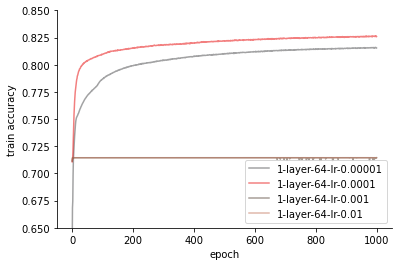

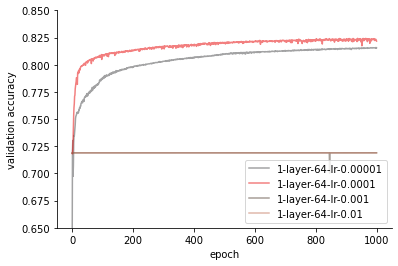

In [40]:
plot_accuracies(hist0, colors=['#464749','#e60000' ,'#4d3c2f', '#c07156', '#806b59', '#b9b2a3'] , alpha=.5, lower_ylim=.65, upper_ylim=.85)

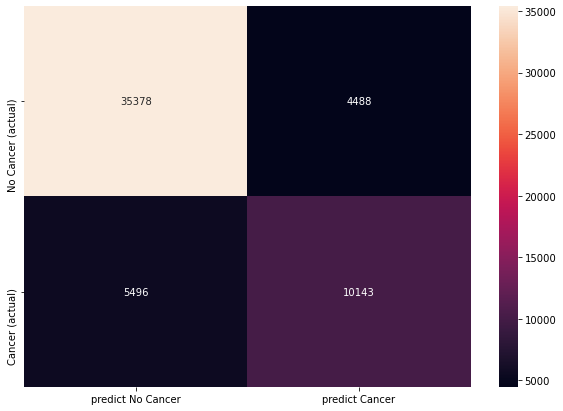

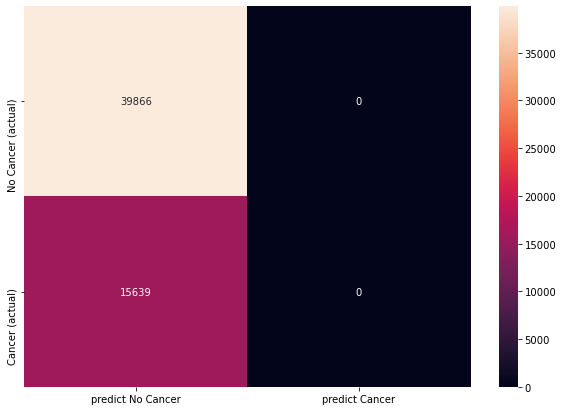

In [11]:
# plot confuction matrix
plt=conf_matrix(model2, x_test, y_test)
plt.show()

# plot confuction matrix
plt=conf_matrix(model3, x_test, y_test)
plt.show()

## Learnings
* Only two learning rates are able to improve above the base line
* Learning rates higher than 0.001 are not able to improve
    * Reason for this could be the used stochastic gradient descent optimizer, for further models we will switch to adam optimizer, which is bases on stochastic gradient descent
* Training accuracy is not able to reach high enough levels, the model might be still too simplistic

## Hidden nodes and adam optimizer

Experiment with models with one hidden layer but more hidden nodes.

All models are tested with the best learning rate from the previous experiment (0.0001) but also with a higher learning rate to check if bigger models manage to learn with a higher learning (0.001) rate.

* 128 Nodes
* 256 Nodes
* 512 Nodes
* 1024 Nodes
* 2048 Nodes
* 4096 Nodes

In [13]:
# lower the number of epochs
epochs = 500

histories = []

name="1-layer-128-lr-0.0001"
print(name)
model01 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model01.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.0001), metrics=["accuracy"])
histories.append(model01.fit(x_train, y_train, batch_size=batch_size,
                                   epochs=epochs, validation_data=(x_val,y_val),
                                   verbose=2))


name="1-layer-256-lr-0.0001"
print(name)
model02 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model02.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.0001), metrics=["accuracy"])
histories.append(model02.fit(x_train, y_train, batch_size=batch_size, 
                                   epochs=epochs, validation_data=(x_val,y_val),
                                   verbose=2))

name="1-layer-512-lr-0.0001"
print(name)
model03 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model03.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.0001), metrics=["accuracy"])
histories.append(model03.fit(x_train, y_train, batch_size=batch_size, 
                                   epochs=epochs, validation_data=(x_val,y_val),
                                   verbose=2))

name="1-layer-1024-lr-0.0001"
print(name)
model04 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(1024, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model04.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.0001), metrics=["accuracy"])
histories.append(model04.fit(x_train, y_train, batch_size=batch_size, 
                                   epochs=epochs, validation_data=(x_val,y_val),
                                   verbose=2))

name="1-layer-2048"
print(name)
model05 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(2048, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model05.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.0001), metrics=["accuracy"])
histories.append(model05.fit(x_train, y_train, batch_size=batch_size, 
                                   epochs=epochs, validation_data=(x_val,y_val),
                                   verbose=2))

name="1-layer-4096-lr-0.0001"
print(name)
model06 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model06.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.0001), metrics=["accuracy"])
histories.append(model06.fit(x_train, y_train, batch_size=batch_size, 
                                   epochs=epochs, validation_data=(x_val,y_val),
                                   verbose=2))
hist1 = histories

1-layer-128
Epoch 1/500
163/163 - 1s - loss: 22.7044 - accuracy: 0.6676 - val_loss: 5.7862 - val_accuracy: 0.7397
Epoch 2/500
163/163 - 1s - loss: 6.3587 - accuracy: 0.7170 - val_loss: 4.9468 - val_accuracy: 0.7583
Epoch 3/500
163/163 - 1s - loss: 6.3605 - accuracy: 0.7252 - val_loss: 4.3665 - val_accuracy: 0.7579
Epoch 4/500
163/163 - 1s - loss: 8.4895 - accuracy: 0.7035 - val_loss: 7.2913 - val_accuracy: 0.7682
Epoch 5/500
163/163 - 1s - loss: 7.1631 - accuracy: 0.7272 - val_loss: 4.8844 - val_accuracy: 0.7801
Epoch 6/500
163/163 - 1s - loss: 6.8375 - accuracy: 0.7192 - val_loss: 7.0245 - val_accuracy: 0.7654
Epoch 7/500
163/163 - 1s - loss: 6.5219 - accuracy: 0.7306 - val_loss: 4.7877 - val_accuracy: 0.7773
Epoch 8/500
163/163 - 1s - loss: 4.2823 - accuracy: 0.7477 - val_loss: 3.5024 - val_accuracy: 0.7256
Epoch 9/500
163/163 - 1s - loss: 6.5112 - accuracy: 0.7083 - val_loss: 6.5790 - val_accuracy: 0.7632
Epoch 10/500
163/163 - 1s - loss: 6.0349 - accuracy: 0.7170 - val_loss: 7.8093

Epoch 82/500
163/163 - 1s - loss: 2.0978 - accuracy: 0.7483 - val_loss: 1.3300 - val_accuracy: 0.7804
Epoch 83/500
163/163 - 1s - loss: 3.1885 - accuracy: 0.7254 - val_loss: 2.7390 - val_accuracy: 0.7578
Epoch 84/500
163/163 - 1s - loss: 3.0875 - accuracy: 0.7322 - val_loss: 1.8934 - val_accuracy: 0.7450
Epoch 85/500
163/163 - 1s - loss: 1.8147 - accuracy: 0.7558 - val_loss: 1.2415 - val_accuracy: 0.7738
Epoch 86/500
163/163 - 1s - loss: 1.9790 - accuracy: 0.7421 - val_loss: 6.5895 - val_accuracy: 0.3715
Epoch 87/500
163/163 - 1s - loss: 2.6526 - accuracy: 0.7346 - val_loss: 2.6431 - val_accuracy: 0.7584
Epoch 88/500
163/163 - 1s - loss: 1.9682 - accuracy: 0.7473 - val_loss: 1.3820 - val_accuracy: 0.7874
Epoch 89/500
163/163 - 1s - loss: 2.8990 - accuracy: 0.7362 - val_loss: 1.3375 - val_accuracy: 0.7807
Epoch 90/500
163/163 - 1s - loss: 2.4243 - accuracy: 0.7404 - val_loss: 1.7386 - val_accuracy: 0.7834
Epoch 91/500
163/163 - 1s - loss: 3.1171 - accuracy: 0.7267 - val_loss: 1.3298 - v

Epoch 162/500
163/163 - 1s - loss: 1.4394 - accuracy: 0.7472 - val_loss: 0.7646 - val_accuracy: 0.7638
Epoch 163/500
163/163 - 1s - loss: 1.3436 - accuracy: 0.7463 - val_loss: 2.9652 - val_accuracy: 0.7255
Epoch 164/500
163/163 - 1s - loss: 1.7766 - accuracy: 0.7400 - val_loss: 0.9349 - val_accuracy: 0.8040
Epoch 165/500
163/163 - 1s - loss: 1.2153 - accuracy: 0.7565 - val_loss: 1.0133 - val_accuracy: 0.7756
Epoch 166/500
163/163 - 1s - loss: 1.4381 - accuracy: 0.7423 - val_loss: 0.7000 - val_accuracy: 0.7824
Epoch 167/500
163/163 - 1s - loss: 1.3386 - accuracy: 0.7510 - val_loss: 0.8154 - val_accuracy: 0.7832
Epoch 168/500
163/163 - 1s - loss: 1.1295 - accuracy: 0.7587 - val_loss: 1.2912 - val_accuracy: 0.7400
Epoch 169/500
163/163 - 1s - loss: 1.2977 - accuracy: 0.7508 - val_loss: 0.8010 - val_accuracy: 0.7542
Epoch 170/500
163/163 - 1s - loss: 1.4863 - accuracy: 0.7433 - val_loss: 2.8375 - val_accuracy: 0.7307
Epoch 171/500
163/163 - 1s - loss: 1.4223 - accuracy: 0.7422 - val_loss: 

Epoch 242/500
163/163 - 1s - loss: 0.5323 - accuracy: 0.7886 - val_loss: 0.4726 - val_accuracy: 0.7995
Epoch 243/500
163/163 - 1s - loss: 0.5417 - accuracy: 0.7844 - val_loss: 0.9414 - val_accuracy: 0.5899
Epoch 244/500
163/163 - 1s - loss: 0.6813 - accuracy: 0.7674 - val_loss: 0.4999 - val_accuracy: 0.8011
Epoch 245/500
163/163 - 1s - loss: 0.5334 - accuracy: 0.7877 - val_loss: 0.5561 - val_accuracy: 0.7703
Epoch 246/500
163/163 - 1s - loss: 0.5163 - accuracy: 0.7897 - val_loss: 0.4992 - val_accuracy: 0.7816
Epoch 247/500
163/163 - 1s - loss: 0.6886 - accuracy: 0.7778 - val_loss: 0.6278 - val_accuracy: 0.7236
Epoch 248/500
163/163 - 1s - loss: 0.5001 - accuracy: 0.7921 - val_loss: 0.5019 - val_accuracy: 0.8041
Epoch 249/500
163/163 - 1s - loss: 0.7474 - accuracy: 0.7678 - val_loss: 0.4636 - val_accuracy: 0.8000
Epoch 250/500
163/163 - 1s - loss: 0.4766 - accuracy: 0.7980 - val_loss: 0.4689 - val_accuracy: 0.8040
Epoch 251/500
163/163 - 1s - loss: 0.6312 - accuracy: 0.7695 - val_loss: 

Epoch 322/500
163/163 - 1s - loss: 0.3994 - accuracy: 0.8236 - val_loss: 0.4067 - val_accuracy: 0.8200
Epoch 323/500
163/163 - 1s - loss: 0.3989 - accuracy: 0.8240 - val_loss: 0.4075 - val_accuracy: 0.8205
Epoch 324/500
163/163 - 1s - loss: 0.4000 - accuracy: 0.8239 - val_loss: 0.4066 - val_accuracy: 0.8199
Epoch 325/500
163/163 - 1s - loss: 0.4021 - accuracy: 0.8227 - val_loss: 0.4098 - val_accuracy: 0.8184
Epoch 326/500
163/163 - 1s - loss: 0.3990 - accuracy: 0.8241 - val_loss: 0.4053 - val_accuracy: 0.8205
Epoch 327/500
163/163 - 1s - loss: 0.3995 - accuracy: 0.8243 - val_loss: 0.4033 - val_accuracy: 0.8233
Epoch 328/500
163/163 - 1s - loss: 0.3993 - accuracy: 0.8245 - val_loss: 0.4416 - val_accuracy: 0.8011
Epoch 329/500
163/163 - 1s - loss: 0.3988 - accuracy: 0.8243 - val_loss: 0.4035 - val_accuracy: 0.8240
Epoch 330/500
163/163 - 1s - loss: 0.3945 - accuracy: 0.8266 - val_loss: 0.4009 - val_accuracy: 0.8248
Epoch 331/500
163/163 - 1s - loss: 0.3947 - accuracy: 0.8267 - val_loss: 

Epoch 402/500
163/163 - 1s - loss: 0.3803 - accuracy: 0.8342 - val_loss: 0.3992 - val_accuracy: 0.8249
Epoch 403/500
163/163 - 1s - loss: 0.3804 - accuracy: 0.8339 - val_loss: 0.4026 - val_accuracy: 0.8247
Epoch 404/500
163/163 - 1s - loss: 0.3817 - accuracy: 0.8328 - val_loss: 0.3970 - val_accuracy: 0.8259
Epoch 405/500
163/163 - 1s - loss: 0.3844 - accuracy: 0.8326 - val_loss: 0.3972 - val_accuracy: 0.8258
Epoch 406/500
163/163 - 1s - loss: 0.3794 - accuracy: 0.8342 - val_loss: 0.3980 - val_accuracy: 0.8252
Epoch 407/500
163/163 - 1s - loss: 0.3812 - accuracy: 0.8338 - val_loss: 0.4011 - val_accuracy: 0.8250
Epoch 408/500
163/163 - 1s - loss: 0.3793 - accuracy: 0.8346 - val_loss: 0.3991 - val_accuracy: 0.8261
Epoch 409/500
163/163 - 1s - loss: 0.3806 - accuracy: 0.8341 - val_loss: 0.4004 - val_accuracy: 0.8251
Epoch 410/500
163/163 - 1s - loss: 0.3809 - accuracy: 0.8340 - val_loss: 0.4013 - val_accuracy: 0.8250
Epoch 411/500
163/163 - 1s - loss: 0.3799 - accuracy: 0.8350 - val_loss: 

Epoch 482/500
163/163 - 1s - loss: 0.3679 - accuracy: 0.8405 - val_loss: 0.4045 - val_accuracy: 0.8211
Epoch 483/500
163/163 - 1s - loss: 0.3677 - accuracy: 0.8406 - val_loss: 0.4027 - val_accuracy: 0.8249
Epoch 484/500
163/163 - 1s - loss: 0.3707 - accuracy: 0.8391 - val_loss: 0.4010 - val_accuracy: 0.8243
Epoch 485/500
163/163 - 1s - loss: 0.3678 - accuracy: 0.8401 - val_loss: 0.4096 - val_accuracy: 0.8189
Epoch 486/500
163/163 - 1s - loss: 0.3680 - accuracy: 0.8403 - val_loss: 0.4043 - val_accuracy: 0.8226
Epoch 487/500
163/163 - 1s - loss: 0.3665 - accuracy: 0.8418 - val_loss: 0.4095 - val_accuracy: 0.8182
Epoch 488/500
163/163 - 1s - loss: 0.3704 - accuracy: 0.8397 - val_loss: 0.4041 - val_accuracy: 0.8221
Epoch 489/500
163/163 - 1s - loss: 0.3702 - accuracy: 0.8392 - val_loss: 0.4134 - val_accuracy: 0.8183
Epoch 490/500
163/163 - 1s - loss: 0.3725 - accuracy: 0.8384 - val_loss: 0.4032 - val_accuracy: 0.8227
Epoch 491/500
163/163 - 1s - loss: 0.3675 - accuracy: 0.8402 - val_loss: 

163/163 - 1s - loss: 1.8693 - accuracy: 0.7453 - val_loss: 1.5259 - val_accuracy: 0.6913
Epoch 63/500
163/163 - 1s - loss: 2.8397 - accuracy: 0.7222 - val_loss: 3.6664 - val_accuracy: 0.4875
Epoch 64/500
163/163 - 1s - loss: 1.8043 - accuracy: 0.7478 - val_loss: 7.8730 - val_accuracy: 0.3106
Epoch 65/500
163/163 - 1s - loss: 2.3311 - accuracy: 0.7373 - val_loss: 1.3926 - val_accuracy: 0.7625
Epoch 66/500
163/163 - 1s - loss: 2.1129 - accuracy: 0.7365 - val_loss: 4.3870 - val_accuracy: 0.7355
Epoch 67/500
163/163 - 1s - loss: 2.0942 - accuracy: 0.7479 - val_loss: 2.3514 - val_accuracy: 0.7547
Epoch 68/500
163/163 - 1s - loss: 1.9171 - accuracy: 0.7413 - val_loss: 4.1058 - val_accuracy: 0.4688
Epoch 69/500
163/163 - 1s - loss: 2.5188 - accuracy: 0.7314 - val_loss: 9.1260 - val_accuracy: 0.2993
Epoch 70/500
163/163 - 1s - loss: 2.5254 - accuracy: 0.7314 - val_loss: 2.2915 - val_accuracy: 0.7776
Epoch 71/500
163/163 - 1s - loss: 2.8251 - accuracy: 0.7217 - val_loss: 1.3112 - val_accuracy: 

163/163 - 1s - loss: 0.7671 - accuracy: 0.7729 - val_loss: 0.8459 - val_accuracy: 0.7720
Epoch 143/500
163/163 - 1s - loss: 0.7661 - accuracy: 0.7665 - val_loss: 0.8578 - val_accuracy: 0.6854
Epoch 144/500
163/163 - 1s - loss: 1.1608 - accuracy: 0.7429 - val_loss: 0.6536 - val_accuracy: 0.7894
Epoch 145/500
163/163 - 1s - loss: 0.6258 - accuracy: 0.7788 - val_loss: 1.0195 - val_accuracy: 0.6456
Epoch 146/500
163/163 - 1s - loss: 1.0226 - accuracy: 0.7491 - val_loss: 3.0854 - val_accuracy: 0.7210
Epoch 147/500
163/163 - 1s - loss: 0.8878 - accuracy: 0.7628 - val_loss: 0.5711 - val_accuracy: 0.7831
Epoch 148/500
163/163 - 1s - loss: 0.5917 - accuracy: 0.7790 - val_loss: 0.5877 - val_accuracy: 0.7921
Epoch 149/500
163/163 - 1s - loss: 0.7165 - accuracy: 0.7687 - val_loss: 0.6108 - val_accuracy: 0.7591
Epoch 150/500
163/163 - 1s - loss: 1.0862 - accuracy: 0.7403 - val_loss: 1.0488 - val_accuracy: 0.6996
Epoch 151/500
163/163 - 1s - loss: 0.6726 - accuracy: 0.7759 - val_loss: 0.7283 - val_a

Epoch 222/500
163/163 - 1s - loss: 0.4456 - accuracy: 0.8057 - val_loss: 0.4978 - val_accuracy: 0.7946
Epoch 223/500
163/163 - 1s - loss: 0.4458 - accuracy: 0.8056 - val_loss: 0.4322 - val_accuracy: 0.8089
Epoch 224/500
163/163 - 1s - loss: 0.4424 - accuracy: 0.8076 - val_loss: 0.4372 - val_accuracy: 0.8126
Epoch 225/500
163/163 - 1s - loss: 0.4417 - accuracy: 0.8074 - val_loss: 0.4296 - val_accuracy: 0.8121
Epoch 226/500
163/163 - 1s - loss: 0.4479 - accuracy: 0.8058 - val_loss: 0.4326 - val_accuracy: 0.8094
Epoch 227/500
163/163 - 1s - loss: 0.4415 - accuracy: 0.8074 - val_loss: 0.4446 - val_accuracy: 0.8084
Epoch 228/500
163/163 - 1s - loss: 0.5487 - accuracy: 0.7899 - val_loss: 0.4277 - val_accuracy: 0.8133
Epoch 229/500
163/163 - 1s - loss: 0.4282 - accuracy: 0.8125 - val_loss: 0.4384 - val_accuracy: 0.8106
Epoch 230/500
163/163 - 1s - loss: 0.4275 - accuracy: 0.8119 - val_loss: 0.4537 - val_accuracy: 0.8068
Epoch 231/500
163/163 - 1s - loss: 0.4446 - accuracy: 0.8066 - val_loss: 

Epoch 302/500
163/163 - 1s - loss: 0.3895 - accuracy: 0.8289 - val_loss: 0.4023 - val_accuracy: 0.8229
Epoch 303/500
163/163 - 1s - loss: 0.3926 - accuracy: 0.8271 - val_loss: 0.4114 - val_accuracy: 0.8171
Epoch 304/500
163/163 - 1s - loss: 0.3897 - accuracy: 0.8295 - val_loss: 0.4039 - val_accuracy: 0.8215
Epoch 305/500
163/163 - 1s - loss: 0.3904 - accuracy: 0.8286 - val_loss: 0.4034 - val_accuracy: 0.8215
Epoch 306/500
163/163 - 1s - loss: 0.3897 - accuracy: 0.8291 - val_loss: 0.4012 - val_accuracy: 0.8230
Epoch 307/500
163/163 - 1s - loss: 0.3874 - accuracy: 0.8307 - val_loss: 0.4014 - val_accuracy: 0.8235
Epoch 308/500
163/163 - 1s - loss: 0.3867 - accuracy: 0.8302 - val_loss: 0.4034 - val_accuracy: 0.8220
Epoch 309/500
163/163 - 1s - loss: 0.3876 - accuracy: 0.8301 - val_loss: 0.4054 - val_accuracy: 0.8228
Epoch 310/500
163/163 - 1s - loss: 0.3888 - accuracy: 0.8295 - val_loss: 0.4034 - val_accuracy: 0.8222
Epoch 311/500
163/163 - 1s - loss: 0.3887 - accuracy: 0.8294 - val_loss: 

Epoch 382/500
163/163 - 1s - loss: 0.3753 - accuracy: 0.8363 - val_loss: 0.4061 - val_accuracy: 0.8230
Epoch 383/500
163/163 - 1s - loss: 0.3784 - accuracy: 0.8348 - val_loss: 0.4127 - val_accuracy: 0.8210
Epoch 384/500
163/163 - 1s - loss: 0.3773 - accuracy: 0.8354 - val_loss: 0.4052 - val_accuracy: 0.8223
Epoch 385/500
163/163 - 1s - loss: 0.3777 - accuracy: 0.8359 - val_loss: 0.4014 - val_accuracy: 0.8244
Epoch 386/500
163/163 - 1s - loss: 0.3766 - accuracy: 0.8359 - val_loss: 0.4018 - val_accuracy: 0.8239
Epoch 387/500
163/163 - 1s - loss: 0.3768 - accuracy: 0.8364 - val_loss: 0.4034 - val_accuracy: 0.8230
Epoch 388/500
163/163 - 1s - loss: 0.3789 - accuracy: 0.8353 - val_loss: 0.4035 - val_accuracy: 0.8230
Epoch 389/500
163/163 - 1s - loss: 0.3737 - accuracy: 0.8371 - val_loss: 0.4052 - val_accuracy: 0.8231
Epoch 390/500
163/163 - 1s - loss: 0.3762 - accuracy: 0.8370 - val_loss: 0.4031 - val_accuracy: 0.8237
Epoch 391/500
163/163 - 1s - loss: 0.3791 - accuracy: 0.8349 - val_loss: 

Epoch 462/500
163/163 - 1s - loss: 0.3687 - accuracy: 0.8406 - val_loss: 0.4163 - val_accuracy: 0.8203
Epoch 463/500
163/163 - 1s - loss: 0.3674 - accuracy: 0.8414 - val_loss: 0.4062 - val_accuracy: 0.8233
Epoch 464/500
163/163 - 1s - loss: 0.3683 - accuracy: 0.8404 - val_loss: 0.4082 - val_accuracy: 0.8211
Epoch 465/500
163/163 - 1s - loss: 0.3711 - accuracy: 0.8392 - val_loss: 0.4052 - val_accuracy: 0.8232
Epoch 466/500
163/163 - 1s - loss: 0.3673 - accuracy: 0.8415 - val_loss: 0.4079 - val_accuracy: 0.8224
Epoch 467/500
163/163 - 1s - loss: 0.3668 - accuracy: 0.8414 - val_loss: 0.4106 - val_accuracy: 0.8215
Epoch 468/500
163/163 - 1s - loss: 0.3674 - accuracy: 0.8404 - val_loss: 0.4158 - val_accuracy: 0.8184
Epoch 469/500
163/163 - 1s - loss: 0.3681 - accuracy: 0.8406 - val_loss: 0.4122 - val_accuracy: 0.8196
Epoch 470/500
163/163 - 1s - loss: 0.3672 - accuracy: 0.8412 - val_loss: 0.4147 - val_accuracy: 0.8181
Epoch 471/500
163/163 - 1s - loss: 0.3690 - accuracy: 0.8399 - val_loss: 

Epoch 42/500
163/163 - 1s - loss: 4.8550 - accuracy: 0.7346 - val_loss: 3.7826 - val_accuracy: 0.7000
Epoch 43/500
163/163 - 1s - loss: 3.6896 - accuracy: 0.7465 - val_loss: 2.5141 - val_accuracy: 0.7156
Epoch 44/500
163/163 - 1s - loss: 6.5130 - accuracy: 0.6975 - val_loss: 5.8302 - val_accuracy: 0.5655
Epoch 45/500
163/163 - 1s - loss: 4.1544 - accuracy: 0.7451 - val_loss: 2.3615 - val_accuracy: 0.7905
Epoch 46/500
163/163 - 1s - loss: 4.3367 - accuracy: 0.7379 - val_loss: 1.9927 - val_accuracy: 0.7675
Epoch 47/500
163/163 - 1s - loss: 4.8028 - accuracy: 0.7234 - val_loss: 2.7153 - val_accuracy: 0.7879
Epoch 48/500
163/163 - 1s - loss: 5.7596 - accuracy: 0.7020 - val_loss: 8.2918 - val_accuracy: 0.7445
Epoch 49/500
163/163 - 1s - loss: 3.0557 - accuracy: 0.7578 - val_loss: 2.0750 - val_accuracy: 0.7231
Epoch 50/500
163/163 - 1s - loss: 5.2868 - accuracy: 0.7131 - val_loss: 2.3807 - val_accuracy: 0.7354
Epoch 51/500
163/163 - 1s - loss: 3.9824 - accuracy: 0.7333 - val_loss: 2.6570 - v

163/163 - 1s - loss: 1.0749 - accuracy: 0.7567 - val_loss: 0.7385 - val_accuracy: 0.7725
Epoch 123/500
163/163 - 1s - loss: 1.1441 - accuracy: 0.7566 - val_loss: 0.6744 - val_accuracy: 0.7806
Epoch 124/500
163/163 - 1s - loss: 1.0454 - accuracy: 0.7512 - val_loss: 0.9546 - val_accuracy: 0.7955
Epoch 125/500
163/163 - 1s - loss: 1.5122 - accuracy: 0.7321 - val_loss: 0.8072 - val_accuracy: 0.8005
Epoch 126/500
163/163 - 1s - loss: 0.7375 - accuracy: 0.7766 - val_loss: 0.8365 - val_accuracy: 0.7248
Epoch 127/500
163/163 - 1s - loss: 1.1566 - accuracy: 0.7467 - val_loss: 2.7293 - val_accuracy: 0.7414
Epoch 128/500
163/163 - 1s - loss: 1.2224 - accuracy: 0.7503 - val_loss: 0.6600 - val_accuracy: 0.7852
Epoch 129/500
163/163 - 1s - loss: 0.7211 - accuracy: 0.7711 - val_loss: 0.6324 - val_accuracy: 0.7892
Epoch 130/500
163/163 - 1s - loss: 1.0412 - accuracy: 0.7554 - val_loss: 0.7449 - val_accuracy: 0.7513
Epoch 131/500
163/163 - 1s - loss: 1.3052 - accuracy: 0.7378 - val_loss: 1.7664 - val_a

Epoch 202/500
163/163 - 1s - loss: 0.4081 - accuracy: 0.8194 - val_loss: 0.4181 - val_accuracy: 0.8167
Epoch 203/500
163/163 - 1s - loss: 0.4092 - accuracy: 0.8193 - val_loss: 0.4361 - val_accuracy: 0.8078
Epoch 204/500
163/163 - 1s - loss: 0.5405 - accuracy: 0.7871 - val_loss: 0.4437 - val_accuracy: 0.7998
Epoch 205/500
163/163 - 1s - loss: 0.4079 - accuracy: 0.8207 - val_loss: 0.4392 - val_accuracy: 0.8021
Epoch 206/500
163/163 - 1s - loss: 0.4043 - accuracy: 0.8213 - val_loss: 0.4107 - val_accuracy: 0.8203
Epoch 207/500
163/163 - 1s - loss: 0.4002 - accuracy: 0.8230 - val_loss: 0.4088 - val_accuracy: 0.8203
Epoch 208/500
163/163 - 1s - loss: 0.4012 - accuracy: 0.8226 - val_loss: 0.4058 - val_accuracy: 0.8214
Epoch 209/500
163/163 - 1s - loss: 0.3975 - accuracy: 0.8240 - val_loss: 0.4095 - val_accuracy: 0.8192
Epoch 210/500
163/163 - 1s - loss: 0.4038 - accuracy: 0.8226 - val_loss: 0.4074 - val_accuracy: 0.8203
Epoch 211/500
163/163 - 1s - loss: 0.4127 - accuracy: 0.8175 - val_loss: 

Epoch 282/500
163/163 - 1s - loss: 0.3877 - accuracy: 0.8313 - val_loss: 0.4022 - val_accuracy: 0.8231
Epoch 283/500
163/163 - 1s - loss: 0.3841 - accuracy: 0.8314 - val_loss: 0.4004 - val_accuracy: 0.8251
Epoch 284/500
163/163 - 1s - loss: 0.3855 - accuracy: 0.8310 - val_loss: 0.3995 - val_accuracy: 0.8242
Epoch 285/500
163/163 - 1s - loss: 0.3843 - accuracy: 0.8319 - val_loss: 0.3994 - val_accuracy: 0.8256
Epoch 286/500
163/163 - 1s - loss: 0.3842 - accuracy: 0.8320 - val_loss: 0.3969 - val_accuracy: 0.8263
Epoch 287/500
163/163 - 1s - loss: 0.3817 - accuracy: 0.8332 - val_loss: 0.3993 - val_accuracy: 0.8238
Epoch 288/500
163/163 - 1s - loss: 0.3841 - accuracy: 0.8323 - val_loss: 0.4006 - val_accuracy: 0.8251
Epoch 289/500
163/163 - 1s - loss: 0.3845 - accuracy: 0.8321 - val_loss: 0.4090 - val_accuracy: 0.8233
Epoch 290/500
163/163 - 1s - loss: 0.3856 - accuracy: 0.8320 - val_loss: 0.4072 - val_accuracy: 0.8221
Epoch 291/500
163/163 - 1s - loss: 0.3862 - accuracy: 0.8317 - val_loss: 

Epoch 362/500
163/163 - 1s - loss: 0.3737 - accuracy: 0.8378 - val_loss: 0.4038 - val_accuracy: 0.8229
Epoch 363/500
163/163 - 1s - loss: 0.3739 - accuracy: 0.8382 - val_loss: 0.4068 - val_accuracy: 0.8221
Epoch 364/500
163/163 - 1s - loss: 0.3739 - accuracy: 0.8379 - val_loss: 0.4139 - val_accuracy: 0.8212
Epoch 365/500
163/163 - 1s - loss: 0.3735 - accuracy: 0.8386 - val_loss: 0.4070 - val_accuracy: 0.8216
Epoch 366/500
163/163 - 1s - loss: 0.3744 - accuracy: 0.8376 - val_loss: 0.4159 - val_accuracy: 0.8208
Epoch 367/500
163/163 - 1s - loss: 0.3719 - accuracy: 0.8389 - val_loss: 0.4041 - val_accuracy: 0.8239
Epoch 368/500
163/163 - 1s - loss: 0.3715 - accuracy: 0.8390 - val_loss: 0.4038 - val_accuracy: 0.8250
Epoch 369/500
163/163 - 1s - loss: 0.3721 - accuracy: 0.8393 - val_loss: 0.4061 - val_accuracy: 0.8221
Epoch 370/500
163/163 - 1s - loss: 0.3734 - accuracy: 0.8377 - val_loss: 0.4158 - val_accuracy: 0.8199
Epoch 371/500
163/163 - 1s - loss: 0.3699 - accuracy: 0.8399 - val_loss: 

Epoch 442/500
163/163 - 1s - loss: 0.3644 - accuracy: 0.8427 - val_loss: 0.4104 - val_accuracy: 0.8207
Epoch 443/500
163/163 - 1s - loss: 0.3617 - accuracy: 0.8440 - val_loss: 0.4109 - val_accuracy: 0.8213
Epoch 444/500
163/163 - 1s - loss: 0.3657 - accuracy: 0.8425 - val_loss: 0.4083 - val_accuracy: 0.8218
Epoch 445/500
163/163 - 1s - loss: 0.3684 - accuracy: 0.8409 - val_loss: 0.4081 - val_accuracy: 0.8224
Epoch 446/500
163/163 - 1s - loss: 0.3635 - accuracy: 0.8428 - val_loss: 0.4084 - val_accuracy: 0.8256
Epoch 447/500
163/163 - 1s - loss: 0.3641 - accuracy: 0.8428 - val_loss: 0.4142 - val_accuracy: 0.8187
Epoch 448/500
163/163 - 1s - loss: 0.3640 - accuracy: 0.8432 - val_loss: 0.4133 - val_accuracy: 0.8228
Epoch 449/500
163/163 - 1s - loss: 0.3644 - accuracy: 0.8430 - val_loss: 0.4078 - val_accuracy: 0.8242
Epoch 450/500
163/163 - 1s - loss: 0.3600 - accuracy: 0.8448 - val_loss: 0.4131 - val_accuracy: 0.8231
Epoch 451/500
163/163 - 1s - loss: 0.3656 - accuracy: 0.8430 - val_loss: 

Epoch 22/500
163/163 - 2s - loss: 10.2724 - accuracy: 0.7409 - val_loss: 20.2756 - val_accuracy: 0.7320
Epoch 23/500
163/163 - 2s - loss: 13.5378 - accuracy: 0.7034 - val_loss: 10.2650 - val_accuracy: 0.7759
Epoch 24/500
163/163 - 2s - loss: 8.8815 - accuracy: 0.7480 - val_loss: 3.8354 - val_accuracy: 0.8032
Epoch 25/500
163/163 - 2s - loss: 12.6331 - accuracy: 0.7042 - val_loss: 5.6011 - val_accuracy: 0.8056
Epoch 26/500
163/163 - 2s - loss: 8.2987 - accuracy: 0.7412 - val_loss: 5.0911 - val_accuracy: 0.7838
Epoch 27/500
163/163 - 2s - loss: 9.7142 - accuracy: 0.7235 - val_loss: 5.6845 - val_accuracy: 0.7739
Epoch 28/500
163/163 - 2s - loss: 9.1909 - accuracy: 0.7247 - val_loss: 5.5032 - val_accuracy: 0.7977
Epoch 29/500
163/163 - 2s - loss: 11.7568 - accuracy: 0.7180 - val_loss: 6.1203 - val_accuracy: 0.7955
Epoch 30/500
163/163 - 2s - loss: 8.5990 - accuracy: 0.7446 - val_loss: 37.5108 - val_accuracy: 0.2901
Epoch 31/500
163/163 - 2s - loss: 9.2279 - accuracy: 0.7320 - val_loss: 3.4

Epoch 103/500
163/163 - 2s - loss: 1.3147 - accuracy: 0.7551 - val_loss: 0.9681 - val_accuracy: 0.7834
Epoch 104/500
163/163 - 2s - loss: 1.4248 - accuracy: 0.7455 - val_loss: 0.9698 - val_accuracy: 0.7857
Epoch 105/500
163/163 - 2s - loss: 1.1303 - accuracy: 0.7629 - val_loss: 0.9842 - val_accuracy: 0.7796
Epoch 106/500
163/163 - 2s - loss: 1.8797 - accuracy: 0.7242 - val_loss: 0.7855 - val_accuracy: 0.7802
Epoch 107/500
163/163 - 2s - loss: 0.8779 - accuracy: 0.7674 - val_loss: 0.7539 - val_accuracy: 0.7816
Epoch 108/500
163/163 - 2s - loss: 1.0983 - accuracy: 0.7548 - val_loss: 0.7976 - val_accuracy: 0.7971
Epoch 109/500
163/163 - 2s - loss: 1.3642 - accuracy: 0.7490 - val_loss: 0.7503 - val_accuracy: 0.7928
Epoch 110/500
163/163 - 2s - loss: 0.9213 - accuracy: 0.7648 - val_loss: 0.7577 - val_accuracy: 0.7930
Epoch 111/500
163/163 - 2s - loss: 1.7961 - accuracy: 0.7213 - val_loss: 1.0423 - val_accuracy: 0.7976
Epoch 112/500
163/163 - 2s - loss: 1.1265 - accuracy: 0.7605 - val_loss: 

Epoch 183/500
163/163 - 2s - loss: 0.4326 - accuracy: 0.8086 - val_loss: 0.4187 - val_accuracy: 0.8143
Epoch 184/500
163/163 - 2s - loss: 0.4139 - accuracy: 0.8153 - val_loss: 0.4128 - val_accuracy: 0.8145
Epoch 185/500
163/163 - 2s - loss: 0.4046 - accuracy: 0.8202 - val_loss: 0.4386 - val_accuracy: 0.8028
Epoch 186/500
163/163 - 2s - loss: 0.4083 - accuracy: 0.8182 - val_loss: 0.4087 - val_accuracy: 0.8199
Epoch 187/500
163/163 - 2s - loss: 0.4084 - accuracy: 0.8198 - val_loss: 0.4705 - val_accuracy: 0.7952
Epoch 188/500
163/163 - 2s - loss: 0.4106 - accuracy: 0.8178 - val_loss: 0.4126 - val_accuracy: 0.8179
Epoch 189/500
163/163 - 2s - loss: 0.4028 - accuracy: 0.8223 - val_loss: 0.4098 - val_accuracy: 0.8200
Epoch 190/500
163/163 - 2s - loss: 0.4021 - accuracy: 0.8218 - val_loss: 0.4072 - val_accuracy: 0.8203
Epoch 191/500
163/163 - 2s - loss: 0.4032 - accuracy: 0.8214 - val_loss: 0.4118 - val_accuracy: 0.8187
Epoch 192/500
163/163 - 2s - loss: 0.4645 - accuracy: 0.8070 - val_loss: 

Epoch 263/500
163/163 - 2s - loss: 0.3959 - accuracy: 0.8243 - val_loss: 0.4054 - val_accuracy: 0.8193
Epoch 264/500
163/163 - 2s - loss: 0.3963 - accuracy: 0.8243 - val_loss: 0.4164 - val_accuracy: 0.8119
Epoch 265/500
163/163 - 2s - loss: 0.3962 - accuracy: 0.8248 - val_loss: 0.4054 - val_accuracy: 0.8214
Epoch 266/500
163/163 - 2s - loss: 0.3945 - accuracy: 0.8257 - val_loss: 0.4094 - val_accuracy: 0.8206
Epoch 267/500
163/163 - 2s - loss: 0.3912 - accuracy: 0.8282 - val_loss: 0.4032 - val_accuracy: 0.8224
Epoch 268/500
163/163 - 2s - loss: 0.3886 - accuracy: 0.8290 - val_loss: 0.4021 - val_accuracy: 0.8228
Epoch 269/500
163/163 - 2s - loss: 0.3883 - accuracy: 0.8291 - val_loss: 0.4040 - val_accuracy: 0.8227
Epoch 270/500
163/163 - 2s - loss: 0.3897 - accuracy: 0.8285 - val_loss: 0.4040 - val_accuracy: 0.8220
Epoch 271/500
163/163 - 2s - loss: 0.3883 - accuracy: 0.8297 - val_loss: 0.4041 - val_accuracy: 0.8208
Epoch 272/500
163/163 - 2s - loss: 0.3879 - accuracy: 0.8293 - val_loss: 

Epoch 343/500
163/163 - 2s - loss: 0.3762 - accuracy: 0.8361 - val_loss: 0.4062 - val_accuracy: 0.8210
Epoch 344/500
163/163 - 2s - loss: 0.3762 - accuracy: 0.8366 - val_loss: 0.4064 - val_accuracy: 0.8212
Epoch 345/500
163/163 - 2s - loss: 0.3776 - accuracy: 0.8350 - val_loss: 0.4400 - val_accuracy: 0.8086
Epoch 346/500
163/163 - 2s - loss: 0.3777 - accuracy: 0.8355 - val_loss: 0.4075 - val_accuracy: 0.8200
Epoch 347/500
163/163 - 2s - loss: 0.3741 - accuracy: 0.8371 - val_loss: 0.4107 - val_accuracy: 0.8179
Epoch 348/500
163/163 - 2s - loss: 0.3780 - accuracy: 0.8348 - val_loss: 0.4107 - val_accuracy: 0.8192
Epoch 349/500
163/163 - 2s - loss: 0.3774 - accuracy: 0.8356 - val_loss: 0.4069 - val_accuracy: 0.8217
Epoch 350/500
163/163 - 2s - loss: 0.3736 - accuracy: 0.8371 - val_loss: 0.4187 - val_accuracy: 0.8155
Epoch 351/500
163/163 - 2s - loss: 0.3752 - accuracy: 0.8360 - val_loss: 0.4090 - val_accuracy: 0.8207
Epoch 352/500
163/163 - 2s - loss: 0.3746 - accuracy: 0.8371 - val_loss: 

Epoch 423/500
163/163 - 2s - loss: 0.3681 - accuracy: 0.8410 - val_loss: 0.4157 - val_accuracy: 0.8211
Epoch 424/500
163/163 - 2s - loss: 0.3680 - accuracy: 0.8403 - val_loss: 0.4130 - val_accuracy: 0.8181
Epoch 425/500
163/163 - 2s - loss: 0.3674 - accuracy: 0.8411 - val_loss: 0.4239 - val_accuracy: 0.8156
Epoch 426/500
163/163 - 2s - loss: 0.3664 - accuracy: 0.8417 - val_loss: 0.4114 - val_accuracy: 0.8189
Epoch 427/500
163/163 - 2s - loss: 0.3673 - accuracy: 0.8404 - val_loss: 0.4187 - val_accuracy: 0.8167
Epoch 428/500
163/163 - 2s - loss: 0.3694 - accuracy: 0.8398 - val_loss: 0.4153 - val_accuracy: 0.8163
Epoch 429/500
163/163 - 2s - loss: 0.3657 - accuracy: 0.8415 - val_loss: 0.4131 - val_accuracy: 0.8199
Epoch 430/500
163/163 - 2s - loss: 0.3688 - accuracy: 0.8394 - val_loss: 0.4118 - val_accuracy: 0.8214
Epoch 431/500
163/163 - 2s - loss: 0.3674 - accuracy: 0.8403 - val_loss: 0.4264 - val_accuracy: 0.8086
Epoch 432/500
163/163 - 2s - loss: 0.3692 - accuracy: 0.8395 - val_loss: 

Epoch 3/500
163/163 - 2s - loss: 22.6479 - accuracy: 0.7208 - val_loss: 9.9011 - val_accuracy: 0.7945
Epoch 4/500
163/163 - 2s - loss: 22.5437 - accuracy: 0.7093 - val_loss: 14.2833 - val_accuracy: 0.7296
Epoch 5/500
163/163 - 2s - loss: 19.7112 - accuracy: 0.7315 - val_loss: 48.9398 - val_accuracy: 0.7200
Epoch 6/500
163/163 - 2s - loss: 15.6713 - accuracy: 0.7405 - val_loss: 33.8598 - val_accuracy: 0.7219
Epoch 7/500
163/163 - 2s - loss: 24.4831 - accuracy: 0.6956 - val_loss: 30.7463 - val_accuracy: 0.7404
Epoch 8/500
163/163 - 2s - loss: 19.8709 - accuracy: 0.7089 - val_loss: 24.8108 - val_accuracy: 0.4424
Epoch 9/500
163/163 - 2s - loss: 14.3820 - accuracy: 0.7470 - val_loss: 8.2695 - val_accuracy: 0.7978
Epoch 10/500
163/163 - 2s - loss: 15.1219 - accuracy: 0.7361 - val_loss: 5.2498 - val_accuracy: 0.8054
Epoch 11/500
163/163 - 2s - loss: 17.1110 - accuracy: 0.7112 - val_loss: 9.9476 - val_accuracy: 0.7296
Epoch 12/500
163/163 - 2s - loss: 16.5487 - accuracy: 0.7188 - val_loss: 14

Epoch 83/500
163/163 - 2s - loss: 0.6899 - accuracy: 0.7696 - val_loss: 0.5445 - val_accuracy: 0.7739
Epoch 84/500
163/163 - 2s - loss: 0.5259 - accuracy: 0.7921 - val_loss: 0.5204 - val_accuracy: 0.7836
Epoch 85/500
163/163 - 2s - loss: 0.8627 - accuracy: 0.7471 - val_loss: 0.7537 - val_accuracy: 0.7844
Epoch 86/500
163/163 - 2s - loss: 0.6109 - accuracy: 0.7786 - val_loss: 0.4982 - val_accuracy: 0.7981
Epoch 87/500
163/163 - 2s - loss: 0.5720 - accuracy: 0.7855 - val_loss: 0.5308 - val_accuracy: 0.7992
Epoch 88/500
163/163 - 2s - loss: 0.6730 - accuracy: 0.7665 - val_loss: 0.9042 - val_accuracy: 0.7574
Epoch 89/500
163/163 - 2s - loss: 0.8252 - accuracy: 0.7545 - val_loss: 0.5026 - val_accuracy: 0.8002
Epoch 90/500
163/163 - 2s - loss: 0.6220 - accuracy: 0.7809 - val_loss: 0.5010 - val_accuracy: 0.7916
Epoch 91/500
163/163 - 2s - loss: 0.8107 - accuracy: 0.7545 - val_loss: 0.7749 - val_accuracy: 0.6929
Epoch 92/500
163/163 - 2s - loss: 0.4931 - accuracy: 0.7989 - val_loss: 0.5318 - v

Epoch 163/500
163/163 - 2s - loss: 0.3991 - accuracy: 0.8236 - val_loss: 0.4001 - val_accuracy: 0.8237
Epoch 164/500
163/163 - 2s - loss: 0.3961 - accuracy: 0.8254 - val_loss: 0.4001 - val_accuracy: 0.8225
Epoch 165/500
163/163 - 2s - loss: 0.4072 - accuracy: 0.8201 - val_loss: 0.4069 - val_accuracy: 0.8180
Epoch 166/500
163/163 - 2s - loss: 0.4027 - accuracy: 0.8207 - val_loss: 0.4023 - val_accuracy: 0.8213
Epoch 167/500
163/163 - 2s - loss: 0.3985 - accuracy: 0.8229 - val_loss: 0.4108 - val_accuracy: 0.8164
Epoch 168/500
163/163 - 2s - loss: 0.4017 - accuracy: 0.8216 - val_loss: 0.4206 - val_accuracy: 0.8157
Epoch 169/500
163/163 - 2s - loss: 0.4015 - accuracy: 0.8213 - val_loss: 0.4054 - val_accuracy: 0.8207
Epoch 170/500
163/163 - 2s - loss: 0.3991 - accuracy: 0.8224 - val_loss: 0.4041 - val_accuracy: 0.8202
Epoch 171/500
163/163 - 2s - loss: 0.3995 - accuracy: 0.8229 - val_loss: 0.4065 - val_accuracy: 0.8198
Epoch 172/500
163/163 - 2s - loss: 0.4001 - accuracy: 0.8228 - val_loss: 

Epoch 243/500
163/163 - 2s - loss: 0.3844 - accuracy: 0.8306 - val_loss: 0.4015 - val_accuracy: 0.8224
Epoch 244/500
163/163 - 2s - loss: 0.3832 - accuracy: 0.8312 - val_loss: 0.4189 - val_accuracy: 0.8155
Epoch 245/500
163/163 - 2s - loss: 0.3876 - accuracy: 0.8290 - val_loss: 0.4036 - val_accuracy: 0.8212
Epoch 246/500
163/163 - 2s - loss: 0.3843 - accuracy: 0.8307 - val_loss: 0.4014 - val_accuracy: 0.8224
Epoch 247/500
163/163 - 2s - loss: 0.3842 - accuracy: 0.8307 - val_loss: 0.4140 - val_accuracy: 0.8182
Epoch 248/500
163/163 - 2s - loss: 0.3850 - accuracy: 0.8308 - val_loss: 0.4031 - val_accuracy: 0.8220
Epoch 249/500
163/163 - 2s - loss: 0.3848 - accuracy: 0.8304 - val_loss: 0.4036 - val_accuracy: 0.8219
Epoch 250/500
163/163 - 2s - loss: 0.3875 - accuracy: 0.8299 - val_loss: 0.4004 - val_accuracy: 0.8228
Epoch 251/500
163/163 - 2s - loss: 0.3841 - accuracy: 0.8309 - val_loss: 0.4010 - val_accuracy: 0.8229
Epoch 252/500
163/163 - 2s - loss: 0.3841 - accuracy: 0.8309 - val_loss: 

Epoch 323/500
163/163 - 2s - loss: 0.3764 - accuracy: 0.8349 - val_loss: 0.4045 - val_accuracy: 0.8217
Epoch 324/500
163/163 - 2s - loss: 0.3760 - accuracy: 0.8356 - val_loss: 0.4055 - val_accuracy: 0.8220
Epoch 325/500
163/163 - 2s - loss: 0.3789 - accuracy: 0.8335 - val_loss: 0.4053 - val_accuracy: 0.8212
Epoch 326/500
163/163 - 2s - loss: 0.3747 - accuracy: 0.8358 - val_loss: 0.4073 - val_accuracy: 0.8218
Epoch 327/500
163/163 - 2s - loss: 0.3766 - accuracy: 0.8346 - val_loss: 0.4055 - val_accuracy: 0.8228
Epoch 328/500
163/163 - 2s - loss: 0.3782 - accuracy: 0.8348 - val_loss: 0.4056 - val_accuracy: 0.8216
Epoch 329/500
163/163 - 2s - loss: 0.3749 - accuracy: 0.8363 - val_loss: 0.4140 - val_accuracy: 0.8180
Epoch 330/500
163/163 - 2s - loss: 0.3763 - accuracy: 0.8350 - val_loss: 0.4036 - val_accuracy: 0.8224
Epoch 331/500
163/163 - 2s - loss: 0.3733 - accuracy: 0.8369 - val_loss: 0.4065 - val_accuracy: 0.8213
Epoch 332/500
163/163 - 2s - loss: 0.3734 - accuracy: 0.8364 - val_loss: 

Epoch 403/500
163/163 - 2s - loss: 0.3670 - accuracy: 0.8400 - val_loss: 0.4092 - val_accuracy: 0.8206
Epoch 404/500
163/163 - 2s - loss: 0.3707 - accuracy: 0.8382 - val_loss: 0.4113 - val_accuracy: 0.8187
Epoch 405/500
163/163 - 2s - loss: 0.3687 - accuracy: 0.8394 - val_loss: 0.4116 - val_accuracy: 0.8189
Epoch 406/500
163/163 - 2s - loss: 0.3703 - accuracy: 0.8388 - val_loss: 0.4080 - val_accuracy: 0.8202
Epoch 407/500
163/163 - 2s - loss: 0.3670 - accuracy: 0.8404 - val_loss: 0.4148 - val_accuracy: 0.8188
Epoch 408/500
163/163 - 2s - loss: 0.3694 - accuracy: 0.8394 - val_loss: 0.4117 - val_accuracy: 0.8200
Epoch 409/500
163/163 - 2s - loss: 0.3693 - accuracy: 0.8392 - val_loss: 0.4104 - val_accuracy: 0.8194
Epoch 410/500
163/163 - 2s - loss: 0.3680 - accuracy: 0.8396 - val_loss: 0.4090 - val_accuracy: 0.8218
Epoch 411/500
163/163 - 2s - loss: 0.3700 - accuracy: 0.8383 - val_loss: 0.4083 - val_accuracy: 0.8205
Epoch 412/500
163/163 - 2s - loss: 0.3679 - accuracy: 0.8394 - val_loss: 

Epoch 483/500
163/163 - 2s - loss: 0.3629 - accuracy: 0.8418 - val_loss: 0.4125 - val_accuracy: 0.8198
Epoch 484/500
163/163 - 2s - loss: 0.3630 - accuracy: 0.8420 - val_loss: 0.4349 - val_accuracy: 0.8142
Epoch 485/500
163/163 - 2s - loss: 0.3630 - accuracy: 0.8424 - val_loss: 0.4129 - val_accuracy: 0.8210
Epoch 486/500
163/163 - 2s - loss: 0.3641 - accuracy: 0.8416 - val_loss: 0.4207 - val_accuracy: 0.8142
Epoch 487/500
163/163 - 2s - loss: 0.3635 - accuracy: 0.8417 - val_loss: 0.4223 - val_accuracy: 0.8140
Epoch 488/500
163/163 - 2s - loss: 0.3637 - accuracy: 0.8415 - val_loss: 0.4159 - val_accuracy: 0.8196
Epoch 489/500
163/163 - 2s - loss: 0.3663 - accuracy: 0.8411 - val_loss: 0.4139 - val_accuracy: 0.8182
Epoch 490/500
163/163 - 2s - loss: 0.3650 - accuracy: 0.8420 - val_loss: 0.4119 - val_accuracy: 0.8212
Epoch 491/500
163/163 - 2s - loss: 0.3641 - accuracy: 0.8417 - val_loss: 0.4101 - val_accuracy: 0.8213
Epoch 492/500
163/163 - 2s - loss: 0.3621 - accuracy: 0.8429 - val_loss: 

Epoch 63/500
163/163 - 4s - loss: 0.8196 - accuracy: 0.7594 - val_loss: 1.1278 - val_accuracy: 0.7555
Epoch 64/500
163/163 - 4s - loss: 1.1642 - accuracy: 0.7338 - val_loss: 0.5843 - val_accuracy: 0.8005
Epoch 65/500
163/163 - 4s - loss: 0.7073 - accuracy: 0.7712 - val_loss: 0.6017 - val_accuracy: 0.8035
Epoch 66/500
163/163 - 4s - loss: 1.0038 - accuracy: 0.7438 - val_loss: 1.6262 - val_accuracy: 0.7496
Epoch 67/500
163/163 - 4s - loss: 0.6365 - accuracy: 0.7860 - val_loss: 0.5279 - val_accuracy: 0.7981
Epoch 68/500
163/163 - 4s - loss: 0.8653 - accuracy: 0.7558 - val_loss: 1.7623 - val_accuracy: 0.7399
Epoch 69/500
163/163 - 4s - loss: 0.9070 - accuracy: 0.7469 - val_loss: 0.6375 - val_accuracy: 0.7955
Epoch 70/500
163/163 - 4s - loss: 0.5847 - accuracy: 0.7802 - val_loss: 0.7106 - val_accuracy: 0.7849
Epoch 71/500
163/163 - 4s - loss: 0.5728 - accuracy: 0.7832 - val_loss: 1.4953 - val_accuracy: 0.7419
Epoch 72/500
163/163 - 4s - loss: 0.6525 - accuracy: 0.7839 - val_loss: 0.4890 - v

Epoch 143/500
163/163 - 4s - loss: 0.4023 - accuracy: 0.8216 - val_loss: 0.4046 - val_accuracy: 0.8218
Epoch 144/500
163/163 - 4s - loss: 0.3992 - accuracy: 0.8225 - val_loss: 0.4028 - val_accuracy: 0.8222
Epoch 145/500
163/163 - 4s - loss: 0.4109 - accuracy: 0.8187 - val_loss: 0.4032 - val_accuracy: 0.8215
Epoch 146/500
163/163 - 4s - loss: 0.4103 - accuracy: 0.8181 - val_loss: 0.4115 - val_accuracy: 0.8176
Epoch 147/500
163/163 - 4s - loss: 0.3995 - accuracy: 0.8224 - val_loss: 0.4162 - val_accuracy: 0.8153
Epoch 148/500
163/163 - 4s - loss: 0.3995 - accuracy: 0.8225 - val_loss: 0.4022 - val_accuracy: 0.8233
Epoch 149/500
163/163 - 4s - loss: 0.4044 - accuracy: 0.8207 - val_loss: 0.4018 - val_accuracy: 0.8227
Epoch 150/500
163/163 - 4s - loss: 0.3978 - accuracy: 0.8238 - val_loss: 0.4014 - val_accuracy: 0.8224
Epoch 151/500
163/163 - 4s - loss: 0.3966 - accuracy: 0.8236 - val_loss: 0.4018 - val_accuracy: 0.8230
Epoch 152/500
163/163 - 4s - loss: 0.3986 - accuracy: 0.8236 - val_loss: 

Epoch 223/500
163/163 - 4s - loss: 0.3840 - accuracy: 0.8329 - val_loss: 0.4044 - val_accuracy: 0.8236
Epoch 224/500
163/163 - 4s - loss: 0.3811 - accuracy: 0.8333 - val_loss: 0.4058 - val_accuracy: 0.8230
Epoch 225/500
163/163 - 4s - loss: 0.3818 - accuracy: 0.8337 - val_loss: 0.4014 - val_accuracy: 0.8257
Epoch 226/500
163/163 - 4s - loss: 0.3795 - accuracy: 0.8347 - val_loss: 0.4003 - val_accuracy: 0.8255
Epoch 227/500
163/163 - 4s - loss: 0.3803 - accuracy: 0.8344 - val_loss: 0.4042 - val_accuracy: 0.8227
Epoch 228/500
163/163 - 4s - loss: 0.3813 - accuracy: 0.8336 - val_loss: 0.4079 - val_accuracy: 0.8203
Epoch 229/500
163/163 - 4s - loss: 0.3805 - accuracy: 0.8339 - val_loss: 0.4036 - val_accuracy: 0.8257
Epoch 230/500
163/163 - 4s - loss: 0.3804 - accuracy: 0.8344 - val_loss: 0.4017 - val_accuracy: 0.8244
Epoch 231/500
163/163 - 4s - loss: 0.3802 - accuracy: 0.8347 - val_loss: 0.4021 - val_accuracy: 0.8253
Epoch 232/500
163/163 - 4s - loss: 0.3816 - accuracy: 0.8334 - val_loss: 

Epoch 303/500
163/163 - 4s - loss: 0.3690 - accuracy: 0.8398 - val_loss: 0.4014 - val_accuracy: 0.8240
Epoch 304/500
163/163 - 4s - loss: 0.3726 - accuracy: 0.8381 - val_loss: 0.4027 - val_accuracy: 0.8246
Epoch 305/500
163/163 - 4s - loss: 0.3683 - accuracy: 0.8406 - val_loss: 0.4089 - val_accuracy: 0.8222
Epoch 306/500
163/163 - 4s - loss: 0.3707 - accuracy: 0.8389 - val_loss: 0.4063 - val_accuracy: 0.8231
Epoch 307/500
163/163 - 4s - loss: 0.3699 - accuracy: 0.8393 - val_loss: 0.4036 - val_accuracy: 0.8238
Epoch 308/500
163/163 - 4s - loss: 0.3690 - accuracy: 0.8395 - val_loss: 0.4061 - val_accuracy: 0.8262
Epoch 309/500
163/163 - 4s - loss: 0.3711 - accuracy: 0.8391 - val_loss: 0.4041 - val_accuracy: 0.8256
Epoch 310/500
163/163 - 4s - loss: 0.3704 - accuracy: 0.8390 - val_loss: 0.4312 - val_accuracy: 0.8146
Epoch 311/500
163/163 - 4s - loss: 0.3701 - accuracy: 0.8391 - val_loss: 0.4013 - val_accuracy: 0.8262
Epoch 312/500
163/163 - 4s - loss: 0.3693 - accuracy: 0.8397 - val_loss: 

Epoch 383/500
163/163 - 4s - loss: 0.3605 - accuracy: 0.8438 - val_loss: 0.4138 - val_accuracy: 0.8229
Epoch 384/500
163/163 - 4s - loss: 0.3618 - accuracy: 0.8434 - val_loss: 0.4096 - val_accuracy: 0.8219
Epoch 385/500
163/163 - 4s - loss: 0.3616 - accuracy: 0.8431 - val_loss: 0.4315 - val_accuracy: 0.8077
Epoch 386/500
163/163 - 4s - loss: 0.3613 - accuracy: 0.8436 - val_loss: 0.4176 - val_accuracy: 0.8170
Epoch 387/500
163/163 - 4s - loss: 0.3614 - accuracy: 0.8435 - val_loss: 0.4384 - val_accuracy: 0.8177
Epoch 388/500
163/163 - 4s - loss: 0.3616 - accuracy: 0.8441 - val_loss: 0.4253 - val_accuracy: 0.8161
Epoch 389/500
163/163 - 4s - loss: 0.3618 - accuracy: 0.8435 - val_loss: 0.4168 - val_accuracy: 0.8234
Epoch 390/500
163/163 - 4s - loss: 0.3640 - accuracy: 0.8425 - val_loss: 0.4186 - val_accuracy: 0.8167
Epoch 391/500
163/163 - 4s - loss: 0.3605 - accuracy: 0.8446 - val_loss: 0.4147 - val_accuracy: 0.8171
Epoch 392/500
163/163 - 4s - loss: 0.3610 - accuracy: 0.8445 - val_loss: 

Epoch 463/500
163/163 - 4s - loss: 0.3551 - accuracy: 0.8477 - val_loss: 0.4234 - val_accuracy: 0.8134
Epoch 464/500
163/163 - 4s - loss: 0.3551 - accuracy: 0.8475 - val_loss: 0.4156 - val_accuracy: 0.8214
Epoch 465/500
163/163 - 4s - loss: 0.3569 - accuracy: 0.8464 - val_loss: 0.4413 - val_accuracy: 0.8041
Epoch 466/500
163/163 - 4s - loss: 0.3574 - accuracy: 0.8458 - val_loss: 0.4283 - val_accuracy: 0.8090
Epoch 467/500
163/163 - 4s - loss: 0.3539 - accuracy: 0.8473 - val_loss: 0.4130 - val_accuracy: 0.8239
Epoch 468/500
163/163 - 4s - loss: 0.3540 - accuracy: 0.8482 - val_loss: 0.4136 - val_accuracy: 0.8224
Epoch 469/500
163/163 - 4s - loss: 0.3550 - accuracy: 0.8470 - val_loss: 0.4122 - val_accuracy: 0.8217
Epoch 470/500
163/163 - 4s - loss: 0.3562 - accuracy: 0.8462 - val_loss: 0.4112 - val_accuracy: 0.8227
Epoch 471/500
163/163 - 4s - loss: 0.3559 - accuracy: 0.8469 - val_loss: 0.4169 - val_accuracy: 0.8169
Epoch 472/500
163/163 - 4s - loss: 0.3525 - accuracy: 0.8484 - val_loss: 

In [ ]:
def plot_accuracies(histories, colors, lower_ylim=.7, upper_ylim=.9, alpha=.6, **kwargs):
    
    i = 0
    colors=colors
    
    for history in histories:
        plt.plot(history.history['accuracy'], alpha=alpha, color=colors[i])
        i += 1
    plt.xlabel('epoch')
    plt.ylabel('train accuracy')
    plt.ylim([lower_ylim,upper_ylim])
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.legend([hist.model.name+'-lr-0.0001' for hist in histories], loc='lower right')

    plt.show()
    i = 0
    for history in histories:
        plt.plot(history.history['val_accuracy'], alpha=alpha, color=colors[i])
        i += 1
    plt.xlabel('epoch')
    plt.ylabel('validation accuracy')
    plt.ylim([lower_ylim,upper_ylim])
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.legend([hist.model.name for hist in histories], loc='lower right')

    plt.show()
    
def prec_rec_df(models):
    columns = ['model' ,'precision (cancer positive)', 'recall (cancer positive)']
    df = pandas.DataFrame(columns = columns)
    for model in models:
        matrix = sklearn.metrics.confusion_matrix(y_test, [1 * (x[0]>=0.5) for x in model.predict(x_test)])
        precision = matrix[1][1]/(matrix[1][1]+matrix[0][1])
        recall = matrix[1][1]/(matrix[1][1]+matrix[1][0])


        df = df.append(pandas.DataFrame([[model.name+'-lr-0.0001',
                                      precision,
                                      recall]], 
                            columns = columns))
    df = df.set_index('model')

    df = df.style.format({
        'precision (cancer positive)': '{:,.2%}'.format,
        'recall (cancer positive)': '{:,.2%}'.format})

In [14]:
acc_df(hist1)

,loss,accuracy,val_loss,val_accuracy
model size,,,,
1-layer-128,0.38,83.26%,0.40,82.77%
1-layer-256,0.38,83.34%,0.40,82.52%
1-layer-512,0.37,83.79%,0.40,82.72%
1-layer-1024,0.39,82.78%,0.40,82.57%
1-layer-2048,0.40,82.49%,0.40,82.42%
1-layer-4096,0.39,83.17%,0.40,82.71%


In [15]:
models = [model01, model02, model03, model04, model05, model06] 
prec_rec_df(models)

,precision (cancer positive),recall (cancer positive)
model,,
1-layer-128,73.75%,57.54%
1-layer-256,65.53%,68.54%
1-layer-512,68.91%,63.17%
1-layer-1024,67.04%,65.75%
1-layer-2048,68.65%,64.77%
1-layer-4096,71.74%,58.66%


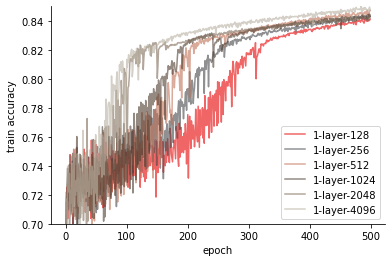

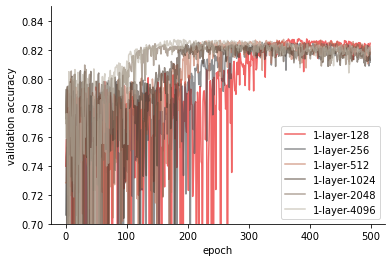

In [62]:
plot_accuracies(hist1, colors=['#e60000', '#464749' , '#c07156' , '#4d3c2f', '#806b59', '#b9b2a3'],
                lower_ylim=.7, upper_ylim=.85)

In [17]:
# lower the number of epochs
epochs = 500

histories = []

name="1-layer-128-lr-0.001"
print(name)
model001 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model001.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])
histories.append(model001.fit(x_train, y_train, batch_size=batch_size,
                                   epochs=epochs, validation_data=(x_val,y_val),
                                   verbose=2))


name="1-layer-256-lr-0.001"
print(name)
model002 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model002.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])
histories.append(model002.fit(x_train, y_train, batch_size=batch_size, 
                                   epochs=epochs, validation_data=(x_val,y_val),
                                   verbose=2))

name="1-layer-512-lr-0.001"
print(name)
model003 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model003.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])
histories.append(model003.fit(x_train, y_train, batch_size=batch_size, 
                                   epochs=epochs, validation_data=(x_val,y_val),
                                   verbose=2))

name="1-layer-1024-lr-0.001"
print(name)
model004 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(1024, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model004.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])
histories.append(model004.fit(x_train, y_train, batch_size=batch_size, 
                                   epochs=epochs, validation_data=(x_val,y_val),
                                   verbose=2))

name="1-layer-2048-lr-0.001"
print(name)
model005 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(2048, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model005.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])
histories.append(model005.fit(x_train, y_train, batch_size=batch_size, 
                                   epochs=epochs, validation_data=(x_val,y_val),
                                   verbose=2))

name="1-layer-4096-lr-0.001"
print(name)
model006 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model006.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])
histories.append(model006.fit(x_train, y_train, batch_size=batch_size, 
                                   epochs=epochs, validation_data=(x_val,y_val),
                                   verbose=2))
hist1_2 = histories

1-layer-128
Epoch 1/500
163/163 - 1s - loss: 138.4383 - accuracy: 0.6555 - val_loss: 17.0407 - val_accuracy: 0.7921
Epoch 2/500
163/163 - 1s - loss: 46.3548 - accuracy: 0.7335 - val_loss: 14.3095 - val_accuracy: 0.8008
Epoch 3/500
163/163 - 1s - loss: 31.0673 - accuracy: 0.7340 - val_loss: 10.7205 - val_accuracy: 0.7540
Epoch 4/500
163/163 - 1s - loss: 61.5932 - accuracy: 0.7189 - val_loss: 9.6745 - val_accuracy: 0.7893
Epoch 5/500
163/163 - 1s - loss: 23.9883 - accuracy: 0.7314 - val_loss: 39.5321 - val_accuracy: 0.7240
Epoch 6/500
163/163 - 1s - loss: 25.4286 - accuracy: 0.7155 - val_loss: 8.9619 - val_accuracy: 0.8040
Epoch 7/500
163/163 - 1s - loss: 35.7924 - accuracy: 0.7265 - val_loss: 7.0984 - val_accuracy: 0.7969
Epoch 8/500
163/163 - 1s - loss: 17.2138 - accuracy: 0.7164 - val_loss: 9.6546 - val_accuracy: 0.7660
Epoch 9/500
163/163 - 1s - loss: 16.2378 - accuracy: 0.7254 - val_loss: 15.2747 - val_accuracy: 0.6233
Epoch 10/500
163/163 - 1s - loss: 13.0913 - accuracy: 0.7379 - v

163/163 - 1s - loss: 0.4072 - accuracy: 0.8226 - val_loss: 0.4027 - val_accuracy: 0.8251
Epoch 82/500
163/163 - 1s - loss: 0.4088 - accuracy: 0.8230 - val_loss: 0.4079 - val_accuracy: 0.8227
Epoch 83/500
163/163 - 1s - loss: 0.3984 - accuracy: 0.8255 - val_loss: 0.3982 - val_accuracy: 0.8262
Epoch 84/500
163/163 - 1s - loss: 0.4061 - accuracy: 0.8233 - val_loss: 0.4025 - val_accuracy: 0.8250
Epoch 85/500
163/163 - 1s - loss: 0.4058 - accuracy: 0.8239 - val_loss: 0.3965 - val_accuracy: 0.8270
Epoch 86/500
163/163 - 1s - loss: 0.4021 - accuracy: 0.8240 - val_loss: 0.4273 - val_accuracy: 0.8234
Epoch 87/500
163/163 - 1s - loss: 0.4018 - accuracy: 0.8247 - val_loss: 0.3967 - val_accuracy: 0.8262
Epoch 88/500
163/163 - 1s - loss: 0.4044 - accuracy: 0.8229 - val_loss: 0.3980 - val_accuracy: 0.8244
Epoch 89/500
163/163 - 1s - loss: 0.4024 - accuracy: 0.8248 - val_loss: 0.4060 - val_accuracy: 0.8203
Epoch 90/500
163/163 - 1s - loss: 0.4053 - accuracy: 0.8231 - val_loss: 0.4074 - val_accuracy: 

Epoch 161/500
163/163 - 1s - loss: 0.4038 - accuracy: 0.8229 - val_loss: 0.4072 - val_accuracy: 0.8193
Epoch 162/500
163/163 - 1s - loss: 0.3969 - accuracy: 0.8255 - val_loss: 0.4044 - val_accuracy: 0.8209
Epoch 163/500
163/163 - 1s - loss: 0.3997 - accuracy: 0.8245 - val_loss: 0.4155 - val_accuracy: 0.8188
Epoch 164/500
163/163 - 1s - loss: 0.3978 - accuracy: 0.8253 - val_loss: 0.4120 - val_accuracy: 0.8197
Epoch 165/500
163/163 - 1s - loss: 0.4012 - accuracy: 0.8235 - val_loss: 0.4020 - val_accuracy: 0.8225
Epoch 166/500
163/163 - 1s - loss: 0.4027 - accuracy: 0.8237 - val_loss: 0.4054 - val_accuracy: 0.8202
Epoch 167/500
163/163 - 1s - loss: 0.3981 - accuracy: 0.8255 - val_loss: 0.4067 - val_accuracy: 0.8206
Epoch 168/500
163/163 - 1s - loss: 0.4000 - accuracy: 0.8242 - val_loss: 0.4114 - val_accuracy: 0.8218
Epoch 169/500
163/163 - 1s - loss: 0.4003 - accuracy: 0.8243 - val_loss: 0.4069 - val_accuracy: 0.8205
Epoch 170/500
163/163 - 1s - loss: 0.3988 - accuracy: 0.8247 - val_loss: 

Epoch 241/500
163/163 - 1s - loss: 0.4179 - accuracy: 0.8248 - val_loss: 0.5090 - val_accuracy: 0.7636
Epoch 242/500
163/163 - 1s - loss: 0.3986 - accuracy: 0.8251 - val_loss: 0.4145 - val_accuracy: 0.8233
Epoch 243/500
163/163 - 1s - loss: 0.3909 - accuracy: 0.8291 - val_loss: 0.4079 - val_accuracy: 0.8191
Epoch 244/500
163/163 - 1s - loss: 0.3944 - accuracy: 0.8283 - val_loss: 0.4524 - val_accuracy: 0.7957
Epoch 245/500
163/163 - 1s - loss: 0.3907 - accuracy: 0.8291 - val_loss: 0.4084 - val_accuracy: 0.8212
Epoch 246/500
163/163 - 1s - loss: 0.3907 - accuracy: 0.8288 - val_loss: 0.4031 - val_accuracy: 0.8225
Epoch 247/500
163/163 - 1s - loss: 0.3922 - accuracy: 0.8287 - val_loss: 0.4089 - val_accuracy: 0.8191
Epoch 248/500
163/163 - 1s - loss: 0.3935 - accuracy: 0.8284 - val_loss: 0.4021 - val_accuracy: 0.8226
Epoch 249/500
163/163 - 1s - loss: 0.3908 - accuracy: 0.8293 - val_loss: 0.4085 - val_accuracy: 0.8187
Epoch 250/500
163/163 - 1s - loss: 0.3928 - accuracy: 0.8289 - val_loss: 

Epoch 321/500
163/163 - 1s - loss: 0.3870 - accuracy: 0.8308 - val_loss: 0.4072 - val_accuracy: 0.8195
Epoch 322/500
163/163 - 1s - loss: 0.3852 - accuracy: 0.8321 - val_loss: 0.4047 - val_accuracy: 0.8217
Epoch 323/500
163/163 - 1s - loss: 0.3852 - accuracy: 0.8325 - val_loss: 0.4047 - val_accuracy: 0.8221
Epoch 324/500
163/163 - 1s - loss: 0.3983 - accuracy: 0.8272 - val_loss: 0.4041 - val_accuracy: 0.8221
Epoch 325/500
163/163 - 1s - loss: 0.3848 - accuracy: 0.8324 - val_loss: 0.4058 - val_accuracy: 0.8208
Epoch 326/500
163/163 - 1s - loss: 0.3833 - accuracy: 0.8331 - val_loss: 0.4083 - val_accuracy: 0.8199
Epoch 327/500
163/163 - 1s - loss: 0.3842 - accuracy: 0.8322 - val_loss: 0.4208 - val_accuracy: 0.8111
Epoch 328/500
163/163 - 1s - loss: 0.3867 - accuracy: 0.8320 - val_loss: 0.4100 - val_accuracy: 0.8198
Epoch 329/500
163/163 - 1s - loss: 0.3882 - accuracy: 0.8313 - val_loss: 0.4362 - val_accuracy: 0.8073
Epoch 330/500
163/163 - 1s - loss: 0.3864 - accuracy: 0.8325 - val_loss: 

Epoch 401/500
163/163 - 1s - loss: 0.3870 - accuracy: 0.8322 - val_loss: 0.4158 - val_accuracy: 0.8173
Epoch 402/500
163/163 - 1s - loss: 0.3811 - accuracy: 0.8341 - val_loss: 0.4142 - val_accuracy: 0.8178
Epoch 403/500
163/163 - 1s - loss: 0.3842 - accuracy: 0.8334 - val_loss: 0.4085 - val_accuracy: 0.8201
Epoch 404/500
163/163 - 1s - loss: 0.3841 - accuracy: 0.8329 - val_loss: 0.4050 - val_accuracy: 0.8234
Epoch 405/500
163/163 - 1s - loss: 0.3814 - accuracy: 0.8345 - val_loss: 0.4090 - val_accuracy: 0.8188
Epoch 406/500
163/163 - 1s - loss: 0.3786 - accuracy: 0.8352 - val_loss: 0.4175 - val_accuracy: 0.8188
Epoch 407/500
163/163 - 1s - loss: 0.3831 - accuracy: 0.8336 - val_loss: 0.4066 - val_accuracy: 0.8208
Epoch 408/500
163/163 - 1s - loss: 0.3865 - accuracy: 0.8323 - val_loss: 0.4193 - val_accuracy: 0.8134
Epoch 409/500
163/163 - 1s - loss: 0.3850 - accuracy: 0.8331 - val_loss: 0.4088 - val_accuracy: 0.8221
Epoch 410/500
163/163 - 1s - loss: 0.3849 - accuracy: 0.8328 - val_loss: 

Epoch 481/500
163/163 - 1s - loss: 0.3793 - accuracy: 0.8360 - val_loss: 0.4100 - val_accuracy: 0.8200
Epoch 482/500
163/163 - 1s - loss: 0.3788 - accuracy: 0.8362 - val_loss: 0.4139 - val_accuracy: 0.8164
Epoch 483/500
163/163 - 1s - loss: 0.3806 - accuracy: 0.8357 - val_loss: 0.4131 - val_accuracy: 0.8164
Epoch 484/500
163/163 - 1s - loss: 0.3758 - accuracy: 0.8369 - val_loss: 0.4187 - val_accuracy: 0.8149
Epoch 485/500
163/163 - 1s - loss: 0.3824 - accuracy: 0.8342 - val_loss: 0.4486 - val_accuracy: 0.8135
Epoch 486/500
163/163 - 1s - loss: 0.3800 - accuracy: 0.8357 - val_loss: 0.4116 - val_accuracy: 0.8183
Epoch 487/500
163/163 - 1s - loss: 0.3823 - accuracy: 0.8347 - val_loss: 0.4134 - val_accuracy: 0.8177
Epoch 488/500
163/163 - 1s - loss: 0.3812 - accuracy: 0.8355 - val_loss: 0.4048 - val_accuracy: 0.8221
Epoch 489/500
163/163 - 1s - loss: 0.3777 - accuracy: 0.8369 - val_loss: 0.4107 - val_accuracy: 0.8203
Epoch 490/500
163/163 - 1s - loss: 0.3758 - accuracy: 0.8370 - val_loss: 

163/163 - 1s - loss: 0.4173 - accuracy: 0.8125 - val_loss: 0.4094 - val_accuracy: 0.8151
Epoch 62/500
163/163 - 1s - loss: 0.4123 - accuracy: 0.8144 - val_loss: 0.4128 - val_accuracy: 0.8146
Epoch 63/500
163/163 - 1s - loss: 0.4124 - accuracy: 0.8141 - val_loss: 0.4441 - val_accuracy: 0.8022
Epoch 64/500
163/163 - 1s - loss: 0.4098 - accuracy: 0.8161 - val_loss: 0.4336 - val_accuracy: 0.8081
Epoch 65/500
163/163 - 1s - loss: 0.4129 - accuracy: 0.8140 - val_loss: 0.4084 - val_accuracy: 0.8163
Epoch 66/500
163/163 - 1s - loss: 0.4092 - accuracy: 0.8164 - val_loss: 0.4112 - val_accuracy: 0.8180
Epoch 67/500
163/163 - 1s - loss: 0.4101 - accuracy: 0.8163 - val_loss: 0.4127 - val_accuracy: 0.8178
Epoch 68/500
163/163 - 1s - loss: 0.5197 - accuracy: 0.8062 - val_loss: 0.4234 - val_accuracy: 0.8082
Epoch 69/500
163/163 - 1s - loss: 0.4219 - accuracy: 0.8077 - val_loss: 0.4180 - val_accuracy: 0.8106
Epoch 70/500
163/163 - 1s - loss: 0.4196 - accuracy: 0.8089 - val_loss: 0.4168 - val_accuracy: 

163/163 - 1s - loss: 0.4167 - accuracy: 0.8115 - val_loss: 0.4196 - val_accuracy: 0.8092
Epoch 142/500
163/163 - 1s - loss: 0.4165 - accuracy: 0.8120 - val_loss: 0.4210 - val_accuracy: 0.8094
Epoch 143/500
163/163 - 1s - loss: 0.4194 - accuracy: 0.8109 - val_loss: 0.4179 - val_accuracy: 0.8110
Epoch 144/500
163/163 - 1s - loss: 0.4166 - accuracy: 0.8119 - val_loss: 0.4176 - val_accuracy: 0.8109
Epoch 145/500
163/163 - 1s - loss: 0.4155 - accuracy: 0.8123 - val_loss: 0.4206 - val_accuracy: 0.8098
Epoch 146/500
163/163 - 1s - loss: 0.4158 - accuracy: 0.8120 - val_loss: 0.4243 - val_accuracy: 0.8091
Epoch 147/500
163/163 - 1s - loss: 0.4179 - accuracy: 0.8110 - val_loss: 0.4189 - val_accuracy: 0.8099
Epoch 148/500
163/163 - 1s - loss: 0.4162 - accuracy: 0.8119 - val_loss: 0.4209 - val_accuracy: 0.8106
Epoch 149/500
163/163 - 1s - loss: 0.4166 - accuracy: 0.8119 - val_loss: 0.4456 - val_accuracy: 0.8063
Epoch 150/500
163/163 - 1s - loss: 0.4181 - accuracy: 0.8113 - val_loss: 0.4180 - val_a

Epoch 221/500
163/163 - 1s - loss: 0.4165 - accuracy: 0.8128 - val_loss: 0.4195 - val_accuracy: 0.8100
Epoch 222/500
163/163 - 1s - loss: 0.4125 - accuracy: 0.8143 - val_loss: 0.4189 - val_accuracy: 0.8101
Epoch 223/500
163/163 - 1s - loss: 0.4123 - accuracy: 0.8138 - val_loss: 0.4186 - val_accuracy: 0.8102
Epoch 224/500
163/163 - 1s - loss: 0.4140 - accuracy: 0.8134 - val_loss: 0.4187 - val_accuracy: 0.8103
Epoch 225/500
163/163 - 1s - loss: 0.4132 - accuracy: 0.8137 - val_loss: 0.4188 - val_accuracy: 0.8098
Epoch 226/500
163/163 - 1s - loss: 0.4135 - accuracy: 0.8138 - val_loss: 0.4210 - val_accuracy: 0.8096
Epoch 227/500
163/163 - 1s - loss: 0.4148 - accuracy: 0.8131 - val_loss: 0.4456 - val_accuracy: 0.7973
Epoch 228/500
163/163 - 1s - loss: 0.4138 - accuracy: 0.8130 - val_loss: 0.4212 - val_accuracy: 0.8090
Epoch 229/500
163/163 - 1s - loss: 0.4157 - accuracy: 0.8130 - val_loss: 0.4210 - val_accuracy: 0.8091
Epoch 230/500
163/163 - 1s - loss: 0.4162 - accuracy: 0.8123 - val_loss: 

Epoch 301/500
163/163 - 1s - loss: 0.4117 - accuracy: 0.8146 - val_loss: 0.4192 - val_accuracy: 0.8095
Epoch 302/500
163/163 - 1s - loss: 0.4122 - accuracy: 0.8146 - val_loss: 0.4236 - val_accuracy: 0.8092
Epoch 303/500
163/163 - 1s - loss: 0.4119 - accuracy: 0.8143 - val_loss: 0.4198 - val_accuracy: 0.8094
Epoch 304/500
163/163 - 1s - loss: 0.4160 - accuracy: 0.8134 - val_loss: 0.4194 - val_accuracy: 0.8101
Epoch 305/500
163/163 - 1s - loss: 0.4114 - accuracy: 0.8149 - val_loss: 0.4194 - val_accuracy: 0.8097
Epoch 306/500
163/163 - 1s - loss: 0.4103 - accuracy: 0.8151 - val_loss: 0.4234 - val_accuracy: 0.8089
Epoch 307/500
163/163 - 1s - loss: 0.4110 - accuracy: 0.8144 - val_loss: 0.4297 - val_accuracy: 0.8097
Epoch 308/500
163/163 - 1s - loss: 0.4168 - accuracy: 0.8130 - val_loss: 0.4295 - val_accuracy: 0.8036
Epoch 309/500
163/163 - 1s - loss: 0.4126 - accuracy: 0.8144 - val_loss: 0.4200 - val_accuracy: 0.8091
Epoch 310/500
163/163 - 1s - loss: 0.4124 - accuracy: 0.8144 - val_loss: 

Epoch 381/500
163/163 - 1s - loss: 0.4122 - accuracy: 0.8151 - val_loss: 0.4217 - val_accuracy: 0.8086
Epoch 382/500
163/163 - 1s - loss: 0.4115 - accuracy: 0.8149 - val_loss: 0.4202 - val_accuracy: 0.8097
Epoch 383/500
163/163 - 1s - loss: 0.4120 - accuracy: 0.8145 - val_loss: 0.4213 - val_accuracy: 0.8090
Epoch 384/500
163/163 - 1s - loss: 0.4093 - accuracy: 0.8158 - val_loss: 0.4232 - val_accuracy: 0.8081
Epoch 385/500
163/163 - 1s - loss: 0.4135 - accuracy: 0.8143 - val_loss: 0.4275 - val_accuracy: 0.8074
Epoch 386/500
163/163 - 1s - loss: 0.4121 - accuracy: 0.8150 - val_loss: 0.4221 - val_accuracy: 0.8082
Epoch 387/500
163/163 - 1s - loss: 0.4133 - accuracy: 0.8142 - val_loss: 0.4196 - val_accuracy: 0.8096
Epoch 388/500
163/163 - 1s - loss: 0.4096 - accuracy: 0.8155 - val_loss: 0.4215 - val_accuracy: 0.8090
Epoch 389/500
163/163 - 1s - loss: 0.4125 - accuracy: 0.8145 - val_loss: 0.4278 - val_accuracy: 0.8096
Epoch 390/500
163/163 - 1s - loss: 0.4136 - accuracy: 0.8146 - val_loss: 

Epoch 461/500
163/163 - 1s - loss: 0.4097 - accuracy: 0.8163 - val_loss: 0.4267 - val_accuracy: 0.8097
Epoch 462/500
163/163 - 1s - loss: 0.4098 - accuracy: 0.8166 - val_loss: 0.4256 - val_accuracy: 0.8092
Epoch 463/500
163/163 - 1s - loss: 0.4097 - accuracy: 0.8156 - val_loss: 0.4227 - val_accuracy: 0.8095
Epoch 464/500
163/163 - 1s - loss: 0.4097 - accuracy: 0.8159 - val_loss: 0.4251 - val_accuracy: 0.8067
Epoch 465/500
163/163 - 1s - loss: 0.4126 - accuracy: 0.8158 - val_loss: 0.4252 - val_accuracy: 0.8070
Epoch 466/500
163/163 - 1s - loss: 0.4089 - accuracy: 0.8161 - val_loss: 0.4207 - val_accuracy: 0.8096
Epoch 467/500
163/163 - 1s - loss: 0.4095 - accuracy: 0.8158 - val_loss: 0.4238 - val_accuracy: 0.8087
Epoch 468/500
163/163 - 1s - loss: 0.4105 - accuracy: 0.8152 - val_loss: 0.4207 - val_accuracy: 0.8094
Epoch 469/500
163/163 - 1s - loss: 0.4128 - accuracy: 0.8153 - val_loss: 0.4268 - val_accuracy: 0.8054
Epoch 470/500
163/163 - 1s - loss: 0.4097 - accuracy: 0.8155 - val_loss: 

Epoch 41/500
163/163 - 1s - loss: 0.4076 - accuracy: 0.8218 - val_loss: 0.4086 - val_accuracy: 0.8184
Epoch 42/500
163/163 - 1s - loss: 0.4080 - accuracy: 0.8205 - val_loss: 0.3998 - val_accuracy: 0.8239
Epoch 43/500
163/163 - 1s - loss: 0.4035 - accuracy: 0.8226 - val_loss: 0.4018 - val_accuracy: 0.8235
Epoch 44/500
163/163 - 1s - loss: 0.4033 - accuracy: 0.8225 - val_loss: 0.4187 - val_accuracy: 0.8131
Epoch 45/500
163/163 - 1s - loss: 0.4053 - accuracy: 0.8221 - val_loss: 0.3990 - val_accuracy: 0.8249
Epoch 46/500
163/163 - 1s - loss: 0.4024 - accuracy: 0.8230 - val_loss: 0.4012 - val_accuracy: 0.8248
Epoch 47/500
163/163 - 1s - loss: 0.4070 - accuracy: 0.8207 - val_loss: 0.3989 - val_accuracy: 0.8244
Epoch 48/500
163/163 - 1s - loss: 0.4066 - accuracy: 0.8219 - val_loss: 0.4058 - val_accuracy: 0.8222
Epoch 49/500
163/163 - 1s - loss: 0.4038 - accuracy: 0.8232 - val_loss: 0.4407 - val_accuracy: 0.8131
Epoch 50/500
163/163 - 1s - loss: 0.4058 - accuracy: 0.8218 - val_loss: 0.4182 - v

163/163 - 1s - loss: 0.4041 - accuracy: 0.8220 - val_loss: 0.4053 - val_accuracy: 0.8212
Epoch 122/500
163/163 - 1s - loss: 0.4034 - accuracy: 0.8224 - val_loss: 0.4040 - val_accuracy: 0.8207
Epoch 123/500
163/163 - 1s - loss: 0.4785 - accuracy: 0.8180 - val_loss: 0.4092 - val_accuracy: 0.8185
Epoch 124/500
163/163 - 1s - loss: 0.4007 - accuracy: 0.8229 - val_loss: 0.4218 - val_accuracy: 0.8197
Epoch 125/500
163/163 - 1s - loss: 0.4043 - accuracy: 0.8222 - val_loss: 0.4108 - val_accuracy: 0.8188
Epoch 126/500
163/163 - 1s - loss: 0.4020 - accuracy: 0.8233 - val_loss: 0.4063 - val_accuracy: 0.8200
Epoch 127/500
163/163 - 1s - loss: 0.4017 - accuracy: 0.8229 - val_loss: 0.4112 - val_accuracy: 0.8186
Epoch 128/500
163/163 - 1s - loss: 0.4151 - accuracy: 0.8182 - val_loss: 0.4178 - val_accuracy: 0.8183
Epoch 129/500
163/163 - 1s - loss: 0.4016 - accuracy: 0.8226 - val_loss: 0.4122 - val_accuracy: 0.8178
Epoch 130/500
163/163 - 1s - loss: 0.3997 - accuracy: 0.8232 - val_loss: 0.4013 - val_a

Epoch 201/500
163/163 - 1s - loss: 0.3944 - accuracy: 0.8268 - val_loss: 0.4184 - val_accuracy: 0.8206
Epoch 202/500
163/163 - 1s - loss: 0.3982 - accuracy: 0.8262 - val_loss: 0.4032 - val_accuracy: 0.8203
Epoch 203/500
163/163 - 1s - loss: 0.3960 - accuracy: 0.8261 - val_loss: 0.4218 - val_accuracy: 0.8182
Epoch 204/500
163/163 - 1s - loss: 0.3955 - accuracy: 0.8269 - val_loss: 0.4078 - val_accuracy: 0.8225
Epoch 205/500
163/163 - 1s - loss: 0.3959 - accuracy: 0.8261 - val_loss: 0.4125 - val_accuracy: 0.8173
Epoch 206/500
163/163 - 1s - loss: 0.3939 - accuracy: 0.8273 - val_loss: 0.4068 - val_accuracy: 0.8195
Epoch 207/500
163/163 - 1s - loss: 0.3948 - accuracy: 0.8269 - val_loss: 0.4053 - val_accuracy: 0.8213
Epoch 208/500
163/163 - 1s - loss: 0.3928 - accuracy: 0.8278 - val_loss: 0.4070 - val_accuracy: 0.8203
Epoch 209/500
163/163 - 1s - loss: 0.3915 - accuracy: 0.8278 - val_loss: 0.4193 - val_accuracy: 0.8215
Epoch 210/500
163/163 - 1s - loss: 0.3949 - accuracy: 0.8266 - val_loss: 

Epoch 281/500
163/163 - 1s - loss: 0.3885 - accuracy: 0.8300 - val_loss: 0.4049 - val_accuracy: 0.8217
Epoch 282/500
163/163 - 1s - loss: 0.3914 - accuracy: 0.8287 - val_loss: 0.4164 - val_accuracy: 0.8179
Epoch 283/500
163/163 - 1s - loss: 0.3945 - accuracy: 0.8281 - val_loss: 0.4133 - val_accuracy: 0.8199
Epoch 284/500
163/163 - 1s - loss: 0.3879 - accuracy: 0.8295 - val_loss: 0.4245 - val_accuracy: 0.8082
Epoch 285/500
163/163 - 1s - loss: 0.3894 - accuracy: 0.8300 - val_loss: 0.4083 - val_accuracy: 0.8190
Epoch 286/500
163/163 - 1s - loss: 0.3894 - accuracy: 0.8299 - val_loss: 0.4202 - val_accuracy: 0.8185
Epoch 287/500
163/163 - 1s - loss: 0.3901 - accuracy: 0.8299 - val_loss: 0.4216 - val_accuracy: 0.8186
Epoch 288/500
163/163 - 1s - loss: 0.3887 - accuracy: 0.8306 - val_loss: 0.4186 - val_accuracy: 0.8206
Epoch 289/500
163/163 - 1s - loss: 0.3928 - accuracy: 0.8285 - val_loss: 0.4058 - val_accuracy: 0.8197
Epoch 290/500
163/163 - 1s - loss: 0.3889 - accuracy: 0.8304 - val_loss: 

Epoch 361/500
163/163 - 1s - loss: 0.3880 - accuracy: 0.8308 - val_loss: 0.4433 - val_accuracy: 0.7991
Epoch 362/500
163/163 - 1s - loss: 0.3864 - accuracy: 0.8319 - val_loss: 0.4126 - val_accuracy: 0.8168
Epoch 363/500
163/163 - 1s - loss: 0.3852 - accuracy: 0.8321 - val_loss: 0.4101 - val_accuracy: 0.8200
Epoch 364/500
163/163 - 1s - loss: 0.3858 - accuracy: 0.8316 - val_loss: 0.4203 - val_accuracy: 0.8118
Epoch 365/500
163/163 - 1s - loss: 0.3869 - accuracy: 0.8314 - val_loss: 0.4071 - val_accuracy: 0.8195
Epoch 366/500
163/163 - 1s - loss: 0.3839 - accuracy: 0.8328 - val_loss: 0.4133 - val_accuracy: 0.8200
Epoch 367/500
163/163 - 1s - loss: 0.3858 - accuracy: 0.8325 - val_loss: 0.4116 - val_accuracy: 0.8196
Epoch 368/500
163/163 - 1s - loss: 0.3835 - accuracy: 0.8318 - val_loss: 0.4147 - val_accuracy: 0.8154
Epoch 369/500
163/163 - 1s - loss: 0.3855 - accuracy: 0.8321 - val_loss: 0.4259 - val_accuracy: 0.8160
Epoch 370/500
163/163 - 1s - loss: 0.3829 - accuracy: 0.8331 - val_loss: 

Epoch 441/500
163/163 - 1s - loss: 0.3829 - accuracy: 0.8337 - val_loss: 0.4120 - val_accuracy: 0.8177
Epoch 442/500
163/163 - 1s - loss: 0.3815 - accuracy: 0.8334 - val_loss: 0.4110 - val_accuracy: 0.8175
Epoch 443/500
163/163 - 1s - loss: 0.3879 - accuracy: 0.8313 - val_loss: 0.4158 - val_accuracy: 0.8156
Epoch 444/500
163/163 - 1s - loss: 0.3813 - accuracy: 0.8338 - val_loss: 0.4105 - val_accuracy: 0.8195
Epoch 445/500
163/163 - 1s - loss: 0.3840 - accuracy: 0.8333 - val_loss: 0.4205 - val_accuracy: 0.8108
Epoch 446/500
163/163 - 1s - loss: 0.3800 - accuracy: 0.8345 - val_loss: 0.4181 - val_accuracy: 0.8135
Epoch 447/500
163/163 - 1s - loss: 0.3844 - accuracy: 0.8335 - val_loss: 0.4227 - val_accuracy: 0.8099
Epoch 448/500
163/163 - 1s - loss: 0.3819 - accuracy: 0.8338 - val_loss: 0.4188 - val_accuracy: 0.8127
Epoch 449/500
163/163 - 1s - loss: 0.3816 - accuracy: 0.8335 - val_loss: 0.4152 - val_accuracy: 0.8204
Epoch 450/500
163/163 - 1s - loss: 0.3802 - accuracy: 0.8344 - val_loss: 

Epoch 21/500
163/163 - 2s - loss: 0.8957 - accuracy: 0.7520 - val_loss: 0.5207 - val_accuracy: 0.7964
Epoch 22/500
163/163 - 2s - loss: 0.5237 - accuracy: 0.7844 - val_loss: 0.5512 - val_accuracy: 0.7779
Epoch 23/500
163/163 - 2s - loss: 0.5314 - accuracy: 0.7775 - val_loss: 0.4758 - val_accuracy: 0.7939
Epoch 24/500
163/163 - 2s - loss: 0.9583 - accuracy: 0.7325 - val_loss: 0.4829 - val_accuracy: 0.7978
Epoch 25/500
163/163 - 2s - loss: 0.4711 - accuracy: 0.7971 - val_loss: 0.4792 - val_accuracy: 0.7947
Epoch 26/500
163/163 - 2s - loss: 0.4532 - accuracy: 0.7998 - val_loss: 0.4518 - val_accuracy: 0.7964
Epoch 27/500
163/163 - 2s - loss: 0.4644 - accuracy: 0.7946 - val_loss: 0.7070 - val_accuracy: 0.7531
Epoch 28/500
163/163 - 2s - loss: 0.4490 - accuracy: 0.8007 - val_loss: 0.4370 - val_accuracy: 0.8077
Epoch 29/500
163/163 - 2s - loss: 0.4611 - accuracy: 0.7957 - val_loss: 0.4325 - val_accuracy: 0.8070
Epoch 30/500
163/163 - 2s - loss: 0.4507 - accuracy: 0.7998 - val_loss: 0.4305 - v

Epoch 102/500
163/163 - 2s - loss: 0.4056 - accuracy: 0.8218 - val_loss: 0.4151 - val_accuracy: 0.8173
Epoch 103/500
163/163 - 2s - loss: 0.4048 - accuracy: 0.8232 - val_loss: 0.4044 - val_accuracy: 0.8261
Epoch 104/500
163/163 - 2s - loss: 0.4138 - accuracy: 0.8172 - val_loss: 0.5331 - val_accuracy: 0.7629
Epoch 105/500
163/163 - 2s - loss: 0.4256 - accuracy: 0.8154 - val_loss: 0.4150 - val_accuracy: 0.8217
Epoch 106/500
163/163 - 2s - loss: 0.4157 - accuracy: 0.8199 - val_loss: 0.4123 - val_accuracy: 0.8207
Epoch 107/500
163/163 - 2s - loss: 0.4120 - accuracy: 0.8204 - val_loss: 0.4171 - val_accuracy: 0.8223
Epoch 108/500
163/163 - 2s - loss: 0.4106 - accuracy: 0.8212 - val_loss: 0.4127 - val_accuracy: 0.8206
Epoch 109/500
163/163 - 2s - loss: 0.4094 - accuracy: 0.8211 - val_loss: 0.4153 - val_accuracy: 0.8154
Epoch 110/500
163/163 - 2s - loss: 0.4171 - accuracy: 0.8169 - val_loss: 0.4111 - val_accuracy: 0.8185
Epoch 111/500
163/163 - 2s - loss: 0.4082 - accuracy: 0.8199 - val_loss: 

Epoch 182/500
163/163 - 2s - loss: 0.4006 - accuracy: 0.8216 - val_loss: 0.4072 - val_accuracy: 0.8177
Epoch 183/500
163/163 - 2s - loss: 0.4030 - accuracy: 0.8214 - val_loss: 0.4063 - val_accuracy: 0.8187
Epoch 184/500
163/163 - 2s - loss: 0.4012 - accuracy: 0.8217 - val_loss: 0.4067 - val_accuracy: 0.8184
Epoch 185/500
163/163 - 2s - loss: 0.3996 - accuracy: 0.8223 - val_loss: 0.4186 - val_accuracy: 0.8141
Epoch 186/500
163/163 - 2s - loss: 0.4018 - accuracy: 0.8217 - val_loss: 0.4182 - val_accuracy: 0.8158
Epoch 187/500
163/163 - 2s - loss: 0.4047 - accuracy: 0.8210 - val_loss: 0.4087 - val_accuracy: 0.8184
Epoch 188/500
163/163 - 2s - loss: 0.4023 - accuracy: 0.8213 - val_loss: 0.4071 - val_accuracy: 0.8164
Epoch 189/500
163/163 - 2s - loss: 0.4011 - accuracy: 0.8219 - val_loss: 0.4061 - val_accuracy: 0.8181
Epoch 190/500
163/163 - 2s - loss: 0.4009 - accuracy: 0.8214 - val_loss: 0.4065 - val_accuracy: 0.8179
Epoch 191/500
163/163 - 2s - loss: 0.4033 - accuracy: 0.8214 - val_loss: 

Epoch 262/500
163/163 - 2s - loss: 0.3989 - accuracy: 0.8235 - val_loss: 0.4140 - val_accuracy: 0.8161
Epoch 263/500
163/163 - 2s - loss: 0.3978 - accuracy: 0.8239 - val_loss: 0.4099 - val_accuracy: 0.8172
Epoch 264/500
163/163 - 2s - loss: 0.3965 - accuracy: 0.8240 - val_loss: 0.4388 - val_accuracy: 0.8016
Epoch 265/500
163/163 - 2s - loss: 0.3989 - accuracy: 0.8237 - val_loss: 0.4228 - val_accuracy: 0.8121
Epoch 266/500
163/163 - 2s - loss: 0.3970 - accuracy: 0.8237 - val_loss: 0.4110 - val_accuracy: 0.8152
Epoch 267/500
163/163 - 2s - loss: 0.3978 - accuracy: 0.8238 - val_loss: 0.4404 - val_accuracy: 0.8145
Epoch 268/500
163/163 - 2s - loss: 0.3989 - accuracy: 0.8236 - val_loss: 0.4279 - val_accuracy: 0.8110
Epoch 269/500
163/163 - 2s - loss: 0.3983 - accuracy: 0.8241 - val_loss: 0.4143 - val_accuracy: 0.8147
Epoch 270/500
163/163 - 2s - loss: 0.3968 - accuracy: 0.8237 - val_loss: 0.4085 - val_accuracy: 0.8171
Epoch 271/500
163/163 - 2s - loss: 0.3951 - accuracy: 0.8244 - val_loss: 

Epoch 342/500
163/163 - 2s - loss: 0.3943 - accuracy: 0.8264 - val_loss: 0.4577 - val_accuracy: 0.8010
Epoch 343/500
163/163 - 2s - loss: 0.3933 - accuracy: 0.8263 - val_loss: 0.4145 - val_accuracy: 0.8123
Epoch 344/500
163/163 - 2s - loss: 0.3992 - accuracy: 0.8244 - val_loss: 0.4456 - val_accuracy: 0.8071
Epoch 345/500
163/163 - 2s - loss: 0.3941 - accuracy: 0.8261 - val_loss: 0.4135 - val_accuracy: 0.8150
Epoch 346/500
163/163 - 2s - loss: 0.3957 - accuracy: 0.8254 - val_loss: 0.4090 - val_accuracy: 0.8164
Epoch 347/500
163/163 - 2s - loss: 0.3929 - accuracy: 0.8262 - val_loss: 0.4343 - val_accuracy: 0.8166
Epoch 348/500
163/163 - 2s - loss: 0.3931 - accuracy: 0.8262 - val_loss: 0.4094 - val_accuracy: 0.8159
Epoch 349/500
163/163 - 2s - loss: 0.3971 - accuracy: 0.8246 - val_loss: 0.4261 - val_accuracy: 0.8157
Epoch 350/500
163/163 - 2s - loss: 0.3983 - accuracy: 0.8243 - val_loss: 0.4160 - val_accuracy: 0.8152
Epoch 351/500
163/163 - 2s - loss: 0.3957 - accuracy: 0.8251 - val_loss: 

Epoch 422/500
163/163 - 2s - loss: 0.3899 - accuracy: 0.8281 - val_loss: 0.4167 - val_accuracy: 0.8109
Epoch 423/500
163/163 - 2s - loss: 0.3931 - accuracy: 0.8266 - val_loss: 0.4221 - val_accuracy: 0.8173
Epoch 424/500
163/163 - 2s - loss: 0.3931 - accuracy: 0.8273 - val_loss: 0.4180 - val_accuracy: 0.8163
Epoch 425/500
163/163 - 2s - loss: 0.3922 - accuracy: 0.8272 - val_loss: 0.4114 - val_accuracy: 0.8159
Epoch 426/500
163/163 - 2s - loss: 0.3944 - accuracy: 0.8272 - val_loss: 0.4387 - val_accuracy: 0.8140
Epoch 427/500
163/163 - 2s - loss: 0.3950 - accuracy: 0.8264 - val_loss: 0.4139 - val_accuracy: 0.8174
Epoch 428/500
163/163 - 2s - loss: 0.3910 - accuracy: 0.8273 - val_loss: 0.4133 - val_accuracy: 0.8147
Epoch 429/500
163/163 - 2s - loss: 0.3930 - accuracy: 0.8265 - val_loss: 0.4210 - val_accuracy: 0.8171
Epoch 430/500
163/163 - 2s - loss: 0.3928 - accuracy: 0.8267 - val_loss: 0.4268 - val_accuracy: 0.8145
Epoch 431/500
163/163 - 2s - loss: 0.3915 - accuracy: 0.8272 - val_loss: 

Epoch 2/500
163/163 - 2s - loss: 25.5133 - accuracy: 0.7220 - val_loss: 9.9252 - val_accuracy: 0.8014
Epoch 3/500
163/163 - 2s - loss: 20.5071 - accuracy: 0.7135 - val_loss: 11.4111 - val_accuracy: 0.7820
Epoch 4/500
163/163 - 2s - loss: 11.7113 - accuracy: 0.7430 - val_loss: 14.3341 - val_accuracy: 0.7451
Epoch 5/500
163/163 - 2s - loss: 9.4126 - accuracy: 0.7245 - val_loss: 3.3415 - val_accuracy: 0.7580
Epoch 6/500
163/163 - 2s - loss: 9.0203 - accuracy: 0.7270 - val_loss: 3.0827 - val_accuracy: 0.7754
Epoch 7/500
163/163 - 2s - loss: 4.7292 - accuracy: 0.7235 - val_loss: 1.3032 - val_accuracy: 0.8079
Epoch 8/500
163/163 - 2s - loss: 3.0955 - accuracy: 0.7097 - val_loss: 2.3650 - val_accuracy: 0.5695
Epoch 9/500
163/163 - 2s - loss: 2.9966 - accuracy: 0.7274 - val_loss: 1.0125 - val_accuracy: 0.8014
Epoch 10/500
163/163 - 2s - loss: 1.7796 - accuracy: 0.7459 - val_loss: 1.0338 - val_accuracy: 0.7846
Epoch 11/500
163/163 - 2s - loss: 1.3230 - accuracy: 0.7380 - val_loss: 1.5413 - val_

Epoch 83/500
163/163 - 2s - loss: 0.4072 - accuracy: 0.8225 - val_loss: 0.4160 - val_accuracy: 0.8206
Epoch 84/500
163/163 - 2s - loss: 0.4053 - accuracy: 0.8233 - val_loss: 0.4091 - val_accuracy: 0.8207
Epoch 85/500
163/163 - 2s - loss: 0.4044 - accuracy: 0.8244 - val_loss: 0.4455 - val_accuracy: 0.8057
Epoch 86/500
163/163 - 2s - loss: 0.4062 - accuracy: 0.8228 - val_loss: 0.4151 - val_accuracy: 0.8210
Epoch 87/500
163/163 - 2s - loss: 0.4045 - accuracy: 0.8239 - val_loss: 0.4116 - val_accuracy: 0.8206
Epoch 88/500
163/163 - 2s - loss: 0.4079 - accuracy: 0.8215 - val_loss: 0.4039 - val_accuracy: 0.8239
Epoch 89/500
163/163 - 2s - loss: 0.3995 - accuracy: 0.8249 - val_loss: 0.4002 - val_accuracy: 0.8241
Epoch 90/500
163/163 - 2s - loss: 0.4037 - accuracy: 0.8242 - val_loss: 0.4282 - val_accuracy: 0.8171
Epoch 91/500
163/163 - 2s - loss: 0.4042 - accuracy: 0.8228 - val_loss: 0.4439 - val_accuracy: 0.8112
Epoch 92/500
163/163 - 2s - loss: 0.4065 - accuracy: 0.8233 - val_loss: 0.4119 - v

Epoch 163/500
163/163 - 2s - loss: 0.4025 - accuracy: 0.8241 - val_loss: 0.4087 - val_accuracy: 0.8188
Epoch 164/500
163/163 - 2s - loss: 0.3983 - accuracy: 0.8257 - val_loss: 0.4036 - val_accuracy: 0.8217
Epoch 165/500
163/163 - 2s - loss: 0.3980 - accuracy: 0.8252 - val_loss: 0.4254 - val_accuracy: 0.8120
Epoch 166/500
163/163 - 2s - loss: 0.3944 - accuracy: 0.8273 - val_loss: 0.4069 - val_accuracy: 0.8178
Epoch 167/500
163/163 - 2s - loss: 0.3917 - accuracy: 0.8286 - val_loss: 0.4137 - val_accuracy: 0.8231
Epoch 168/500
163/163 - 2s - loss: 0.3931 - accuracy: 0.8281 - val_loss: 0.4500 - val_accuracy: 0.8054
Epoch 169/500
163/163 - 2s - loss: 0.3951 - accuracy: 0.8272 - val_loss: 0.4022 - val_accuracy: 0.8230
Epoch 170/500
163/163 - 2s - loss: 0.3972 - accuracy: 0.8261 - val_loss: 0.4051 - val_accuracy: 0.8206
Epoch 171/500
163/163 - 2s - loss: 0.3965 - accuracy: 0.8253 - val_loss: 0.4097 - val_accuracy: 0.8192
Epoch 172/500
163/163 - 2s - loss: 0.3943 - accuracy: 0.8270 - val_loss: 

Epoch 243/500
163/163 - 2s - loss: 0.3908 - accuracy: 0.8285 - val_loss: 0.4076 - val_accuracy: 0.8194
Epoch 244/500
163/163 - 2s - loss: 0.3923 - accuracy: 0.8288 - val_loss: 0.4057 - val_accuracy: 0.8202
Epoch 245/500
163/163 - 2s - loss: 0.3920 - accuracy: 0.8285 - val_loss: 0.4118 - val_accuracy: 0.8196
Epoch 246/500
163/163 - 2s - loss: 0.3914 - accuracy: 0.8289 - val_loss: 0.4268 - val_accuracy: 0.8162
Epoch 247/500
163/163 - 2s - loss: 0.3910 - accuracy: 0.8286 - val_loss: 0.4044 - val_accuracy: 0.8195
Epoch 248/500
163/163 - 2s - loss: 0.3911 - accuracy: 0.8284 - val_loss: 0.4294 - val_accuracy: 0.8195
Epoch 249/500
163/163 - 2s - loss: 0.3901 - accuracy: 0.8290 - val_loss: 0.4054 - val_accuracy: 0.8216
Epoch 250/500
163/163 - 2s - loss: 0.3893 - accuracy: 0.8299 - val_loss: 0.4118 - val_accuracy: 0.8221
Epoch 251/500
163/163 - 2s - loss: 0.3917 - accuracy: 0.8288 - val_loss: 0.4042 - val_accuracy: 0.8217
Epoch 252/500
163/163 - 2s - loss: 0.3897 - accuracy: 0.8289 - val_loss: 

Epoch 323/500
163/163 - 2s - loss: 0.3871 - accuracy: 0.8316 - val_loss: 0.4315 - val_accuracy: 0.8090
Epoch 324/500
163/163 - 2s - loss: 0.3863 - accuracy: 0.8316 - val_loss: 0.4386 - val_accuracy: 0.7974
Epoch 325/500
163/163 - 2s - loss: 0.3861 - accuracy: 0.8316 - val_loss: 0.4535 - val_accuracy: 0.7984
Epoch 326/500
163/163 - 2s - loss: 0.3891 - accuracy: 0.8304 - val_loss: 0.4135 - val_accuracy: 0.8213
Epoch 327/500
163/163 - 2s - loss: 0.3865 - accuracy: 0.8319 - val_loss: 0.4281 - val_accuracy: 0.8079
Epoch 328/500
163/163 - 2s - loss: 0.3840 - accuracy: 0.8317 - val_loss: 0.4313 - val_accuracy: 0.8092
Epoch 329/500
163/163 - 2s - loss: 0.3913 - accuracy: 0.8290 - val_loss: 0.4068 - val_accuracy: 0.8210
Epoch 330/500
163/163 - 2s - loss: 0.3827 - accuracy: 0.8335 - val_loss: 0.4367 - val_accuracy: 0.8028
Epoch 331/500
163/163 - 2s - loss: 0.3890 - accuracy: 0.8304 - val_loss: 0.4233 - val_accuracy: 0.8064
Epoch 332/500
163/163 - 2s - loss: 0.3866 - accuracy: 0.8316 - val_loss: 

Epoch 403/500
163/163 - 2s - loss: 0.3812 - accuracy: 0.8348 - val_loss: 0.4170 - val_accuracy: 0.8131
Epoch 404/500
163/163 - 2s - loss: 0.3820 - accuracy: 0.8333 - val_loss: 0.4218 - val_accuracy: 0.8102
Epoch 405/500
163/163 - 2s - loss: 0.3811 - accuracy: 0.8338 - val_loss: 0.4290 - val_accuracy: 0.8084
Epoch 406/500
163/163 - 2s - loss: 0.3825 - accuracy: 0.8342 - val_loss: 0.4278 - val_accuracy: 0.8216
Epoch 407/500
163/163 - 2s - loss: 0.3875 - accuracy: 0.8320 - val_loss: 0.4094 - val_accuracy: 0.8175
Epoch 408/500
163/163 - 2s - loss: 0.3828 - accuracy: 0.8328 - val_loss: 0.4113 - val_accuracy: 0.8172
Epoch 409/500
163/163 - 2s - loss: 0.3813 - accuracy: 0.8345 - val_loss: 0.4177 - val_accuracy: 0.8192
Epoch 410/500
163/163 - 2s - loss: 0.3819 - accuracy: 0.8338 - val_loss: 0.4280 - val_accuracy: 0.8207
Epoch 411/500
163/163 - 2s - loss: 0.3872 - accuracy: 0.8315 - val_loss: 0.4068 - val_accuracy: 0.8200
Epoch 412/500
163/163 - 2s - loss: 0.3831 - accuracy: 0.8337 - val_loss: 

Epoch 483/500
163/163 - 2s - loss: 0.3811 - accuracy: 0.8348 - val_loss: 0.4117 - val_accuracy: 0.8210
Epoch 484/500
163/163 - 2s - loss: 0.3755 - accuracy: 0.8373 - val_loss: 0.4252 - val_accuracy: 0.8097
Epoch 485/500
163/163 - 2s - loss: 0.3856 - accuracy: 0.8329 - val_loss: 0.4158 - val_accuracy: 0.8152
Epoch 486/500
163/163 - 2s - loss: 0.3785 - accuracy: 0.8360 - val_loss: 0.4883 - val_accuracy: 0.8080
Epoch 487/500
163/163 - 2s - loss: 0.3826 - accuracy: 0.8353 - val_loss: 0.4097 - val_accuracy: 0.8176
Epoch 488/500
163/163 - 2s - loss: 0.3789 - accuracy: 0.8357 - val_loss: 0.4101 - val_accuracy: 0.8186
Epoch 489/500
163/163 - 2s - loss: 0.3787 - accuracy: 0.8362 - val_loss: 0.4246 - val_accuracy: 0.8208
Epoch 490/500
163/163 - 2s - loss: 0.3811 - accuracy: 0.8355 - val_loss: 0.4192 - val_accuracy: 0.8214
Epoch 491/500
163/163 - 2s - loss: 0.3827 - accuracy: 0.8337 - val_loss: 0.4923 - val_accuracy: 0.7673
Epoch 492/500
163/163 - 2s - loss: 0.3790 - accuracy: 0.8360 - val_loss: 

Epoch 63/500
163/163 - 4s - loss: 0.4153 - accuracy: 0.8152 - val_loss: 0.4149 - val_accuracy: 0.8102
Epoch 64/500
163/163 - 4s - loss: 0.4127 - accuracy: 0.8153 - val_loss: 0.4102 - val_accuracy: 0.8152
Epoch 65/500
163/163 - 4s - loss: 0.4119 - accuracy: 0.8161 - val_loss: 0.4159 - val_accuracy: 0.8168
Epoch 66/500
163/163 - 4s - loss: 0.4094 - accuracy: 0.8180 - val_loss: 0.4217 - val_accuracy: 0.8123
Epoch 67/500
163/163 - 4s - loss: 0.4278 - accuracy: 0.8122 - val_loss: 0.4187 - val_accuracy: 0.8082
Epoch 68/500
163/163 - 4s - loss: 0.4130 - accuracy: 0.8148 - val_loss: 0.4087 - val_accuracy: 0.8188
Epoch 69/500
163/163 - 4s - loss: 0.4270 - accuracy: 0.8067 - val_loss: 0.4343 - val_accuracy: 0.8050
Epoch 70/500
163/163 - 4s - loss: 0.4248 - accuracy: 0.8080 - val_loss: 0.4194 - val_accuracy: 0.8103
Epoch 71/500
163/163 - 4s - loss: 0.4134 - accuracy: 0.8153 - val_loss: 0.4101 - val_accuracy: 0.8178
Epoch 72/500
163/163 - 4s - loss: 0.4097 - accuracy: 0.8166 - val_loss: 0.4145 - v

Epoch 143/500
163/163 - 4s - loss: 0.4161 - accuracy: 0.8121 - val_loss: 0.4181 - val_accuracy: 0.8101
Epoch 144/500
163/163 - 4s - loss: 0.4164 - accuracy: 0.8116 - val_loss: 0.4188 - val_accuracy: 0.8096
Epoch 145/500
163/163 - 4s - loss: 0.4191 - accuracy: 0.8110 - val_loss: 0.4223 - val_accuracy: 0.8098
Epoch 146/500
163/163 - 4s - loss: 0.4181 - accuracy: 0.8114 - val_loss: 0.4192 - val_accuracy: 0.8108
Epoch 147/500
163/163 - 4s - loss: 0.4175 - accuracy: 0.8113 - val_loss: 0.4182 - val_accuracy: 0.8104
Epoch 148/500
163/163 - 4s - loss: 0.4154 - accuracy: 0.8121 - val_loss: 0.4193 - val_accuracy: 0.8096
Epoch 149/500
163/163 - 4s - loss: 0.4159 - accuracy: 0.8120 - val_loss: 0.4277 - val_accuracy: 0.8079
Epoch 150/500
163/163 - 4s - loss: 0.4155 - accuracy: 0.8126 - val_loss: 0.4195 - val_accuracy: 0.8107
Epoch 151/500
163/163 - 4s - loss: 0.4166 - accuracy: 0.8118 - val_loss: 0.4214 - val_accuracy: 0.8098
Epoch 152/500
163/163 - 4s - loss: 0.4169 - accuracy: 0.8119 - val_loss: 

Epoch 223/500
163/163 - 4s - loss: 0.4144 - accuracy: 0.8129 - val_loss: 0.4209 - val_accuracy: 0.8100
Epoch 224/500
163/163 - 4s - loss: 0.4133 - accuracy: 0.8136 - val_loss: 0.4333 - val_accuracy: 0.8051
Epoch 225/500
163/163 - 4s - loss: 0.4128 - accuracy: 0.8142 - val_loss: 0.4235 - val_accuracy: 0.8080
Epoch 226/500
163/163 - 4s - loss: 0.4157 - accuracy: 0.8133 - val_loss: 0.4193 - val_accuracy: 0.8098
Epoch 227/500
163/163 - 4s - loss: 0.4139 - accuracy: 0.8141 - val_loss: 0.4331 - val_accuracy: 0.8083
Epoch 228/500
163/163 - 4s - loss: 0.4150 - accuracy: 0.8125 - val_loss: 0.4222 - val_accuracy: 0.8097
Epoch 229/500
163/163 - 4s - loss: 0.4130 - accuracy: 0.8137 - val_loss: 0.4373 - val_accuracy: 0.8039
Epoch 230/500
163/163 - 4s - loss: 0.4156 - accuracy: 0.8129 - val_loss: 0.4289 - val_accuracy: 0.8071
Epoch 231/500
163/163 - 4s - loss: 0.4117 - accuracy: 0.8138 - val_loss: 0.4244 - val_accuracy: 0.8101
Epoch 232/500
163/163 - 4s - loss: 0.4158 - accuracy: 0.8129 - val_loss: 

Epoch 303/500
163/163 - 4s - loss: 0.4127 - accuracy: 0.8145 - val_loss: 0.4216 - val_accuracy: 0.8090
Epoch 304/500
163/163 - 4s - loss: 0.4115 - accuracy: 0.8151 - val_loss: 0.4210 - val_accuracy: 0.8096
Epoch 305/500
163/163 - 4s - loss: 0.4110 - accuracy: 0.8150 - val_loss: 0.4220 - val_accuracy: 0.8087
Epoch 306/500
163/163 - 4s - loss: 0.4149 - accuracy: 0.8137 - val_loss: 0.4196 - val_accuracy: 0.8095
Epoch 307/500
163/163 - 4s - loss: 0.4114 - accuracy: 0.8149 - val_loss: 0.4214 - val_accuracy: 0.8089
Epoch 308/500
163/163 - 4s - loss: 0.4119 - accuracy: 0.8147 - val_loss: 0.4227 - val_accuracy: 0.8092
Epoch 309/500
163/163 - 4s - loss: 0.4139 - accuracy: 0.8138 - val_loss: 0.4365 - val_accuracy: 0.8020
Epoch 310/500
163/163 - 4s - loss: 0.4120 - accuracy: 0.8145 - val_loss: 0.4230 - val_accuracy: 0.8076
Epoch 311/500
163/163 - 4s - loss: 0.4104 - accuracy: 0.8148 - val_loss: 0.4206 - val_accuracy: 0.8092
Epoch 312/500
163/163 - 4s - loss: 0.4139 - accuracy: 0.8139 - val_loss: 

Epoch 383/500
163/163 - 4s - loss: 0.4115 - accuracy: 0.8149 - val_loss: 0.4198 - val_accuracy: 0.8096
Epoch 384/500
163/163 - 4s - loss: 0.4087 - accuracy: 0.8156 - val_loss: 0.4213 - val_accuracy: 0.8088
Epoch 385/500
163/163 - 4s - loss: 0.4121 - accuracy: 0.8151 - val_loss: 0.4249 - val_accuracy: 0.8092
Epoch 386/500
163/163 - 4s - loss: 0.4122 - accuracy: 0.8146 - val_loss: 0.4213 - val_accuracy: 0.8089
Epoch 387/500
163/163 - 4s - loss: 0.4123 - accuracy: 0.8147 - val_loss: 0.4208 - val_accuracy: 0.8091
Epoch 388/500
163/163 - 4s - loss: 0.4101 - accuracy: 0.8160 - val_loss: 0.4218 - val_accuracy: 0.8092
Epoch 389/500
163/163 - 4s - loss: 0.4130 - accuracy: 0.8143 - val_loss: 0.4202 - val_accuracy: 0.8092
Epoch 390/500
163/163 - 4s - loss: 0.4133 - accuracy: 0.8143 - val_loss: 0.4222 - val_accuracy: 0.8082
Epoch 391/500
163/163 - 4s - loss: 0.4091 - accuracy: 0.8157 - val_loss: 0.4370 - val_accuracy: 0.8014
Epoch 392/500
163/163 - 4s - loss: 0.4098 - accuracy: 0.8157 - val_loss: 

Epoch 463/500
163/163 - 4s - loss: 0.4093 - accuracy: 0.8159 - val_loss: 0.4243 - val_accuracy: 0.8074
Epoch 464/500
163/163 - 4s - loss: 0.4103 - accuracy: 0.8153 - val_loss: 0.4263 - val_accuracy: 0.8071
Epoch 465/500
163/163 - 4s - loss: 0.4120 - accuracy: 0.8154 - val_loss: 0.4388 - val_accuracy: 0.8000
Epoch 466/500
163/163 - 4s - loss: 0.4097 - accuracy: 0.8160 - val_loss: 0.4261 - val_accuracy: 0.8065
Epoch 467/500
163/163 - 4s - loss: 0.4119 - accuracy: 0.8156 - val_loss: 0.4221 - val_accuracy: 0.8082
Epoch 468/500
163/163 - 4s - loss: 0.4104 - accuracy: 0.8160 - val_loss: 0.4236 - val_accuracy: 0.8094
Epoch 469/500
163/163 - 4s - loss: 0.4116 - accuracy: 0.8152 - val_loss: 0.4344 - val_accuracy: 0.8053
Epoch 470/500
163/163 - 4s - loss: 0.4096 - accuracy: 0.8160 - val_loss: 0.4225 - val_accuracy: 0.8083
Epoch 471/500
163/163 - 4s - loss: 0.4108 - accuracy: 0.8157 - val_loss: 0.4267 - val_accuracy: 0.8093
Epoch 472/500
163/163 - 4s - loss: 0.4090 - accuracy: 0.8162 - val_loss: 

In [18]:
acc_df(hist1_2)

,loss,accuracy,val_loss,val_accuracy
model size,,,,
1-layer-128,0.39,83.11%,0.40,82.83%
1-layer-256,0.41,81.64%,0.41,81.80%
1-layer-512,0.40,82.46%,0.40,82.67%
1-layer-1024,0.40,82.50%,0.41,82.63%
1-layer-2048,0.39,82.73%,0.40,82.74%
1-layer-4096,0.40,82.27%,0.40,82.69%


In [19]:
models = [model001, model002, model003, model004, model005, model006]
prec_rec_df(models)

,precision (cancer positive),recall (cancer positive)
model,,
1-layer-128,64.67%,71.10%
1-layer-256,68.84%,55.75%
1-layer-512,70.59%,59.72%
1-layer-1024,61.84%,73.62%
1-layer-2048,69.62%,60.53%
1-layer-4096,66.15%,64.84%


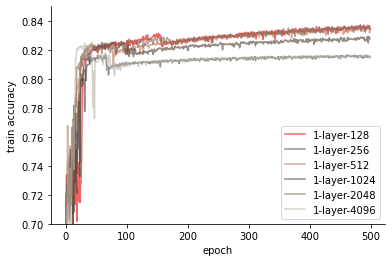

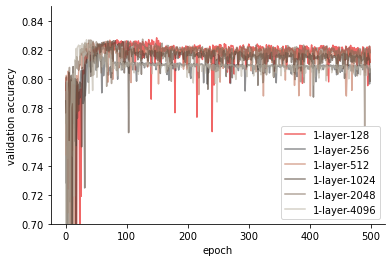

In [43]:
plot_accuracies(hist1_2, colors=['#e60000', '#464749' , '#c07156', '#4d3c2f', '#806b59', '#b9b2a3'], lower_ylim=.7, upper_ylim=.85)

## Learnings

* All models are able to improve and learn.
* The learning rate 0.001 provides much quicker much more consistent results and will therefore be choosen for further models
* The precision and recall dataframes show that the smaller models perform quite well and are able to achieve a better recall than some of the larger models

## Normalization & dropout layers
* Add normalization & dropout layers
* introduce early stopping criterion to speed up training

In [32]:
# lower the number of epochs
epochs = 500

histories = []

name="1-layer-128-norm-dropout"
print(name)
model07 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model07.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

histories.append(model07.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                            validation_data=(x_val,y_val), verbose=2, callbacks=[es]))

name="1-layer-4096-norm-dropout"
print(name)
model08 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model08.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

histories.append(model08.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                            validation_data=(x_val,y_val), verbose=2, callbacks=[es]))


name="2-layer-128-256-norm"
print(name)
model09 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model09.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

histories.append(model09.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                            validation_data=(x_val,y_val), verbose=2, callbacks=[es]))

name="2-layer-128-256-dropout"
print(name)
model10 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model10.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

histories.append(model10.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                            validation_data=(x_val,y_val), verbose=2, callbacks=[es]))


name="2-layer-128-256-norm-dropout"
print(name)
model12 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model12.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

histories.append(model12.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                            validation_data=(x_val,y_val), verbose=2, callbacks=[es]))

name="3-layer-512-256-128-norm-dropout"
print(name)
model13 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model13.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

histories.append(model13.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                            validation_data=(x_val,y_val), verbose=2, callbacks=[es]))
hist2 = histories

1-layer-128-norm-dropout
Epoch 1/500
163/163 - 1s - loss: 0.5667 - accuracy: 0.7903 - val_loss: 0.8006 - val_accuracy: 0.7753
Epoch 2/500
163/163 - 1s - loss: 0.4271 - accuracy: 0.8150 - val_loss: 0.3866 - val_accuracy: 0.8345
Epoch 3/500
163/163 - 1s - loss: 0.3935 - accuracy: 0.8314 - val_loss: 0.3684 - val_accuracy: 0.8426
Epoch 4/500
163/163 - 1s - loss: 0.3731 - accuracy: 0.8405 - val_loss: 0.3623 - val_accuracy: 0.8446
Epoch 5/500
163/163 - 1s - loss: 0.3613 - accuracy: 0.8464 - val_loss: 0.3578 - val_accuracy: 0.8485
Epoch 6/500
163/163 - 1s - loss: 0.3522 - accuracy: 0.8512 - val_loss: 0.3538 - val_accuracy: 0.8506
Epoch 7/500
163/163 - 1s - loss: 0.3464 - accuracy: 0.8544 - val_loss: 0.3525 - val_accuracy: 0.8505
Epoch 8/500
163/163 - 1s - loss: 0.3419 - accuracy: 0.8567 - val_loss: 0.3524 - val_accuracy: 0.8517
Epoch 9/500
163/163 - 1s - loss: 0.3368 - accuracy: 0.8595 - val_loss: 0.3497 - val_accuracy: 0.8522
Epoch 10/500
163/163 - 1s - loss: 0.3321 - accuracy: 0.8619 - val_

Epoch 40/500
163/163 - 5s - loss: 0.1723 - accuracy: 0.9356 - val_loss: 0.5095 - val_accuracy: 0.8373
Epoch 41/500
163/163 - 5s - loss: 0.1656 - accuracy: 0.9384 - val_loss: 0.5432 - val_accuracy: 0.8327
Epoch 42/500
Restoring model weights from the end of the best epoch.
163/163 - 5s - loss: 0.1587 - accuracy: 0.9409 - val_loss: 0.5417 - val_accuracy: 0.8432
Epoch 00042: early stopping
2-layer-128-256-norm
Epoch 1/500
163/163 - 1s - loss: 0.4231 - accuracy: 0.8229 - val_loss: 0.8303 - val_accuracy: 0.7374
Epoch 2/500
163/163 - 1s - loss: 0.3520 - accuracy: 0.8482 - val_loss: 0.4237 - val_accuracy: 0.8312
Epoch 3/500
163/163 - 1s - loss: 0.3374 - accuracy: 0.8552 - val_loss: 0.3822 - val_accuracy: 0.8429
Epoch 4/500
163/163 - 1s - loss: 0.3245 - accuracy: 0.8616 - val_loss: 0.3714 - val_accuracy: 0.8406
Epoch 5/500
163/163 - 1s - loss: 0.3142 - accuracy: 0.8666 - val_loss: 0.3542 - val_accuracy: 0.8476
Epoch 6/500
163/163 - 1s - loss: 0.3015 - accuracy: 0.8729 - val_loss: 0.3719 - val_

Epoch 9/500
163/163 - 1s - loss: 0.3223 - accuracy: 0.8655 - val_loss: 0.3606 - val_accuracy: 0.8361
Epoch 10/500
163/163 - 1s - loss: 0.3168 - accuracy: 0.8680 - val_loss: 0.3467 - val_accuracy: 0.8494
Epoch 11/500
163/163 - 1s - loss: 0.3096 - accuracy: 0.8722 - val_loss: 0.3457 - val_accuracy: 0.8508
Epoch 12/500
163/163 - 1s - loss: 0.3053 - accuracy: 0.8746 - val_loss: 0.3550 - val_accuracy: 0.8460
Epoch 13/500
163/163 - 1s - loss: 0.3013 - accuracy: 0.8757 - val_loss: 0.3512 - val_accuracy: 0.8484
Epoch 14/500
163/163 - 1s - loss: 0.2958 - accuracy: 0.8790 - val_loss: 0.3541 - val_accuracy: 0.8474
Epoch 15/500
163/163 - 1s - loss: 0.2913 - accuracy: 0.8805 - val_loss: 0.3612 - val_accuracy: 0.8464
Epoch 16/500
163/163 - 1s - loss: 0.2838 - accuracy: 0.8841 - val_loss: 0.3578 - val_accuracy: 0.8486
Epoch 17/500
163/163 - 1s - loss: 0.2799 - accuracy: 0.8862 - val_loss: 0.3590 - val_accuracy: 0.8486
Epoch 18/500
163/163 - 1s - loss: 0.2736 - accuracy: 0.8891 - val_loss: 0.3610 - va

In [33]:
acc_df(hist2)

,loss,accuracy,val_loss,val_accuracy
model size,,,,
1-layer-128-norm-dropout,0.33,86.36%,0.35,85.23%
1-layer-4096-norm-dropout,0.31,87.14%,0.35,85.23%
2-layer-128-256-norm,0.30,87.29%,0.37,84.84%
2-layer-128-256-dropout,22.66,70.13%,0.61,71.90%
2-layer-128-256-norm-dropout,0.34,85.67%,0.35,85.12%
3-layer-512-256-128-norm-dropout,0.32,86.51%,0.34,85.40%


In [34]:
models = [model07, model08, model09, model10, model12, model13]
prec_rec_df(models)

C:\Users\ax_el\anaconda3\envs\tensorflow_gpu\lib\site-packages\ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in longlong_scalars


,precision (cancer positive),recall (cancer positive)
model,,
1-layer-128-norm-dropout,75.57%,69.92%
1-layer-4096-norm-dropout,76.24%,68.76%
2-layer-128-256-norm,72.73%,71.89%
2-layer-128-256-dropout,nan%,0.00%
2-layer-128-256-norm-dropout,72.64%,74.42%
3-layer-512-256-128-norm-dropout,74.38%,72.88%


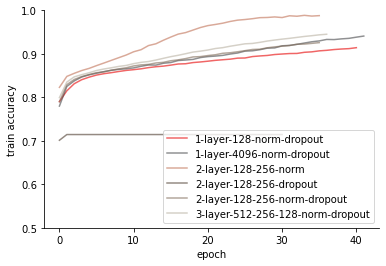

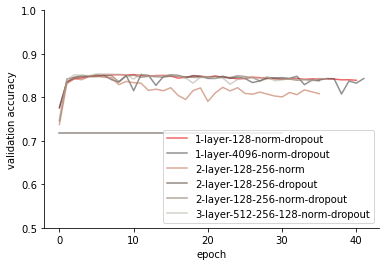

In [44]:
plot_accuracies(hist2, colors=['#e60000', '#464749' , '#c07156', '#4d3c2f', '#806b59', '#b9b2a3'], lower_ylim=.5, upper_ylim=1)

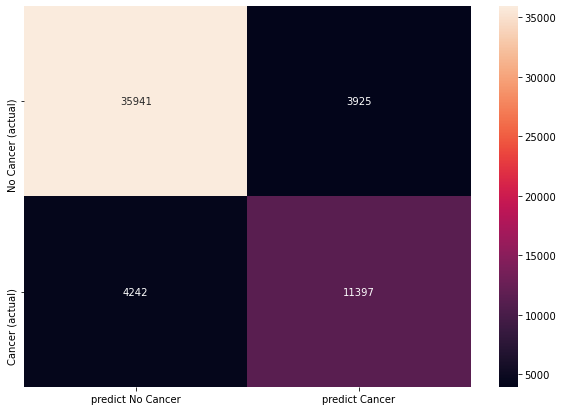

In [36]:
# plot confuction matrix
plt=conf_matrix(model13, x_test, y_test)
plt.show()

## Learnings
* In the above chart we first of all see that just increasing the number of layers and the number of hidden nodes per layer did not improve the performance. On the contrary we can recognize that in the 4th network the loss is increasing significantly.
* None of the models are able to reach higher recall than 72.28%, which we still consider too low for our application

With the different model sizes, learning rates, normalization and dropout layers most issues should have been tackled, so lets run the above models again with balanced weights, that account for the relative number of positive/negative patches, this should greatly increse the recall, possibly on cost of accuracy.

## Balanced Weights
* Adding balanced weights for all networks
* Adding a learning rate schedule for the learning rate
* Increase the initial learning rate to 0.1

In [48]:
# lower the number of epochs
epochs = 500

histories = []

name="1-layer-128-norm-dropout"
print(name)
model14 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model14.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.01), metrics=["accuracy"])

histories.append(model14.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                            validation_data=(x_val,y_val), verbose=2, callbacks=[lrr, es],
                            class_weight=class_weight))


name="2-layer-128-256-norm-dropout"
print(name)
model15 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model15.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.01), metrics=["accuracy"])

histories.append(model15.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                            validation_data=(x_val,y_val), verbose=2, callbacks=[lrr, es],
                            class_weight=class_weight))

name="3-layer-512-256-128-norm-dropout"
print(name)
model16 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model16.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.01), metrics=["accuracy"])

histories.append(model16.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                            validation_data=(x_val,y_val), verbose=2, callbacks=[lrr, es],
                            class_weight=class_weight))
hist3 = histories

1-layer-128-norm-dropout
Epoch 1/500
163/163 - 1s - loss: 1.0413 - accuracy: 0.7750 - val_loss: 1.0138 - val_accuracy: 0.7725
Epoch 2/500
163/163 - 1s - loss: 0.8975 - accuracy: 0.7960 - val_loss: 0.4032 - val_accuracy: 0.8248
Epoch 3/500
163/163 - 1s - loss: 0.8665 - accuracy: 0.8047 - val_loss: 0.3987 - val_accuracy: 0.8227
Epoch 4/500
163/163 - 1s - loss: 0.8500 - accuracy: 0.8096 - val_loss: 0.4249 - val_accuracy: 0.8036
Epoch 5/500
163/163 - 1s - loss: 0.8384 - accuracy: 0.8116 - val_loss: 0.4140 - val_accuracy: 0.8114
Epoch 6/500
163/163 - 1s - loss: 0.8254 - accuracy: 0.8155 - val_loss: 0.4187 - val_accuracy: 0.8109
Epoch 7/500
163/163 - 1s - loss: 0.8134 - accuracy: 0.8190 - val_loss: 0.4598 - val_accuracy: 0.7861
Epoch 8/500
163/163 - 1s - loss: 0.7990 - accuracy: 0.8215 - val_loss: 0.4219 - val_accuracy: 0.8048
Epoch 9/500
163/163 - 1s - loss: 0.7892 - accuracy: 0.8242 - val_loss: 0.3944 - val_accuracy: 0.8275
Epoch 10/500
163/163 - 1s - loss: 0.7808 - accuracy: 0.8264 - val_

Epoch 21/500
163/163 - 1s - loss: 0.6497 - accuracy: 0.8596 - val_loss: 0.3984 - val_accuracy: 0.8249
Epoch 22/500
163/163 - 1s - loss: 0.6394 - accuracy: 0.8619 - val_loss: 0.3988 - val_accuracy: 0.8230
Epoch 23/500
163/163 - 1s - loss: 0.6325 - accuracy: 0.8628 - val_loss: 0.3866 - val_accuracy: 0.8373
Epoch 24/500
163/163 - 1s - loss: 0.6216 - accuracy: 0.8646 - val_loss: 0.4193 - val_accuracy: 0.8303
Epoch 25/500
163/163 - 1s - loss: 0.6150 - accuracy: 0.8653 - val_loss: 0.4004 - val_accuracy: 0.8339
Epoch 26/500
163/163 - 1s - loss: 0.6032 - accuracy: 0.8684 - val_loss: 0.3952 - val_accuracy: 0.8324
Epoch 27/500
163/163 - 1s - loss: 0.5967 - accuracy: 0.8707 - val_loss: 0.3980 - val_accuracy: 0.8425
Epoch 28/500
163/163 - 1s - loss: 0.5865 - accuracy: 0.8718 - val_loss: 0.4340 - val_accuracy: 0.8216
Epoch 29/500
163/163 - 1s - loss: 0.5823 - accuracy: 0.8735 - val_loss: 0.4252 - val_accuracy: 0.8169
Epoch 30/500
163/163 - 1s - loss: 0.5671 - accuracy: 0.8754 - val_loss: 0.4315 - v

In [49]:
acc_df(hist3)

,loss,accuracy,val_loss,val_accuracy
model size,,,,
1-layer-128-norm-dropout,0.66,85.69%,0.39,83.86%
2-layer-128-256-norm-dropout,0.60,87.07%,0.40,84.25%
3-layer-512-256-128-norm-dropout,0.84,81.93%,0.38,84.20%


In [50]:
models = [model14, model15, model16]
prec_rec_df(models)

,precision (cancer positive),recall (cancer positive)
model,,
1-layer-128-norm-dropout,69.49%,75.71%
2-layer-128-256-norm-dropout,70.47%,74.99%
3-layer-512-256-128-norm-dropout,74.38%,65.50%


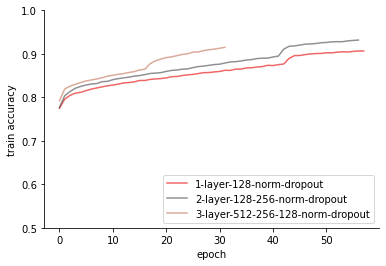

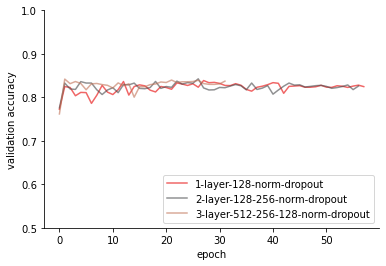

In [51]:
plot_accuracies(hist3, colors=['#e60000' , '#464749', '#c07156', '#4d3c2f', '#806b59', '#b9b2a3'], lower_ylim=.5, upper_ylim=1)

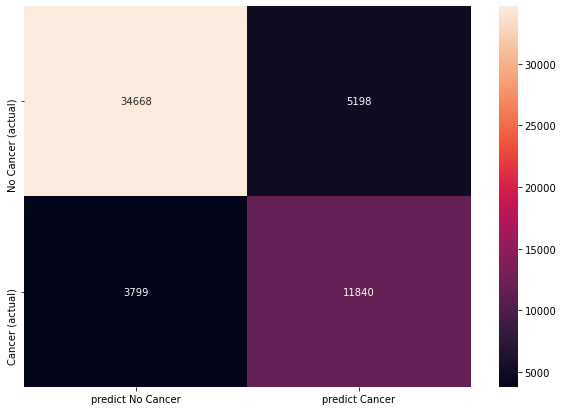

In [52]:
# plot confuction matrix
plt=conf_matrix(model14, x_test, y_test)
plt.show()

## Learnings
- The confusion matrix starts to look better, malicious cells are now classified much less as non-malicious than before
- In the graph above we see that the validation accuracy and loss is decreasing/increasing towards the end
- Train accuracy is now much closer to the validation accuracy (at least for the best epoch) over time they still diverge

Since the training and validatio accuracy are close we can reduce the dropout rate, but at the same time we will add an imageDataGenerator to hopefully increase generalizability of our model.

## Image Data Augmentation
* Introduce image data augmentation
* Run the same models from the last experiment

In [21]:
#Image Data Augmentation

train_generator = ImageDataGenerator(horizontal_flip=True,
                                     vertical_flip=True)

test_generator = ImageDataGenerator(horizontal_flip=True,
                                    vertical_flip=True)

val_generator = ImageDataGenerator(horizontal_flip=True,
                                   vertical_flip=True)

train_generator.fit(x_train)
test_generator.fit(x_test)
val_generator.fit(x_val)

In [53]:
histories = []

name="1-layer-128-norm-dropout"
print(name)
model17 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model17.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.01), metrics=["accuracy"])

histories.append(model17.fit(train_generator.flow(x_train, y_train, batch_size=32),
                             batch_size=batch_size, epochs=epochs,
                             validation_data=val_generator.flow(x_val,y_val, batch_size=32),
                             verbose=1, callbacks=[lrr, es],
                             class_weight=class_weight))

name="2-layer-128-256-norm-dropout"
print(name)
model18 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model18.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.01), metrics=["accuracy"])

histories.append(model18.fit(train_generator.flow(x_train, y_train, batch_size=32),
                             batch_size=batch_size, epochs=epochs,
                             validation_data=val_generator.flow(x_val,y_val, batch_size=32),
                             verbose=1, callbacks=[lrr, es],
                             class_weight=class_weight))

name="3-layer-512-256-128-norm-dropout"
print(name)
model19 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model19.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.01), metrics=["accuracy"])

histories.append(model19.fit(train_generator.flow(x_train, y_train, batch_size=32),
                             batch_size=batch_size, epochs=epochs,
                             validation_data=val_generator.flow(x_val,y_val, batch_size=32),
                             verbose=1, callbacks=[lrr, es],
                             class_weight=class_weight))
hist4 = histories

1-layer-128-norm-dropout
Epoch 1/500
5204/5204 [==============================] - 16s 3ms/step - loss: 0.9459 - accuracy: 0.7821 - val_loss: 0.4643 - val_accuracy: 0.7881
Epoch 2/500
5204/5204 [==============================] - 17s 3ms/step - loss: 0.9217 - accuracy: 0.7873 - val_loss: 0.4401 - val_accuracy: 0.7965
Epoch 3/500
5204/5204 [==============================] - 16s 3ms/step - loss: 0.9113 - accuracy: 0.7898 - val_loss: 0.4538 - val_accuracy: 0.7939
Epoch 4/500
5204/5204 [==============================] - 16s 3ms/step - loss: 0.8942 - accuracy: 0.7956 - val_loss: 0.4362 - val_accuracy: 0.8057
Epoch 5/500
5204/5204 [==============================] - 16s 3ms/step - loss: 0.8897 - accuracy: 0.7988 - val_loss: 0.5026 - val_accuracy: 0.7591
Epoch 6/500
5204/5204 [==============================] - 16s 3ms/step - loss: 0.8881 - accuracy: 0.7993 - val_loss: 0.4034 - val_accuracy: 0.8272
Epoch 7/500
5204/5204 [==============================] - 16s 3ms/step - loss: 0.8806 - accuracy: 0.

5204/5204 [==============================] - 16s 3ms/step - loss: 0.7961 - accuracy: 0.8209 - val_loss: 0.3883 - val_accuracy: 0.8290
Epoch 56/500
5204/5204 [==============================] - 16s 3ms/step - loss: 0.7965 - accuracy: 0.8222 - val_loss: 0.3896 - val_accuracy: 0.8259
Epoch 57/500
5204/5204 [==============================] - 16s 3ms/step - loss: 0.7963 - accuracy: 0.8211 - val_loss: 0.3715 - val_accuracy: 0.8373
Epoch 58/500
5204/5204 [==============================] - 16s 3ms/step - loss: 0.7941 - accuracy: 0.8213 - val_loss: 0.3679 - val_accuracy: 0.8383
Epoch 59/500
5204/5204 [==============================] - 16s 3ms/step - loss: 0.7951 - accuracy: 0.8226 - val_loss: 0.3827 - val_accuracy: 0.8320
Epoch 60/500
5204/5204 [==============================] - 16s 3ms/step - loss: 0.7938 - accuracy: 0.8209 - val_loss: 0.3750 - val_accuracy: 0.8357
Epoch 61/500
5189/5204 [============================>.] - ETA: 0s - loss: 0.7931 - accuracy: 0.8223
Epoch 00061: ReduceLROnPlateau 

Epoch 47/500
5204/5204 [==============================] - 18s 3ms/step - loss: 0.7884 - accuracy: 0.8292 - val_loss: 0.3812 - val_accuracy: 0.8373
Epoch 48/500
5204/5204 [==============================] - 18s 3ms/step - loss: 0.7858 - accuracy: 0.8292 - val_loss: 0.3735 - val_accuracy: 0.8375
Epoch 49/500
5204/5204 [==============================] - 18s 3ms/step - loss: 0.7860 - accuracy: 0.8294 - val_loss: 0.3794 - val_accuracy: 0.8366
Epoch 50/500
5204/5204 [==============================] - 18s 3ms/step - loss: 0.7874 - accuracy: 0.8286 - val_loss: 0.3718 - val_accuracy: 0.8388
Epoch 51/500
5204/5204 [==============================] - 18s 3ms/step - loss: 0.7814 - accuracy: 0.8309 - val_loss: 0.3739 - val_accuracy: 0.8383
Epoch 52/500
5204/5204 [==============================] - 18s 3ms/step - loss: 0.7821 - accuracy: 0.8296 - val_loss: 0.3756 - val_accuracy: 0.8389
Epoch 53/500
5204/5204 [==============================] - 18s 3ms/step - loss: 0.7811 - accuracy: 0.8307 - val_loss: 0

Epoch 30/500
5204/5204 [==============================] - 22s 4ms/step - loss: 0.7950 - accuracy: 0.8239 - val_loss: 0.3760 - val_accuracy: 0.8404
Epoch 31/500
5204/5204 [==============================] - 22s 4ms/step - loss: 0.7881 - accuracy: 0.8267 - val_loss: 0.3851 - val_accuracy: 0.8293
Epoch 32/500
5204/5204 [==============================] - 22s 4ms/step - loss: 0.7880 - accuracy: 0.8266 - val_loss: 0.3878 - val_accuracy: 0.8295
Epoch 33/500
5204/5204 [==============================] - 22s 4ms/step - loss: 0.7874 - accuracy: 0.8260 - val_loss: 0.3735 - val_accuracy: 0.8358
Epoch 34/500
5204/5204 [==============================] - 23s 4ms/step - loss: 0.7838 - accuracy: 0.8269 - val_loss: 0.3956 - val_accuracy: 0.8276
Epoch 35/500
5204/5204 [==============================] - 22s 4ms/step - loss: 0.7824 - accuracy: 0.8278 - val_loss: 0.4392 - val_accuracy: 0.8362
Epoch 36/500
5204/5204 [==============================] - 22s 4ms/step - loss: 0.7790 - accuracy: 0.8285 - val_loss: 0

In [54]:
acc_df(hist4)

,loss,accuracy,val_loss,val_accuracy
model size,,,,
1-layer-128-norm-dropout,0.85,80.92%,0.36,84.28%
2-layer-128-256-norm-dropout,0.79,82.88%,0.36,84.89%
3-layer-512-256-128-norm-dropout,0.83,81.65%,0.36,84.93%


In [55]:
models = [model17, model18, model19]
prec_rec_df(models)

,precision (cancer positive),recall (cancer positive)
model,,
1-layer-128-norm-dropout,69.92%,77.40%
2-layer-128-256-norm-dropout,70.66%,78.60%
3-layer-512-256-128-norm-dropout,71.55%,76.96%


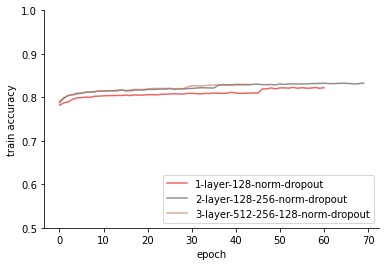

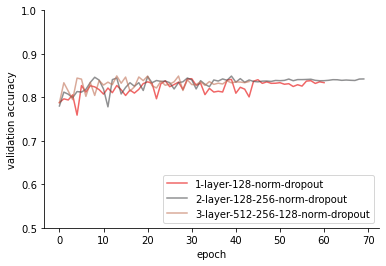

In [56]:
plot_accuracies(hist4, colors=['#e60000', '#464749', '#c07156', '#4d3c2f', '#806b59', '#b9b2a3'], lower_ylim=.5, upper_ylim=1)

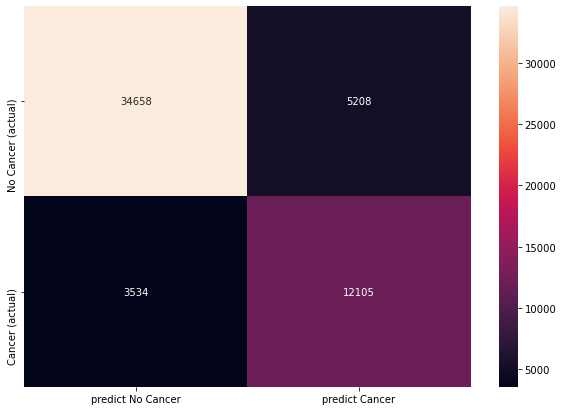

In [59]:
# plot confuction matrix
plt=conf_matrix(model17, x_test, y_test)
plt.show()

## Learnings
* Results did not improve with the image data generator
* train accuracy and validation accuracy are very close to each other

This could indicate that the dropout layers are too high

## final network
To combine the learnings from all previous models:
    * A network with one hidden layer with 128 nodes, with normalization, dropout, learning rate schedule, class weights and image data generator was choosen.
    * Compared the the models before the dropout rate was reduced from 0.4 to 0.1

In [22]:
epochs = 1000

histories = []
name="1-layer-128-norm-dropout-lower"
print(name)
model20 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.1),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model20.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.01), metrics=["accuracy"])

histories.append(model20.fit(train_generator.flow(x_train, y_train, batch_size=32),
                             batch_size=batch_size, epochs=epochs,
                             validation_data=val_generator.flow(x_val,y_val, batch_size=32),
                             verbose=1, callbacks=[lrr],
                             class_weight=class_weight))
hist5 = histories

1-layer-128-norm-dropout-lower
Epoch 1/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.9224 - accuracy: 0.7867 - val_loss: 0.4226 - val_accuracy: 0.8088
Epoch 2/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.8839 - accuracy: 0.7984 - val_loss: 0.4641 - val_accuracy: 0.7769
Epoch 3/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.8715 - accuracy: 0.8030 - val_loss: 0.4051 - val_accuracy: 0.8147
Epoch 4/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.8635 - accuracy: 0.8053 - val_loss: 0.4020 - val_accuracy: 0.8234
Epoch 5/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.8599 - accuracy: 0.8058 - val_loss: 0.3868 - val_accuracy: 0.8290
Epoch 6/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.8544 - accuracy: 0.8075 - val_loss: 0.4008 - val_accuracy: 0.8183
Epoch 7/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.8510 -

5204/5204 [==============================] - 14s 3ms/step - loss: 0.7662 - accuracy: 0.8305 - val_loss: 0.3807 - val_accuracy: 0.8317
Epoch 55/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7686 - accuracy: 0.8287 - val_loss: 0.3754 - val_accuracy: 0.8357
Epoch 56/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7664 - accuracy: 0.8298 - val_loss: 0.3768 - val_accuracy: 0.8338
Epoch 57/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7693 - accuracy: 0.8285 - val_loss: 0.3763 - val_accuracy: 0.8340
Epoch 58/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7657 - accuracy: 0.8288 - val_loss: 0.3784 - val_accuracy: 0.8346
Epoch 59/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7664 - accuracy: 0.8293 - val_loss: 0.3735 - val_accuracy: 0.8361
Epoch 60/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7683 - accuracy: 0.8287 - val_loss: 0.3727 -

5204/5204 [==============================] - 14s 3ms/step - loss: 0.7648 - accuracy: 0.8305 - val_loss: 0.3754 - val_accuracy: 0.8351
Epoch 110/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7635 - accuracy: 0.8316 - val_loss: 0.3869 - val_accuracy: 0.8293
Epoch 111/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7653 - accuracy: 0.8294 - val_loss: 0.3767 - val_accuracy: 0.8347
Epoch 112/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7634 - accuracy: 0.8308 - val_loss: 0.3782 - val_accuracy: 0.8340
Epoch 113/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7660 - accuracy: 0.8296 - val_loss: 0.3778 - val_accuracy: 0.8349
Epoch 114/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7641 - accuracy: 0.8306 - val_loss: 0.3704 - val_accuracy: 0.8376
Epoch 115/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7673 - accuracy: 0.8292 - val_loss: 0.

5204/5204 [==============================] - 14s 3ms/step - loss: 0.7614 - accuracy: 0.8307 - val_loss: 0.3791 - val_accuracy: 0.8331
Epoch 165/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7623 - accuracy: 0.8309 - val_loss: 0.3728 - val_accuracy: 0.8364
Epoch 166/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7618 - accuracy: 0.8314 - val_loss: 0.3710 - val_accuracy: 0.8374
Epoch 167/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7604 - accuracy: 0.8307 - val_loss: 0.3742 - val_accuracy: 0.8344
Epoch 168/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7625 - accuracy: 0.8313 - val_loss: 0.3737 - val_accuracy: 0.8359
Epoch 169/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7629 - accuracy: 0.8313 - val_loss: 0.3738 - val_accuracy: 0.8359
Epoch 170/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7623 - accuracy: 0.8310 - val_loss: 0.

5204/5204 [==============================] - 14s 3ms/step - loss: 0.7594 - accuracy: 0.8315 - val_loss: 0.3756 - val_accuracy: 0.8343
Epoch 220/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7595 - accuracy: 0.8317 - val_loss: 0.3779 - val_accuracy: 0.8343
Epoch 221/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7587 - accuracy: 0.8313 - val_loss: 0.3743 - val_accuracy: 0.8352
Epoch 222/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7589 - accuracy: 0.8322 - val_loss: 0.3770 - val_accuracy: 0.8340
Epoch 223/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7596 - accuracy: 0.8312 - val_loss: 0.3729 - val_accuracy: 0.8371
Epoch 224/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7590 - accuracy: 0.8323 - val_loss: 0.3735 - val_accuracy: 0.8374
Epoch 225/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7607 - accuracy: 0.8309 - val_loss: 0.

5204/5204 [==============================] - 14s 3ms/step - loss: 0.7576 - accuracy: 0.8325 - val_loss: 0.3775 - val_accuracy: 0.8342
Epoch 275/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7581 - accuracy: 0.8323 - val_loss: 0.3718 - val_accuracy: 0.8383
Epoch 276/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7579 - accuracy: 0.8322 - val_loss: 0.3750 - val_accuracy: 0.8361
Epoch 277/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7593 - accuracy: 0.8318 - val_loss: 0.3744 - val_accuracy: 0.8363
Epoch 278/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7562 - accuracy: 0.8325 - val_loss: 0.3806 - val_accuracy: 0.8329
Epoch 279/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7586 - accuracy: 0.8317 - val_loss: 0.3786 - val_accuracy: 0.8343
Epoch 280/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7617 - accuracy: 0.8304 - val_loss: 0.

5204/5204 [==============================] - 14s 3ms/step - loss: 0.7556 - accuracy: 0.8327 - val_loss: 0.3740 - val_accuracy: 0.8358
Epoch 330/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7567 - accuracy: 0.8320 - val_loss: 0.3693 - val_accuracy: 0.8384
Epoch 331/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7567 - accuracy: 0.8326 - val_loss: 0.3746 - val_accuracy: 0.8367
Epoch 332/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7557 - accuracy: 0.8328 - val_loss: 0.3710 - val_accuracy: 0.8378
Epoch 333/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7565 - accuracy: 0.8319 - val_loss: 0.3752 - val_accuracy: 0.8360
Epoch 334/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7576 - accuracy: 0.8324 - val_loss: 0.3715 - val_accuracy: 0.8372
Epoch 335/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7556 - accuracy: 0.8323 - val_loss: 0.

5204/5204 [==============================] - 14s 3ms/step - loss: 0.7570 - accuracy: 0.8335 - val_loss: 0.3710 - val_accuracy: 0.8377
Epoch 385/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7546 - accuracy: 0.8333 - val_loss: 0.3752 - val_accuracy: 0.8362
Epoch 386/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7555 - accuracy: 0.8322 - val_loss: 0.3683 - val_accuracy: 0.8390
Epoch 387/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7514 - accuracy: 0.8341 - val_loss: 0.3721 - val_accuracy: 0.8373
Epoch 388/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7544 - accuracy: 0.8340 - val_loss: 0.3757 - val_accuracy: 0.8353
Epoch 389/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7581 - accuracy: 0.8326 - val_loss: 0.3724 - val_accuracy: 0.8376
Epoch 390/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7539 - accuracy: 0.8329 - val_loss: 0.

5204/5204 [==============================] - 14s 3ms/step - loss: 0.7517 - accuracy: 0.8339 - val_loss: 0.3697 - val_accuracy: 0.8390
Epoch 440/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7495 - accuracy: 0.8346 - val_loss: 0.3778 - val_accuracy: 0.8340
Epoch 441/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7522 - accuracy: 0.8336 - val_loss: 0.3761 - val_accuracy: 0.8357
Epoch 442/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7521 - accuracy: 0.8339 - val_loss: 0.3714 - val_accuracy: 0.8384
Epoch 443/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7517 - accuracy: 0.8338 - val_loss: 0.3730 - val_accuracy: 0.8366
Epoch 444/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7507 - accuracy: 0.8344 - val_loss: 0.3755 - val_accuracy: 0.8367
Epoch 445/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7499 - accuracy: 0.8342 - val_loss: 0.

5204/5204 [==============================] - 14s 3ms/step - loss: 0.7458 - accuracy: 0.8348 - val_loss: 0.3766 - val_accuracy: 0.8352
Epoch 495/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7493 - accuracy: 0.8341 - val_loss: 0.3746 - val_accuracy: 0.8373
Epoch 496/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7488 - accuracy: 0.8348 - val_loss: 0.3717 - val_accuracy: 0.8382
Epoch 497/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7500 - accuracy: 0.8332 - val_loss: 0.3739 - val_accuracy: 0.8374
Epoch 498/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7506 - accuracy: 0.8340 - val_loss: 0.3698 - val_accuracy: 0.8395
Epoch 499/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7476 - accuracy: 0.8346 - val_loss: 0.3740 - val_accuracy: 0.8355
Epoch 500/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7487 - accuracy: 0.8346 - val_loss: 0.

5204/5204 [==============================] - 14s 3ms/step - loss: 0.7487 - accuracy: 0.8340 - val_loss: 0.3721 - val_accuracy: 0.8374
Epoch 550/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7458 - accuracy: 0.8354 - val_loss: 0.3700 - val_accuracy: 0.8378
Epoch 551/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7462 - accuracy: 0.8352 - val_loss: 0.3729 - val_accuracy: 0.8370
Epoch 552/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7489 - accuracy: 0.8340 - val_loss: 0.3714 - val_accuracy: 0.8374
Epoch 553/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7460 - accuracy: 0.8343 - val_loss: 0.3774 - val_accuracy: 0.8350
Epoch 554/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7461 - accuracy: 0.8351 - val_loss: 0.3711 - val_accuracy: 0.8379
Epoch 555/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7464 - accuracy: 0.8353 - val_loss: 0.

5204/5204 [==============================] - 14s 3ms/step - loss: 0.7455 - accuracy: 0.8347 - val_loss: 0.3724 - val_accuracy: 0.8373
Epoch 605/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7442 - accuracy: 0.8358 - val_loss: 0.3773 - val_accuracy: 0.8349
Epoch 606/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7451 - accuracy: 0.8353 - val_loss: 0.3679 - val_accuracy: 0.8395
Epoch 607/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7450 - accuracy: 0.8359 - val_loss: 0.3748 - val_accuracy: 0.8373
Epoch 608/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7439 - accuracy: 0.8353 - val_loss: 0.3716 - val_accuracy: 0.8381
Epoch 609/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7456 - accuracy: 0.8352 - val_loss: 0.3707 - val_accuracy: 0.8393
Epoch 610/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7446 - accuracy: 0.8353 - val_loss: 0.

5204/5204 [==============================] - 14s 3ms/step - loss: 0.7421 - accuracy: 0.8356 - val_loss: 0.3701 - val_accuracy: 0.8383
Epoch 660/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7433 - accuracy: 0.8361 - val_loss: 0.3686 - val_accuracy: 0.8391
Epoch 661/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7441 - accuracy: 0.8362 - val_loss: 0.3736 - val_accuracy: 0.8365
Epoch 662/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7427 - accuracy: 0.8357 - val_loss: 0.3735 - val_accuracy: 0.8373
Epoch 663/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7398 - accuracy: 0.8358 - val_loss: 0.3696 - val_accuracy: 0.8380
Epoch 664/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7424 - accuracy: 0.8364 - val_loss: 0.3694 - val_accuracy: 0.8390
Epoch 665/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7441 - accuracy: 0.8362 - val_loss: 0.

5204/5204 [==============================] - 14s 3ms/step - loss: 0.7409 - accuracy: 0.8368 - val_loss: 0.3683 - val_accuracy: 0.8403
Epoch 715/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7394 - accuracy: 0.8370 - val_loss: 0.3681 - val_accuracy: 0.8403
Epoch 716/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7421 - accuracy: 0.8361 - val_loss: 0.3703 - val_accuracy: 0.8386
Epoch 717/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7392 - accuracy: 0.8371 - val_loss: 0.3726 - val_accuracy: 0.8362
Epoch 718/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7420 - accuracy: 0.8363 - val_loss: 0.3705 - val_accuracy: 0.8391
Epoch 719/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7363 - accuracy: 0.8376 - val_loss: 0.3715 - val_accuracy: 0.8372
Epoch 720/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7402 - accuracy: 0.8358 - val_loss: 0.

5204/5204 [==============================] - 14s 3ms/step - loss: 0.7372 - accuracy: 0.8374 - val_loss: 0.3735 - val_accuracy: 0.8366
Epoch 770/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7395 - accuracy: 0.8369 - val_loss: 0.3723 - val_accuracy: 0.8370
Epoch 771/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7396 - accuracy: 0.8367 - val_loss: 0.3727 - val_accuracy: 0.8370
Epoch 772/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7365 - accuracy: 0.8371 - val_loss: 0.3674 - val_accuracy: 0.8397
Epoch 773/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7386 - accuracy: 0.8373 - val_loss: 0.3704 - val_accuracy: 0.8382
Epoch 774/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7381 - accuracy: 0.8365 - val_loss: 0.3702 - val_accuracy: 0.8388
Epoch 775/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7385 - accuracy: 0.8364 - val_loss: 0.

5204/5204 [==============================] - 14s 3ms/step - loss: 0.7314 - accuracy: 0.8393 - val_loss: 0.3737 - val_accuracy: 0.8372
Epoch 825/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7364 - accuracy: 0.8373 - val_loss: 0.3735 - val_accuracy: 0.8369
Epoch 826/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7368 - accuracy: 0.8378 - val_loss: 0.3698 - val_accuracy: 0.8390
Epoch 827/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7354 - accuracy: 0.8379 - val_loss: 0.3689 - val_accuracy: 0.8392
Epoch 828/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7340 - accuracy: 0.8381 - val_loss: 0.3744 - val_accuracy: 0.8356
Epoch 829/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7360 - accuracy: 0.8376 - val_loss: 0.3786 - val_accuracy: 0.8352
Epoch 830/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7379 - accuracy: 0.8376 - val_loss: 0.

5204/5204 [==============================] - 14s 3ms/step - loss: 0.7333 - accuracy: 0.8384 - val_loss: 0.3758 - val_accuracy: 0.8357
Epoch 880/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7304 - accuracy: 0.8385 - val_loss: 0.3735 - val_accuracy: 0.8376
Epoch 881/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7343 - accuracy: 0.8379 - val_loss: 0.3735 - val_accuracy: 0.8370
Epoch 882/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7343 - accuracy: 0.8383 - val_loss: 0.3718 - val_accuracy: 0.8384
Epoch 883/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7354 - accuracy: 0.8390 - val_loss: 0.3720 - val_accuracy: 0.8379
Epoch 884/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7330 - accuracy: 0.8380 - val_loss: 0.3692 - val_accuracy: 0.8395
Epoch 885/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7316 - accuracy: 0.8391 - val_loss: 0.

5204/5204 [==============================] - 14s 3ms/step - loss: 0.7293 - accuracy: 0.8389 - val_loss: 0.3732 - val_accuracy: 0.8369
Epoch 935/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7296 - accuracy: 0.8399 - val_loss: 0.3691 - val_accuracy: 0.8393
Epoch 936/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7323 - accuracy: 0.8383 - val_loss: 0.3741 - val_accuracy: 0.8370
Epoch 937/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7293 - accuracy: 0.8387 - val_loss: 0.3743 - val_accuracy: 0.8368
Epoch 938/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7291 - accuracy: 0.8387 - val_loss: 0.3758 - val_accuracy: 0.8355
Epoch 939/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7304 - accuracy: 0.8391 - val_loss: 0.3690 - val_accuracy: 0.8396
Epoch 940/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7313 - accuracy: 0.8399 - val_loss: 0.

5204/5204 [==============================] - 14s 3ms/step - loss: 0.7307 - accuracy: 0.8392 - val_loss: 0.3714 - val_accuracy: 0.8381
Epoch 990/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7271 - accuracy: 0.8400 - val_loss: 0.3719 - val_accuracy: 0.8379
Epoch 991/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7277 - accuracy: 0.8399 - val_loss: 0.3758 - val_accuracy: 0.8359
Epoch 992/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7296 - accuracy: 0.8387 - val_loss: 0.3664 - val_accuracy: 0.8420
Epoch 993/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7250 - accuracy: 0.8403 - val_loss: 0.3707 - val_accuracy: 0.8390
Epoch 994/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7290 - accuracy: 0.8390 - val_loss: 0.3716 - val_accuracy: 0.8389
Epoch 995/1000
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7289 - accuracy: 0.8397 - val_loss: 0.

In [23]:
acc_df(hist5)

,loss,accuracy,val_loss,val_accuracy
model size,,,,
1-layer-128-norm-dropout-lower,0.82,81.53%,0.37,84.45%


In [24]:
models = [model20]
prec_rec_df(models)

,precision (cancer positive),recall (cancer positive)
model,,
1-layer-128-norm-dropout-lower,67.78%,81.93%


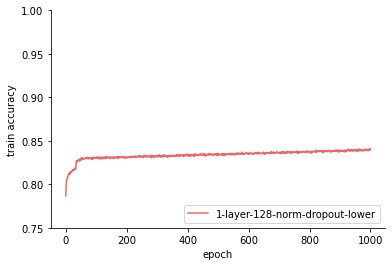

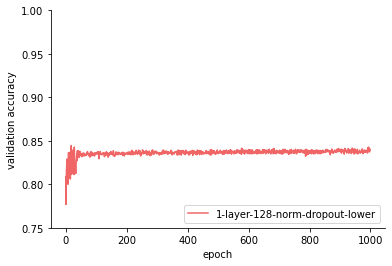

In [47]:
plot_accuracies(hist5, colors=['#e60000', '#464749', '#c07156', '#4d3c2f', '#806b59', '#b9b2a3'], lower_ylim=.75, upper_ylim=1)

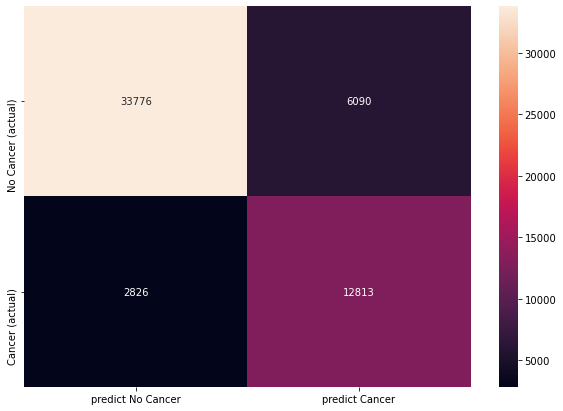

In [26]:
# plot confuction matrix
plt=conf_matrix(model20, x_test, y_test)
plt.show()

In [57]:
models = [model1, model2, model3, model4, model01, model02, model03, model04, model05,
          model06, model001, model002, model003, model004, model005,
          model006, model07, model08, model09, model10, model12, model13,
         model14, model15, model16, model17, model18, model19]
final_hist = [hist0, hist1, hist2, hist3, hist4, hist5]

In [58]:
acc_df(final_hist)

AttributeError: 'list' object has no attribute 'history'

In [ ]:
prec_rec_df(models)

# Results

The final model does not seem to be far superior to previous ones if we observe the accuracy and the loss. It has one of the best performances if we measure validation loss and accuracy, but the first model with the learning rate 0.01 reached a similar performance according to those measures.
Since we are building a model for medical diagnosis, accuracy and loss are not neccessarily the most important measures (even though it makes sense to optimize them). including the confusion matrix in our model evaluation shows that we are constantly improving on predicting malicious cells and also minimize the classification of malicious cells as harmless, a missclassification, which could have severe implications for the patient.

Increasing the size of the model to a certain size, adding dropout and normalization layers, countering the imbalance of the data with balanced weights as well as applying a learning rate schedule improved the result significantly.

